# Generating dataframe for stability data and feature selections

In [1]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
import statsmodels.formula.api as smf
import os
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp #ode integration
import matplotlib.pyplot as plt
import itertools
import pingouin
from cliffs_delta import cliffs_delta
import itertools
os.chdir('./data')
os.getcwd()

'/Users/shibasakishota/Desktop/スイス留学/Data/Project4/data'

In [24]:
# convergence check
def Comp(x):
    # comver abundance data into composition data
    # x should be 1dim array of species abundances
    return x>pow(10, -5)

def ODE_structured(t,x,  r_up, r_down, A):
    # note that -A represents intertaction matrix
    dx=np.zeros([np.size(x)])
    N_up=np.size(r_up)
    N_down=np.size(r_down)
    for i in range(N_up):
        # upstream community
        if x[i]>pow(10, -6):
            dx[i] = x[i]*(r_up[i] - np.dot(A[i, :], x[:N_up]))
    for i in range(N_down):
        if x[i+N_up]>pow(10, -6):
            dx[i+N_up]=x[i+N_up]*(r_down[i]-np.dot(A[i, :], x[:N_up]) - np.dot( A[i, :N_down], x[N_up:]))
    return dx

def Difference(x,y):
    diff=0
    for i in range(len(x)):
        if x[i]< pow(10, -6):
            x[i]=0
        if y[i]< pow(10, -6):  
            y[i]=0
        if x[i]>pow(10, -6):
            diff=diff+abs(x[i]-y[i])/x[i]
    return diff /len(x)
            

def main_convergence(c_list=[0.25, 0.5,1.00], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], 
                  mu_list=[0.0, 0.25, 0.5, 1.0, 2.0], replicate=5):
    Diff=list()
    for i in range(len(c_list)):
        connect=c_list[i]
        os.chdir(str('./connectance%.2f' %(connect)))
        for j in range(replicate):
            os.chdir(str('./replicate%d' %(j)))
            print(str('connectance %.2f replicate %d' %(connect, j)))
            r_up=np.loadtxt('growthrate_up.csv', delimiter=',')
            r_down=np.loadtxt('growthrate_down.csv', delimiter=',')
            A=np.loadtxt('interaction.csv', delimiter=',')
            N=np.size(r_up) # max number of species in each patch
            for k in range(len(rho_list)):
                rho=rho_list[k]
                for l in range(len(mu_list)):
                    mu=mu_list[l]
                    os.chdir(str('./rho%.2f_mu%.2f/designing2' %(rho, mu)))
                    # start analysis
                    stability=np.loadtxt('stability_new.csv', delimiter=',')
                    target_down=np.loadtxt('target_down.csv', delimiter=',')
                    upstream=np.loadtxt('upstream_community.csv', delimiter=',')
                    for s in range(len(stability)):
                        if np.isnan(stability[s])==False:
                            # we analyze this 
                            sol=solve_ivp(ODE_structured, [0, 300], y0=np.concatenate([0.01*upstream[s, ], target_down]),
                                          method='LSODA',t_eval=np.linspace(0, 300, 30001), args=[r_up, r_down, A])# ODE integ
                            x_f=sol.y[:,-1] # final states at t=300
                            sol2=solve_ivp(ODE_structured, [0, 300], y0=x_f, method='LSODA',
                            t_eval=np.linspace(0, 300, 30001), args=[r_up, r_down, A])# ODE integ
                            x_ff=sol2.y[:,-1] # final states at t=600
                            # evaluate difference in state space
                            Diff.append(Difference(x_f, x_ff))
                    os.chdir('../../')
            os.chdir('../')
        os.chdir('../')
    return Diff             
Diff=main_convergence(c_list=[0.25, 0.5,1.00], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], 
                  mu_list=[0.0, 0.25, 0.5, 1.0, 2.0], replicate=20)

connectance 0.25 replicate 0
connectance 0.25 replicate 1
connectance 0.25 replicate 2
connectance 0.25 replicate 3
connectance 0.25 replicate 4
connectance 0.25 replicate 5
connectance 0.25 replicate 6
connectance 0.25 replicate 7
connectance 0.25 replicate 8
connectance 0.25 replicate 9
connectance 0.25 replicate 10
connectance 0.25 replicate 11
connectance 0.25 replicate 12
connectance 0.25 replicate 13
connectance 0.25 replicate 14
connectance 0.25 replicate 15
connectance 0.25 replicate 16
connectance 0.25 replicate 17
connectance 0.25 replicate 18
connectance 0.25 replicate 19
connectance 0.50 replicate 0
connectance 0.50 replicate 1
connectance 0.50 replicate 2
connectance 0.50 replicate 3
connectance 0.50 replicate 4
connectance 0.50 replicate 5
connectance 0.50 replicate 6
connectance 0.50 replicate 7
connectance 0.50 replicate 8
connectance 0.50 replicate 9
connectance 0.50 replicate 10
connectance 0.50 replicate 11
connectance 0.50 replicate 12
connectance 0.50 replicate 13


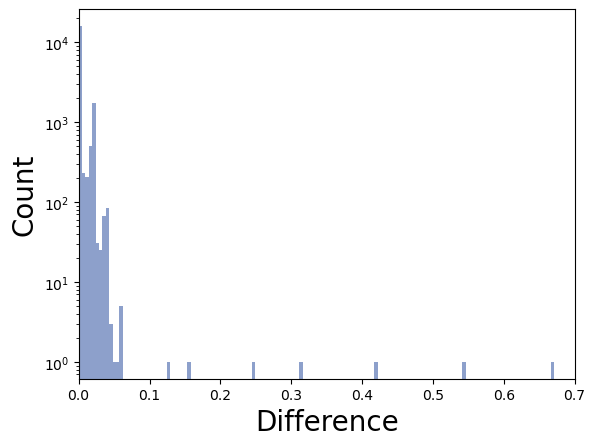

In [122]:
plt.hist(Diff, bins=140, color='#8da0cb')
plt.yscale('log')
plt.xlabel('Difference', fontsize=20)
plt.xlim(0, 0.7)
plt.ylabel('Count', fontsize=20)
plt.savefig('Convergence.pdf')

Without spatial structures, it seems that species richness would be why the stability is higher in the assembly scenario that the design scenario.

Then, if we subsample small communities from the assembly, the difference in the stability may become smaller.

In [85]:
def GetAssembly_control(T_lim=1, c_list=[0.25, 0.5,1.00], replicate=20):
    mu=0.0
    rho=0.0
    richness=list()
    stability=list()
    for i in range(len(c_list)):
        connect=c_list[i]
        os.chdir(str('./connectance%.2f' %(connect)))
        for j in range(replicate):
            os.chdir(str('./replicate%d' %(j)))
            print(str('connectance %.2f replicate %d' %(connect, j)))
            os.chdir(str('./rho%.2f_mu%.2f/assembly' %(rho, mu)))
            stab=np.loadtxt('stability_new.csv', delimiter=',')
            abundance=np.loadtxt('abundance.csv', delimiter=',')
            for t in range(T_lim, np.size(abundance,0)):
                num=sum(abundance[t, ]>0)
                if num<11 and np.any(abs(abundance[t,]-abundance[(t-1), ])>pow(10, -5)):
                    # avoid over sampling
                    # sample communities with low richness
                    richness.append(num)
                    stability.append(stab[t])
                
            os.chdir('../../')
            os.chdir('../')
        os.chdir('../')
    return pd.DataFrame({'Richness':richness, 'Stability':stability})

df_small_assemb_control=GetAssembly_control(T_lim=1, c_list=[0.25, 0.5,1.00], replicate=20)        
    

connectance 0.25 replicate 0
connectance 0.25 replicate 1
connectance 0.25 replicate 2
connectance 0.25 replicate 3
connectance 0.25 replicate 4
connectance 0.25 replicate 5
connectance 0.25 replicate 6
connectance 0.25 replicate 7
connectance 0.25 replicate 8
connectance 0.25 replicate 9
connectance 0.25 replicate 10
connectance 0.25 replicate 11
connectance 0.25 replicate 12
connectance 0.25 replicate 13
connectance 0.25 replicate 14
connectance 0.25 replicate 15
connectance 0.25 replicate 16
connectance 0.25 replicate 17
connectance 0.25 replicate 18
connectance 0.25 replicate 19
connectance 0.50 replicate 0
connectance 0.50 replicate 1
connectance 0.50 replicate 2
connectance 0.50 replicate 3
connectance 0.50 replicate 4
connectance 0.50 replicate 5
connectance 0.50 replicate 6
connectance 0.50 replicate 7
connectance 0.50 replicate 8
connectance 0.50 replicate 9
connectance 0.50 replicate 10
connectance 0.50 replicate 11
connectance 0.50 replicate 12
connectance 0.50 replicate 13


In [89]:
df_design_control=pd.read_csv('design_control.csv')
# comparison
print([np.median(df_design_control['stability']), np.median(df_small_assemb_control['Stability'])])
print(sp.stats.ranksums(df_design_control['stability'], df_small_assemb_control['Stability']))
print(cliffs_delta(df_design_control['stability'], df_small_assemb_control['Stability'])) # effect size


[0.24, 0.33999999999999997]
RanksumsResult(statistic=-4.86723994683784, pvalue=1.1316759788267819e-06)
(-0.37732350312779267, 'medium')


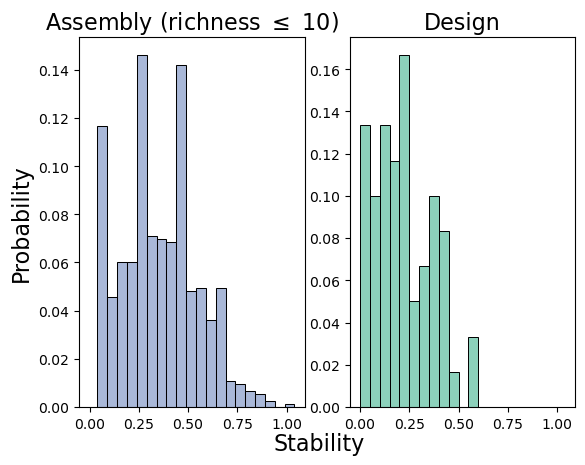

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

sns.histplot(data=df_small_assemb_control, x='Stability', stat='probability', binwidth=0.05, color='#8da0cb', ax=ax1)
sns.histplot(data=df_design_control, binwidth=0.05,  x='stability', stat='probability', color='#66c2a5', ax=ax2)


ax1.set_xlabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax1.set_ylabel('Probability', fontsize=16)
ax1.set_title('Assembly (richness $\leq$ 10)', fontsize=16)
ax2.set_title('Design', fontsize=16)
fig.supxlabel('Stability', fontsize=16)
plt.savefig('NoSpatial_Compare_Stability_Small_Richness.pdf')

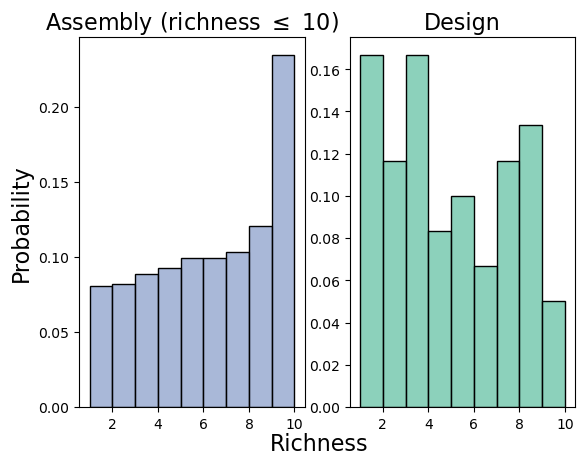

In [140]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

sns.histplot(data=df_small_assemb_control, x='Richness', stat='probability', binwidth=1, color='#8da0cb', ax=ax1)
sns.histplot(data=df_design_control, binwidth=1,  x='richness', stat='probability', color='#66c2a5', ax=ax2)


ax1.set_xlabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax1.set_ylabel('Probability', fontsize=16)
ax1.set_title('Assembly (richness $\leq$ 10)', fontsize=16)
ax2.set_title('Design', fontsize=16)
fig.supxlabel('Richness', fontsize=16)
plt.savefig('NoSpatial_Compare_Richness_Small_Richness.pdf')

In [142]:
print([np.median(df_design_control['richness']), np.median(df_small_assemb_control['Richness'])])
print(sp.stats.ranksums(df_design_control['richness'], df_small_assemb_control['Richness']))
print(cliffs_delta(df_design_control['richness'], df_small_assemb_control['Richness'])) # effect size

[4.0, 6.0]
RanksumsResult(statistic=-3.6505020076141226, pvalue=0.00026172826351546143)
(-0.2829982126899017, 'small')


We also perform similar analysis for cases with the spatial structure

In [28]:
df_assembly=pd.read_csv('assembly_data.csv')
df_assembly

stability  resistance_invasion  resistance_environment  \
0           0.040                0.040                   0.000   
1           0.040                0.040                   0.000   
2           0.120                0.120                   0.000   
3           0.160                0.160                   0.000   
4           0.280                0.280                   0.000   
...           ...                  ...                     ...   
220772      0.966                0.542                   0.424   
220773      0.966                0.542                   0.424   
220774      0.966                0.542                   0.424   
220775      0.966                0.542                   0.424   
220776      0.966                0.542                   0.424   

        total_positive_up  mean_positive_up  total_negative_up  \
0                0.000000          0.000000           0.000000   
1                0.000000          0.000000           0.000000   
2                0.000000          0.000000           0.000000   
3                0.000000          0.000000           0.000000   
4                0.000000          0.000000           0.000000   
...                   ...               ...                ...   
220772           7.331879          0.183297           6.152229   
220773           7.331879          0.183297           6.152229   
220774           7.331879          0.183297           6.152229   
220775           7.331879          0.183297           6.152229   
220776           7.331879          0.183297           6.152229   

        mean_negative_up  degree_up  total_positive_down  mean_positive_down  \
0               0.000000   0.000000             0.000000            0.000000   
1               0.000000   0.000000             0.195451            0.195451   
2               0.000000   0.000000             0.562435            0.140609   
3               0.000000   0.000000             0.317255            0.158628   
4               0.000000   0.000000             1.746185            0.249455   
...                  ...        ...                  ...                 ...   
220772          0.161901   4.588235             1.384071            0.230678   
220773          0.161901   4.588235             1.384071            0.230678   
220774          0.161901   4.588235             1.384071            0.230678   
220775          0.161901   4.588235             1.384071            0.230678   
220776          0.161901   4.588235             1.384071            0.230678   

        ...  degree_down  total_positive_trans  mean_positive_trans  \
0       ...     0.000000              0.000000             0.000000   
1       ...     1.000000              0.000000             0.000000   
2       ...     2.000000              0.000000             0.000000   
3       ...     2.000000              0.000000             0.000000   
4       ...     3.000000              0.000000             0.000000   
...     ...          ...                   ...                  ...   
220772  ...     1.428571              2.592706             0.235701   
220773  ...     1.428571              2.592706             0.235701   
220774  ...     1.428571              2.592706             0.235701   
220775  ...     1.428571              2.592706             0.235701   
220776  ...     1.428571              2.592706             0.235701   

        total_negative_trans  mean_negative_trans  degree_trans   mu  rho  \
0                   0.000000             0.000000      0.000000  0.0  0.0   
1                   0.000000             0.000000      0.000000  0.0  0.0   
2                   0.000000             0.000000      0.000000  0.0  0.0   
3                   0.000000             0.000000      0.000000  0.0  0.0   
4                   0.000000             0.000000      0.000000  0.0  0.0   
...                      ...                  ...           ...  ...  ...   
220772              8.240544             0.392407      4.571429  2.0 

In [27]:
df_assembly_sub=df_assembly[df_assembly["richness_down"]<=10 ]
df_assembly_sub

stability  resistance_invasion  resistance_environment  \
0           0.040                0.040                   0.000   
1           0.040                0.040                   0.000   
2           0.120                0.120                   0.000   
3           0.160                0.160                   0.000   
4           0.280                0.280                   0.000   
...           ...                  ...                     ...   
220772      0.966                0.542                   0.424   
220773      0.966                0.542                   0.424   
220774      0.966                0.542                   0.424   
220775      0.966                0.542                   0.424   
220776      0.966                0.542                   0.424   

        total_positive_up  mean_positive_up  total_negative_up  \
0                0.000000          0.000000           0.000000   
1                0.000000          0.000000           0.000000   
2                0.000000          0.000000           0.000000   
3                0.000000          0.000000           0.000000   
4                0.000000          0.000000           0.000000   
...                   ...               ...                ...   
220772           7.331879          0.183297           6.152229   
220773           7.331879          0.183297           6.152229   
220774           7.331879          0.183297           6.152229   
220775           7.331879          0.183297           6.152229   
220776           7.331879          0.183297           6.152229   

        mean_negative_up  degree_up  total_positive_down  mean_positive_down  \
0               0.000000   0.000000             0.000000            0.000000   
1               0.000000   0.000000             0.195451            0.195451   
2               0.000000   0.000000             0.562435            0.140609   
3               0.000000   0.000000             0.317255            0.158628   
4               0.000000   0.000000             1.746185            0.249455   
...                  ...        ...                  ...                 ...   
220772          0.161901   4.588235             1.384071            0.230678   
220773          0.161901   4.588235             1.384071            0.230678   
220774          0.161901   4.588235             1.384071            0.230678   
220775          0.161901   4.588235             1.384071            0.230678   
220776          0.161901   4.588235             1.384071            0.230678   

        ...  degree_down  total_positive_trans  mean_positive_trans  \
0       ...     0.000000              0.000000             0.000000   
1       ...     1.000000              0.000000             0.000000   
2       ...     2.000000              0.000000             0.000000   
3       ...     2.000000              0.000000             0.000000   
4       ...     3.000000              0.000000             0.000000   
...     ...          ...                   ...                  ...   
220772  ...     1.428571              2.592706             0.235701   
220773  ...     1.428571              2.592706             0.235701   
220774  ...     1.428571              2.592706             0.235701   
220775  ...     1.428571              2.592706             0.235701   
220776  ...     1.428571              2.592706             0.235701   

        total_negative_trans  mean_negative_trans  degree_trans   mu  rho  \
0                   0.000000             0.000000      0.000000  0.0  0.0   
1                   0.000000             0.000000      0.000000  0.0  0.0   
2                   0.000000             0.000000      0.000000  0.0  0.0   
3                   0.000000             0.000000      0.000000  0.0  0.0   
4                   0.000000             0.000000      0.000000  0.0  0.0   
...                      ...                  ...           ...  ...  ...   
220772              8.240544             0.392407      4.571429  2.0 

In [5]:
df_design=pd.read_csv('design_data.csv')
df_design

stability  resistance_invasion  resistance_environment  \
0          0.560                0.560                   0.000   
1          0.560                0.560                   0.000   
2          0.560                0.560                   0.000   
3          0.680                0.680                   0.000   
4          0.440                0.440                   0.000   
...          ...                  ...                     ...   
18917      0.723                0.213                   0.510   
18918      0.756                0.222                   0.534   
18919      0.829                0.244                   0.585   
18920      0.800                0.267                   0.533   
18921      0.872                0.256                   0.616   

       total_positive_up  mean_positive_up  total_negative_up  \
0               8.339342          0.198556           4.956080   
1               5.975433          0.248976           6.447756   
2               9.372051          0.195251           8.930685   
3               4.071161          0.177007           6.585145   
4               4.737168          0.263176           3.609543   
...                  ...               ...                ...   
18917           3.078632          0.192414           2.426275   
18918           1.360817          0.170102           1.459154   
18919           1.767723          0.196414           1.606252   
18920           1.487906          0.212558           2.121835   
18921           1.733882          0.247697           0.888976   

       mean_negative_up  degree_up  total_positive_down  mean_positive_down  \
0              0.165203   8.000000              6.61396            0.194528   
1              0.201492   7.000000              6.61396            0.194528   
2              0.212635   9.000000              0.00000            0.000000   
3              0.199550   7.000000              0.00000            0.000000   
4              0.150398   6.000000              0.00000            0.000000   
...                 ...        ...                  ...                 ...   
18917          0.186637   2.636364              0.00000            0.000000   
18918          0.182394   1.600000              0.00000            0.000000   
18919          0.229465   2.000000              0.00000            0.000000   
18920          0.235759   1.600000              0.00000            0.000000   
18921          0.177795   1.714286              0.00000            0.000000   

       ...  degree_down  total_positive_trans  mean_positive_trans  \
0      ...          8.0              8.465661             0.217068   
1      ...          8.0             10.741641             0.268541   
2      ...          1.0              2.515296             0.279477   
3      ...          1.0              2.252321             0.375387   
4      ...          1.0              1.801725             0.225216   
...    ...          ...                   ...                  ...   
18917  ...          0.0              0.620855             0.155214   
18918  ...          0.0              0.257820             0.128910   
18919  ...          0.0              0.145172             0.072586   
18920  ...          0.0              0.724348             0.362174   
18921  ...          0.0              0.247284             0.247284   

       total_negative_trans  mean_negative_trans  degree_trans   mu  rho  \
0                  8.192365             0.195056           9.0  0.0  0.0   
1                  7.283204             0.227600           8.0  0.0  0.0   
2                  2.800859             0.254624          10.0  0.0  0.0   
3                  2.398799             0.239880           8.0  0.0  0.0   
4                  1.055754             0.175959           7.0  0.0  0.0   
...                     ...                  ...           ...  ...  ...   
18917              0.197899             0.197899           5.0  2.0  1.0   
18918              0.000000             0.00000

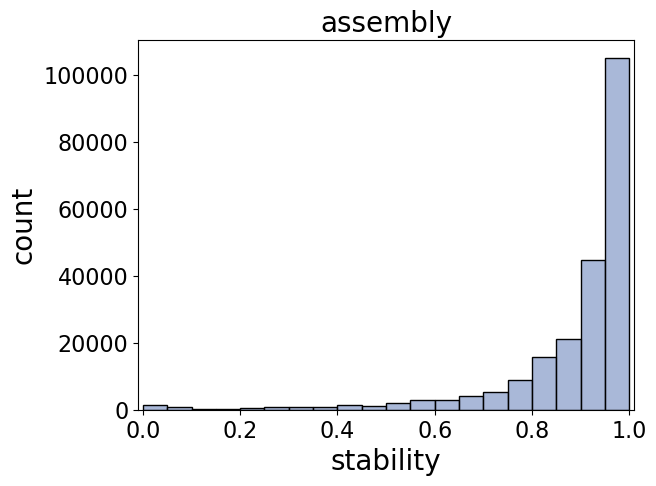

In [12]:
sns.histplot(data=df_assembly,x='stability', bins=20, color='#8da0cb')
plt.xlim(-0.01, 1.01)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('stability', fontsize=20)
plt.ylabel("count", fontsize=20)
plt.title("Assembly", fontsize=20)
#plt.savefig("stability_full_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

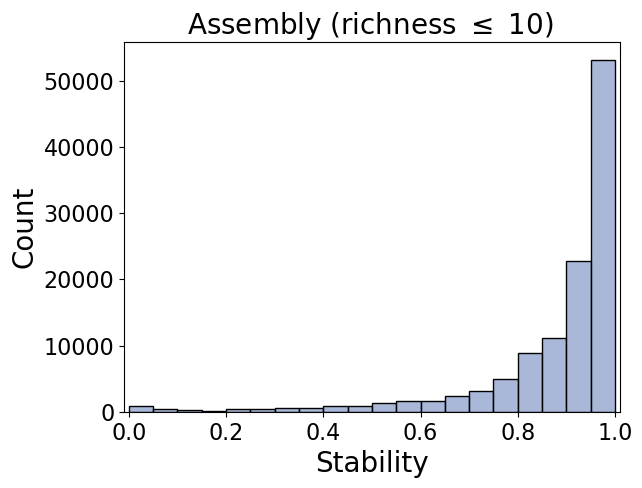

In [15]:
sns.histplot(data=df_assembly_sub,x='stability', bins=20, color='#8da0cb')
plt.xlim(-0.01, 1.01)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Stability', fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Assembly (richness $\leq$ 10) ", fontsize=20)
#plt.savefig("stability_full_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

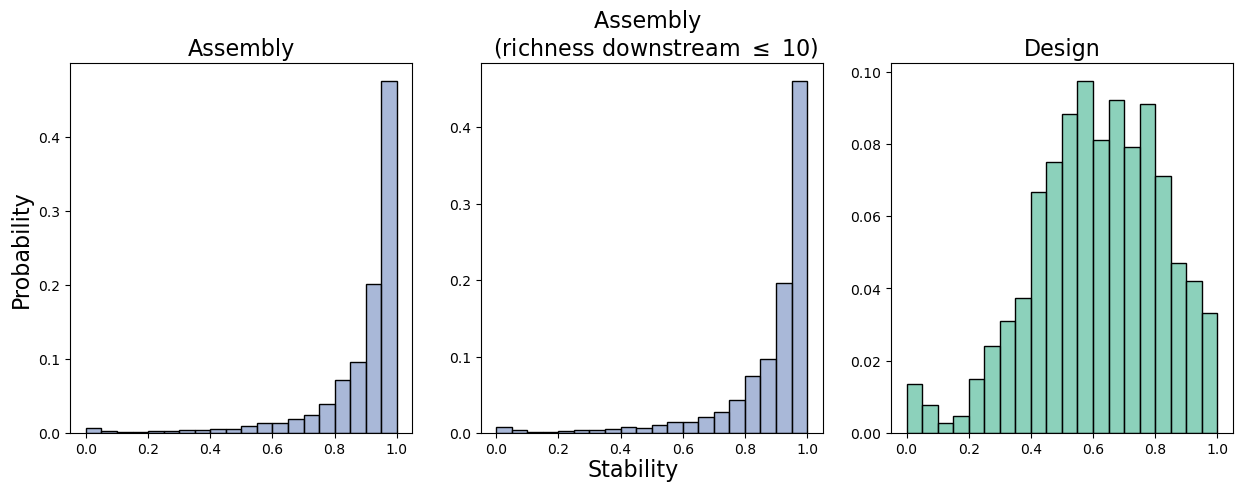

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True)
fig.set_figwidth(15)
sns.histplot(data=df_assembly, x='stability', stat='probability', binwidth=0.05, color='#8da0cb', ax=ax1)
sns.histplot(data=df_assembly_sub, x='stability', stat='probability', binwidth=0.05, color='#8da0cb', ax=ax2)
sns.histplot(data=df_design, binwidth=0.05,  x='stability', stat='probability', color='#66c2a5', ax=ax3)


ax1.set_xlabel('')
ax3.set_xlabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.set_ylabel('Probability', fontsize=16)
ax1.set_title('Assembly', fontsize=16)
ax2.set_title('Assembly \n (richness downstream $\leq$ 10)', fontsize=16)
ax3.set_title('Design', fontsize=16)
fig.supxlabel('Stability', fontsize=16)
plt.savefig('With_Spatial_Compare_Stability_Small_Richness.pdf')

In [2]:
sp.__version__

'1.10.0'

In [ ]:
# generating datafarame to perform statistical analysis

def composition_convert(abundance):
    return abundance>0.00001


def ListToDF(L):
    # converting 2dim array to the following dataframe
    return pd.DataFrame({'stability':L[0], 'index':L[1], 
                            'total_positive_up':L[2], 'total_negative_up':L[3], 'mean_positive_up':L[4], 'mean_negative_up': L[5], 'degree_up':L[6], 
                            'total_positive_down':L[7], 'total_negative_down':L[8], 'mean_positive_down':L[9], 'mean_negative_down': L[10], 'degree_down':L[11],
                            'total_positive_trans':L[12], 'total_negative_trans':L[13], 'mean_positive_trans':L[14], 'mean_negative_trans': L[15], 'degree_trans':L[16]})

def Analysis(List, A, r_up, r_down, index, scenario):
    """
    analze structural stabiliy given community parameters
    scenario ==0 => assembly otherwise designing
    """
    stability=[]
    indeces=[]
    total_positive_up=[]
    total_negative_up=[]
    mean_positive_up=[]
    mean_negative_up=[]
    degree_up=[]
    total_positive_down=[]
    total_negative_down=[]
    mean_positive_down=[]
    mean_negative_down=[]
    degree_down=[]
    total_positive_trans=[]
    total_negative_trans=[]
    mean_positive_trans=[]
    mean_negative_trans=[]
    degree_trans=[]
    feature=[stability, indeces, 
            total_positive_up, total_negative_up, mean_positive_up, mean_negative_up, degree_up,
            total_positive_down, total_negative_down, mean_positive_down, mean_negative_down, degree_down,
            total_positive_trans, total_negative_trans, mean_positive_trans, mean_negative_trans, degree_trans
            ]
    
    if scenario==0:
        os.chdir('./assembly')
        abundance=np.loadtxt('abundance.csv', delimiter=',', skiprows=0)
        stability=np.loadtxt('stability_new.csv', delimiter=',', skiprows=0)
        N=np.size(r_up)
    else:
        os.chdir('./designing2')
        stability=np.loadtxt('stability_new.csv', delimiter=',', skiprows=0)
        down_abundance=np.loadtxt('target_down.csv', delimiter=',', skiprows=0)
        up_abundance=np.loadtxt('upstream_community.csv', delimiter=',', skiprows=0)
    for t in range(len(stability)):
        if scenario==0:
            #assembly
            if t==0:
                abundance_prev=np.zeros([2*N])
            else:
                abundance_prev=abundance[t-1, :]
            if np.all(abundance[t, :] == abundance_prev) == False:
                # we only analyze the cases where species abundances change from the previous time step
                feature=Network(feature,  stability[t], A, abundance[t, :N], abundance[t, N:], index)
        else:
            # dsigning
            if np.isnan(stability[t])==False:
                # we only consider the case when the  target downstream community is maintained.
                feature=Network(feature,  stability[t], A, up_abundance[t, :], down_abundance, index)
    os.chdir('../')
    if List==[]:
        return feature
    else:
        for i in range(len(List)):
            List[i].extend(feature[i])
        return List
            
def Network(List, stability, interaction,  up_abundance, down_abundance, index):
    # analyzing species interaction network given community compositions
    up_composition=composition_convert(up_abundance)
    down_composition=composition_convert(down_abundance)
    num=np.size(up_composition)
    
    positive_up=[]# positive interaction among upstream
    negative_up=[]# newgative interaction among upstream
    positive_down=[]# positive interaction among downstream
    negative_down=[]# newgative interaction among downstream
    positive_trans=[]# positive interaction from upstream to downstrea
    negative_trans=[]# newgative interaction from upstream to downstrea
    degree_up=[] # degreee within upstream
    degree_down=[] # degree within donwstream
    degree_trans=[] # degree between streams
    
    for i in range(num):
        # i is recever
        degree_up_count=0
        degree_down_count=0
        degree_trans_count=0
        for j in range(num):
            # upstream
            if i !=j and up_composition[i]==1 and up_composition[j]==1:
                #i and j should be different species and they should exist
                if interaction[i, j]>0:
                    positive_up.append(interaction[i, j])
                    degree_up_count+=1
                elif interaction[i, j]<0:
                    #note that we need to ignore no interactio
                    negative_up.append(- interaction[i, j])  # note that we get the sum of strength of negative interaction
                    degree_up_count+=1
            #downsteram
            if i!=j and down_composition[i]==1 and down_composition[j]==1:
                if interaction[i, j]>0:
                    positive_down.append(interaction[i, j])
                    degree_down_count+=1
                elif interaction[i,j]<0:
                    negative_down.append(- interaction[i, j] )
                    degree_down_count+=1
            # from up to down
            if up_composition[j]==1 and down_composition[i]==1:
                if interaction[i, j]>0:
                    positive_trans.append(interaction[i, j])
                    degree_trans_count+=1
                elif interaction[i,j]<0:
                    negative_trans.append(- interaction[i, j] )
                    degree_trans_count+=1
        # degree
        if up_composition[i]==1:
            degree_up.append(degree_up_count)
        if down_composition[i]==1:
            degree_down.append(degree_down_count)
            degree_trans.append(degree_trans_count)
    # ---------------------adding to List---------------
    List[0].append(stability)
    List[1].append(index)
    List[2].append(np.sum(positive_up))
    List[3].append(np.sum(negative_up))
    List[4].append(np.mean(positive_up))
    List[5].append(np.mean(negative_up))
    List[6].append(np.mean(degree_up))
    List[7].append(np.sum(positive_down))
    List[8].append(np.sum(negative_down))
    List[9].append(np.mean(positive_down))
    List[10].append(np.mean(negative_down))
    List[11].append(np.mean(degree_down))
    List[12].append(np.sum(positive_trans))
    List[13].append(np.sum(negative_trans))
    List[14].append(np.mean(positive_trans))
    List[15].append(np.mean(negative_trans))
    List[16].append(np.mean(degree_trans))
    
    return List
            
    
    

def DataFrameGenerator(c_list, rho, mu, replicate=20):
    """
    generating dataframe containing structural stbaility and 15 features
    c_list: list of connectance in interaction network
    mu, rho: parameter of migration
    """
    assembly=[] # 2dim list
    design=[] #2dim list
    for c in range(len(c_list)):
        connect=c_list[c]
        path=str('./connectance%.2f' %(connect))
        os.chdir(path)
        for i in range(replicate):
            path=str('./replicate%d/rho%.2f_mu%.2f' %(i, rho, mu))
            os.chdir(path)
            A=np.loadtxt('../interaction.csv', delimiter=',', skiprows=0)
            r_up=np.loadtxt('../growthrate_up.csv', delimiter=',', skiprows=0)
            r_down=np.loadtxt('../growthrate_down.csv', delimiter=',', skiprows=0)
            assembly=Analysis(assembly, A, r_up, r_down, i+c*replicate, 0)
            #design=Analysis(design, A, r_up, r_down, i+c*replicate, 1)
            os.chdir('../../')
        os.chdir('../')
    df_assembly=ListToDF(assembly).fillna(0)
    #df_design=ListToDF(design)
    #return [df_assembly, df_design]
    return df_assembly

In [ ]:
def Contribution(candidate):
    for i in range(np.size(candidate, 0)):
        coef_new=candidate.iloc[i, 2].params
        if i== 0:
            coef=coef_new
        else:
            coef=pd.concat([coef, coef_new], axis=1)
    if len(candidate.index)==1:
        # in case we have only one model
         return abs(coef.replace(np.nan, 0))
    else:    
        return abs(coef.replace(np.nan, 0)).mean(axis=1) 

def HeatMap(df, rho_list, mu_list, index_list, tail):
    """
    For drawing heatmap to show the contribution of each index over rho and mu
    We need to fill missing data
    """
    for l in range(len(index_list)):
        HD=np.zeros([len(rho_list), len(mu_list)])
        index=index_list[l]
        for i in range(len(rho_list)):
            rho=rho_list[i]
            for j in range(len(mu_list)):
                mu=mu_list[j]
                condition=str("index=='%s' and rho==%.2f and mu==%.2f" %(index, rho, mu))
                sample=df.query(condition)
                if len(sample) >0:
                    # if the length of sample. we are missing contribution given rho and mu
                    HD[i,j]=sample.iloc[0, 1]
        ax = sns.heatmap(HD, vmin=0.0, vmax=0.3, cmap="gray_r")
        plt.xlabel(r'$\mu$', fontsize=20)
        plt.xticks(ticks=np.array(list(range(len(mu_list))))+0.5, labels=mu_list, fontsize=14)
        plt.ylabel(r'$\rho$', fontsize=20)
        plt.yticks(ticks=np.array(list(range(len(rho_list))))+0.5, labels=rho_list, fontsize=14)
        plt.title(index, fontsize=20)
        plt.savefig('heatmap_'+index+'_'+tail+'.pdf', pad_inches=0.1, bbox_inches='tight')
        plt.show()
        
def FeatureSelection_Logistic(df):
    """
    df: pandas dataframe, each row represents data, and the first column is target while the rest columns are features
    return the importance of each feature based on the coefficients of them in the best models (Delta AIC<2 and max VIF<10)
    """
    def VIF_check(feature):
        vif = pd.DataFrame()
        vif["VIF Factor"] = [variance_inflation_factor(feature.values, i) for i in range(feature.shape[1])]
       # if max VIF is smaller than 10, we can continue the analysis
        return max(vif.iloc[:, 0])<10
            
    y=df.iloc[:, 0] # target
    X=df.iloc[:, 1:] # features
    sscaler = preprocessing.StandardScaler()
    Xss= sscaler.fit(X).transform(X) # standarized
    Xss=pd.DataFrame(Xss, columns =df.columns[1:]) # adding labels
    
    #Brute force search  of all possioble models
    feature_list = Xss.columns

    def generate_formulas(descriptors, num, target, feature):
        # formulas for regression
        if num > len(descriptors):
            return None
        else:
            for f in itertools.combinations(descriptors, num):
                feature_dropped = feature[list(f)]
                if num>1:
                    if VIF_check(feature_dropped)==1:
                        # VIF are enough small to perform regression
                        formula = target.name + '  ~ ' + ' + '.join(f)
                        yield formula
                else:
                     formula = target.name + '  ~ ' + ' + '.join(f)
                     yield formula

    def modeling_logistic(formula, data):
        #logistic regression of given model
        #print(formula)
        model = smf.logit(formula=formula, data=data).fit()
        return formula, model

    n_var = []
    formula = []
    model = []
    AIC = []

    for i in range(1,len(feature_list)+1):
        for f in generate_formulas(feature_list, i, y, Xss):
            eq, m = modeling_logistic(formula=f, data=pd.concat([y, Xss], axis=1))
            n_var.append(i)
            formula.append(f)
            model.append(m)
            AIC.append(m.aic)

    df_model = pd.DataFrame({'n_var': n_var,
                            'formula': formula,
                            'model': model,
                            'aic': AIC,
                            'delta_aic': AIC-np.min(AIC)})
    return df_model


def main_assembly(c_list, rho_list, mu_list):
    """
    plotting controbution of each factor
    considering the simply saving as csv, use pandas instead of 3dim numpy array
    """
    index_list=['Intercept', 'total_positive_up', 'total_negative_up', 'mean_positive_up', 'mean_negative_up', 'degree_up',
       'total_positive_down', 'total_negative_down', 'mean_positive_down','mean_negative_down', 'degree_down', 
       'total_positive_trans', 'total_negative_trans', 'mean_positive_trans', 'mean_negative_trans', 'degree_trans']
    assembly_index=[]
    assembly_contr=[]
    assembly_rho=[]
    assembly_mu=[]
    for i in range(len(rho_list)):
        rho=rho_list[i]
        for j in range(len(mu_list)):
            mu=mu_list[j]
            print(str(r'$(\rho, \mu)$ = (%.2f, %.2f)' %(rho, mu)))
            # generate dataframes
            #df_assembly, df_design=DataFrameGenerator(c_list=c_list, rho=rho, mu=mu, replicate=20)
            df_assembly=DataFrameGenerator(c_list=c_list, rho=rho, mu=mu, replicate=20)
            df_assembly.to_csv(str('assembly_rho%.2f_mu%.2f.csv'%(rho, mu)),index=False)
            #df_design.to_csv(str('design2_rho%.2f_mu%.2f.csv' %(rho, mu)),index=False)
            #-----------------assembly-----------------
            if rho==1 and mu==0:
                print('N.A.')
                # we have no community and no invasion
                np.savetxt(fname=str('BestModels_Assembly_rho%.2f_mu%.2f.csv' %(rho, mu)),X=[])
            else:
                drop_list=['index'] # we need to drop  index
                for k in range (2, len(df_assembly.columns.values)):
                    # we also need to drop constant feature
                    if np.all(df_assembly.iloc[:, k] ==df_assembly.iloc[0, k]):
                        drop_list.append(df_assembly.columns.values[k])

                df_assembly_best=FeatureSelection_Logistic(df_assembly.drop(drop_list, axis=1)).query('delta_aic<2').sort_values('delta_aic')  #choosing best models accroding to delta_aic
                df_assembly_best.to_csv(str('BestModels_Assembly_rho%.2f_mu%.2f.csv' %(rho, mu)), index=False)
                contr_assembly=Contribution(df_assembly_best)
                # get indeces of contributors
                contr_assembly_index=contr_assembly.index.values
                # save the contributions
                for k in range(len(contr_assembly_index)):
                    assembly_index.append(contr_assembly_index[k])
                    assembly_contr.append(contr_assembly[k])
                    assembly_rho.append(rho)
                    assembly_mu.append(mu)
            """
            # -----------------design-----------------
            drop_list=['index'] # we need to drop  index
            for k in range (2, len(df_design.columns.values)):
                # we also need to drop constant feature
                if np.all(df_design.iloc[:, k] ==df_design.iloc[0, k]):
                    drop_list.append(df_design.columns.values[k])
            df_design_best=FeatureSelection_Logistic(df_design.drop(drop_list, axis=1)).query('delta_aic<2').sort_values('delta_aic')  #choosing best models accroding to delta_aic
            df_design_best.to_csv(str('BestModels_Desig2_rho%.2f_mu%.2f.csv' %(rho, mu)), index=False)
            contr_design=Contribution(df_design_best)
            # get indeces of contributors
            contr_design_index=contr_design.index.values
            # save the contributions
            for k in range(len(contr_design_index)):
                design_index.append(contr_design_index[k])
                design_contr.append(contr_design[k])
                design_rho.append(rho)
                design_mu.append(mu)
            """        
    #df_assembly_summary=pd.DataFrame({'index':assembly_index, 'contribution':assembly_contr, 'rho':assembly_rho, 'mu':assembly_mu})
    #df_assembly_summary.to_csv('assembly_contribution_summary.csv' , index=False)
    #plot heatmap over  rho and mu
    #HeatMap(df_assembly_summary, rho_list, mu_list, index_list=index_list, tail='assembly')
    
    #df_design_summary=pd.DataFrame({'index':design_index, 'contribution':design_contr, 'rho':design_rho, 'mu':design_mu})
    #df_design_summary.to_csv('design_contribution_summary.csv' , index=False)
    #plot heatmap over  rho and mu
    #HeatMap(df_design_summary, rho_list, mu_list, index_list=index_list, tail='design')
    return 0
#ans=main(c_list=[1.00], rho_list=[0.0], mu_list=[0.0, 0.25,0.5])    

In [ ]:
main_assembly(c_list=[0.25, 0.5, 1.0], rho_list=[1.0], mu_list=[2.0])

In [ ]:
# for designing data
def composition_convert(abundance):
    return abundance>0.00001


def ListToDF(L):
    # converting 2dim array to the following dataframe
    return pd.DataFrame({'stability':L[0], 'index':L[1], 
                            'total_positive_up':L[2], 'total_negative_up':L[3], 'mean_positive_up':L[4], 'mean_negative_up': L[5], 'degree_up':L[6], 
                            'total_positive_down':L[7], 'total_negative_down':L[8], 'mean_positive_down':L[9], 'mean_negative_down': L[10], 'degree_down':L[11],
                            'total_positive_trans':L[12], 'total_negative_trans':L[13], 'mean_positive_trans':L[14], 'mean_negative_trans': L[15], 'degree_trans':L[16]})

def Analysis2(List, A, r_up, r_down, index):
    """
    analze structural stabiliy given community parameters
   only for designing 2
    """
    stability=[]
    indeces=[]
    total_positive_up=[]
    total_negative_up=[]
    mean_positive_up=[]
    mean_negative_up=[]
    degree_up=[]
    total_positive_down=[]
    total_negative_down=[]
    mean_positive_down=[]
    mean_negative_down=[]
    degree_down=[]
    total_positive_trans=[]
    total_negative_trans=[]
    mean_positive_trans=[]
    mean_negative_trans=[]
    degree_trans=[]
    feature=[stability, indeces, 
            total_positive_up, total_negative_up, mean_positive_up, mean_negative_up, degree_up,
            total_positive_down, total_negative_down, mean_positive_down, mean_negative_down, degree_down,
            total_positive_trans, total_negative_trans, mean_positive_trans, mean_negative_trans, degree_trans
            ]
    os.chdir('./designing2')
    stability=np.loadtxt('stability.csv', delimiter=',', skiprows=0)
    down_abundance=np.loadtxt('target_down.csv', delimiter=',', skiprows=0)
    up_abundance=np.loadtxt('upstream_community.csv', delimiter=',', skiprows=0)
    for t in range(len(stability)):
        if np.isnan(stability[t])==False:
            # we only consider the case when the  target downstream community is maintained.
            feature=Network(feature,  stability[t], A, up_abundance[t, :], down_abundance, index)
    os.chdir('../')
    if List==[]:
        return feature
    else:
        for i in range(len(List)):
            List[i].extend(feature[i])
        return List
            
def Network(List, stability, interaction,  up_abundance, down_abundance, index):
    # analyzing species interaction network given community compositions
    up_composition=composition_convert(up_abundance)
    down_composition=composition_convert(down_abundance)
    num=np.size(up_composition)
    
    positive_up=[]# positive interaction among upstream
    negative_up=[]# newgative interaction among upstream
    positive_down=[]# positive interaction among downstream
    negative_down=[]# newgative interaction among downstream
    positive_trans=[]# positive interaction from upstream to downstrea
    negative_trans=[]# newgative interaction from upstream to downstrea
    degree_up=[] # degreee within upstream
    degree_down=[] # degree within donwstream
    degree_trans=[] # degree between streams
    
    for i in range(num):
        # i is recever
        degree_up_count=0
        degree_down_count=0
        degree_trans_count=0
        for j in range(num):
            # upstream
            if i !=j and up_composition[i]==1 and up_composition[j]==1:
                #i and j should be different species and they should exist
                if interaction[i, j]>0:
                    positive_up.append(interaction[i, j])
                    degree_up_count+=1
                elif interaction[i, j]<0:
                    #note that we need to ignore no interactio
                    negative_up.append(- interaction[i, j])  # note that we get the sum of strength of negative interaction
                    degree_up_count+=1
            #downsteram
            if i!=j and down_composition[i]==1 and down_composition[j]==1:
                if interaction[i, j]>0:
                    positive_down.append(interaction[i, j])
                    degree_down_count+=1
                elif interaction[i,j]<0:
                    negative_down.append(- interaction[i, j] )
                    degree_down_count+=1
            # from up to down
            if up_composition[j]==1 and down_composition[i]==1:
                if interaction[i, j]>0:
                    positive_trans.append(interaction[i, j])
                    degree_trans_count+=1
                elif interaction[i,j]<0:
                    negative_trans.append(- interaction[i, j] )
                    degree_trans_count+=1
        # degree
        if up_composition[i]==1:
            degree_up.append(degree_up_count)
        if down_composition[i]==1:
            degree_down.append(degree_down_count)
            degree_trans.append(degree_trans_count)
    # ---------------------adding to List---------------
    List[0].append(stability)
    List[1].append(index)
    List[2].append(np.sum(positive_up))
    List[3].append(np.sum(negative_up))
    List[4].append(np.mean(positive_up))
    List[5].append(np.mean(negative_up))
    List[6].append(np.mean(degree_up))
    List[7].append(np.sum(positive_down))
    List[8].append(np.sum(negative_down))
    List[9].append(np.mean(positive_down))
    List[10].append(np.mean(negative_down))
    List[11].append(np.mean(degree_down))
    List[12].append(np.sum(positive_trans))
    List[13].append(np.sum(negative_trans))
    List[14].append(np.mean(positive_trans))
    List[15].append(np.mean(negative_trans))
    List[16].append(np.mean(degree_trans))
    
    return List
            
    
    

def DataFrameGenerator2(c_list, rho, mu, replicate=20):
    """
    generating dataframe containing structural stbaility and 15 features
    c_list: list of connectance in interaction network
    mu, rho: parameter of migration
    """
    design=[] #2dim list
    for c in range(len(c_list)):
        connect=c_list[c]
        path=str('./connectance%.2f' %(connect))
        os.chdir(path)
        for i in range(replicate):
            path=str('./replicate%d/rho%.2f_mu%.2f' %(i, rho, mu))
            os.chdir(path)
            A=np.loadtxt('../interaction.csv', delimiter=',', skiprows=0)
            r_up=np.loadtxt('../growthrate_up.csv', delimiter=',', skiprows=0)
            r_down=np.loadtxt('../growthrate_down.csv', delimiter=',', skiprows=0)
            design=Analysis2(design, A, r_up, r_down, i+c*replicate)
            os.chdir('../../')
        os.chdir('../')
    df_design=ListToDF(design).fillna(0)
    return df_design

def Contribution(candidate):
    for i in range(np.size(candidate, 0)):
        coef_new=candidate.iloc[i, 2].params
        if i== 0:
            coef=coef_new
        else:
            coef=pd.concat([coef, coef_new], axis=1)
    if len(candidate.index)==1:
        # in case we have only one model
         return abs(coef.replace(np.nan, 0))
    else:    
        return abs(coef.replace(np.nan, 0)).mean(axis=1) 
"""
def Contribution(candidate):
    for i in range(np.size(candidate, 0)):
        coef_new=candidate.iloc[i, 2].params
        if i== 0:
            coef=coef_new
        else:
            coef=pd.concat([coef, coef_new], axis=1)
    return abs(coef.replace(np.nan, 0)).mean(axis=1) #
"""
def HeatMap(df, rho_list, mu_list, index_list, tail):
    """
    For drawing heatmap to show the contribution of each index over rho and mu
    We need to fill missing data
    """
    for l in range(len(index_list)):
        HD=np.zeros([len(rho_list), len(mu_list)])
        index=index_list[l]
        for i in range(len(rho_list)):
            rho=rho_list[i]
            for j in range(len(mu_list)):
                mu=mu_list[j]
                condition=str("index=='%s' and rho==%.2f and mu==%.2f" %(index, rho, mu))
                sample=df.query(condition)
                if len(sample) >0:
                    # if the length of sample. we are missing contribution given rho and mu
                    HD[i,j]=sample.iloc[0, 1]
        ax = sns.heatmap(HD, vmin=0.0,  vmax=0.4, cmap="gray_r")
        plt.xlabel(r'$\mu$', fontsize=20)
        plt.xticks(ticks=np.array(list(range(len(mu_list))))+0.5, labels=mu_list, fontsize=14)
        plt.ylabel(r'$\rho$', fontsize=20)
        plt.yticks(ticks=np.array(list(range(len(rho_list))))+0.5, labels=rho_list, fontsize=14)
        plt.title(index, fontsize=20)
        #plt.savefig('heatmap_'+index+'_'+tail+'.pdf', pad_inches=0.1, bbox_inches='tight')
        plt.show()
        
def FeatureSelection_Logistic(df):
    """
    df: pandas dataframe, each row represents data, and the first column is target while the rest columns are features
    return the importance of each feature based on the coefficients of them in the best models (Delta AIC<2 and max VIF<10)
    """
    def VIF_check(feature):
        vif = pd.DataFrame()
        vif["VIF Factor"] = [variance_inflation_factor(feature.values, i) for i in range(feature.shape[1])]
       # if max VIF is smaller than 10, we can continue the analysis
        return max(vif.iloc[:, 0])<10
            
    y=df.iloc[:, 0] # target
    X=df.iloc[:, 1:] # features
    sscaler = preprocessing.StandardScaler()
    Xss= sscaler.fit(X).transform(X) # standarized
    Xss=pd.DataFrame(Xss, columns =df.columns[1:]) # adding labels
    
    #Brute force search  of all possioble models
    feature_list = Xss.columns

    def generate_formulas(descriptors, num, target, feature):
        # formulas for regression
        if num > len(descriptors):
            return None
        else:
            for f in itertools.combinations(descriptors, num):
                feature_dropped = feature[list(f)]
                if num>1:
                    if VIF_check(feature_dropped)==1:
                        # VIF are enough small to perform regression
                        formula = target.name + '  ~ ' + ' + '.join(f)
                        yield formula
                else:
                     formula = target.name + '  ~ ' + ' + '.join(f)
                     yield formula

    def modeling_logistic(formula, data):
         #logistic regression of given model
        model = smf.logit(formula=formula, data=data).fit()
        return formula, model

    n_var = []
    formula = []
    model = []
    AIC = []

    for i in range(1,len(feature_list)+1):
        for f in generate_formulas(feature_list, i, y, Xss):
            eq, m = modeling_logistic(formula=f, data=pd.concat([y, Xss], axis=1))
            n_var.append(i)
            formula.append(f)
            model.append(m)
            AIC.append(m.aic)

    df_model = pd.DataFrame({'n_var': n_var,
                            'formula': formula,
                            'model': model,
                            'aic': AIC,
                            'delta_aic': AIC-np.min(AIC)})
    return df_model


def main_design(c_list, rho_list, mu_list):
    """
    plotting controbution of each factor
    analyzing design2
    """
    index_list=['Intercept', 'total_positive_up', 'total_negative_up', 'mean_positive_up', 'mean_negative_up', 'degree_up',
       'total_positive_down', 'total_negative_down', 'mean_positive_down','mean_negative_down', 'degree_down', 
       'total_positive_trans', 'total_negative_trans', 'mean_positive_trans', 'mean_negative_trans', 'degree_trans']
    design_index=[]
    design_contr=[]
    design_rho=[]
    design_mu=[]
    for i in range(len(rho_list)):
        rho=rho_list[i]
        for j in range(len(mu_list)):
            mu=mu_list[j]
    
            df_design=DataFrameGenerator2(c_list=c_list, rho=rho, mu=mu, replicate=20)
            #fname=str('design2_rho%.2f_mu%.2f.csv' %(rho, mu))
            #df_design=pd.read_csv(fname).fillna(0)
            # -----------------design-----------------
            if np.all(df_design.iloc[:, 0] ==df_design.iloc[0, 0])==False:
                drop_list=['index'] # we need to drop  index
                for k in range (2, len(df_design.columns.values)):
                    # we also need to drop constant feature
                    if np.all(df_design.iloc[:, k] ==df_design.iloc[0, k]):
                        drop_list.append(df_design.columns.values[k])
                df_design_best=FeatureSelection_Logistic(df_design.drop(drop_list, axis=1)).query('delta_aic<2').sort_values('delta_aic')  #choosing best models accroding to delta_aic
                df_design_best.to_csv(str('BestModels_Design_rho%.2f_mu%.2f.csv' %(rho, mu)))
                """
                contr_design=Contribution(df_design_best)
                # get indeces of contributors
                contr_design_index=contr_design.index.values
                # save the contributions
                for k in range(len(contr_design_index)):
                    design_index.append(contr_design_index[k])
                    design_contr.append(contr_design[k])
                    design_rho.append(rho)
                    design_mu.append(mu)
                """
    
    
    #df_design_summary=pd.DataFrame({'index':design_index, 'contribution':design_contr, 'rho':design_rho, 'mu':design_mu})
    #df_design_summary.to_csv('design2_contribution_summary.csv' , index=False)
    #plot heatmap over  rho and mu
    #HeatMap(df_design_summary, rho_list, mu_list, index_list=index_list, tail='design2')
    return 0

In [ ]:
main_design(c_list=[0.25, 0.5, 1.0], rho_list=[ 0.0, 0.25, 0.5, 0.75, 1.0], mu_list=[0.0, 0.25, 0.5, 1.0, 2.0])

 # Vizullization of data, Feb 28, 2022
 ## Analyzing assembly scenario

In [57]:
def composition_convert(abundance):
    return abundance>0.00001
def Longevity(c_list, rho_list, mu_list, replicate=20):
    stability_assembly=[]
    longevity=[]
    rel_longevity=[]
    time_list=[]
    conn_list=[]
    rho_samp=[]
    mu_samp=[]
    rep_list=[]
    for i in range(len(c_list)):
        connect=c_list[i]
        path=str('./connectance%.2f' %(connect))
        os.chdir(path)
        for j in range(replicate):
            for k in range(len(rho_list)):
                rho=rho_list[k]
                for l in range(len(mu_list)):
                    mu=mu_list[l]
                    path=str('./replicate%d/rho%.2f_mu%.2f' %(j, rho, mu))
                    os.chdir(path)
                    # get stability in assembly scenario
                    os.chdir('./assembly')
                    abundance=np.loadtxt('abundance.csv', delimiter=',', skiprows=0)
                    stability=np.loadtxt('stability_new.csv', delimiter=',', skiprows=0)
                    #invasion=np.loadtxt('invasion.csv', delimiter=',', skiprows=0)
                    N=25
                    count=0
                    D=len(stability)
                    for t in range(len(stability)):
                        #assembly
                        if t==0:
                            stability_assembly.append(stability[t]) # initial stability of new composition
                            time_list.append(t)
                            count=0
                        else:
                            composition_prev=composition_convert(abundance[t-1, N:])
                            if np.all(composition_convert(abundance[t, N:]) == composition_prev):
                            # composition downstream does not change
                                 count+=1
                            else:
                                # composition changed
                                longevity.append(count)  # add longevity
                                rel_longevity.append(count/D)
                                time_list.append(t)
                                conn_list.append(connect)
                                rho_samp.append(rho)
                                mu_samp.append(mu)
                                rep_list.append(j)
                                stability_assembly.append(stability[t]) # initial stability of new composition
                                count=0
                                D=len(stability[t:])
                    longevity.append(count)    
                    rel_longevity.append(count/D)
                    conn_list.append(connect)
                    rho_samp.append(rho)
                    mu_samp.append(mu)
                    rep_list.append(j)
                    os.chdir('../')
                    os.chdir('../../')
        os.chdir('../')
    df_assembly=pd.DataFrame({'stability':stability_assembly, "longevity":longevity, 'rel_longevity':rel_longevity,
                             'connectance':conn_list, 'replicate':rep_list, 'rho':rho_samp, 'mu':mu_samp, 'init_time':time_list})
    
    return df_assembly
df= Longevity(c_list=[1.00, 0.5, 0.25], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], mu_list=[0.0, 0.25, 0.5, 1.0, 2.0], replicate=20)
df.to_csv('longevity.csv', index=False)

In [4]:
df=pd.read_csv('longevity.csv')
from scipy.optimize import curve_fit
def Exp(x, a, b, c):
    return a * np.exp(-b * x)+c
#curve_fit(func, xdata, y)
#0<a<250, -20<b,<10 -1<c<1
popt_exp, pcov_exp=curve_fit(Exp, df.iloc[:, 0].to_numpy(), df.iloc[:, 1].to_numpy(), 
                             p0=[1,-0.2,0], bounds=([0,-5, 0], [250, 5, 1]))

In [5]:
df=pd.read_csv('longevity.csv')
df_new=df
df_new['longevity']+=1
df_new

stability  longevity  rel_longevity  connectance  replicate  rho   mu  \
0          0.000          1       0.000000         1.00          0  0.0  0.0   
1          0.040          1       0.000000         1.00          0  0.0  0.0   
2          0.040          1       0.000000         1.00          0  0.0  0.0   
3          0.120          1       0.000000         1.00          0  0.0  0.0   
4          0.160          1       0.000000         1.00          0  0.0  0.0   
...          ...        ...            ...          ...        ...  ...  ...   
37994      0.983         17       0.144144         0.25         19  1.0  2.0   
37995      0.951          8       0.074468         0.25         19  1.0  2.0   
37996      0.984         72       0.825581         0.25         19  1.0  2.0   
37997      0.034          1       0.000000         0.25         19  1.0  2.0   
37998      0.966         13       0.923077         0.25         19  1.0  2.0   

       init_time  
0              0  
1              1  
2              2  
3              3  
4              4  
...          ...  
37994        140  
37995        157  
37996        165  
37997        237  
37998        238  

[37999 rows x 8 columns]

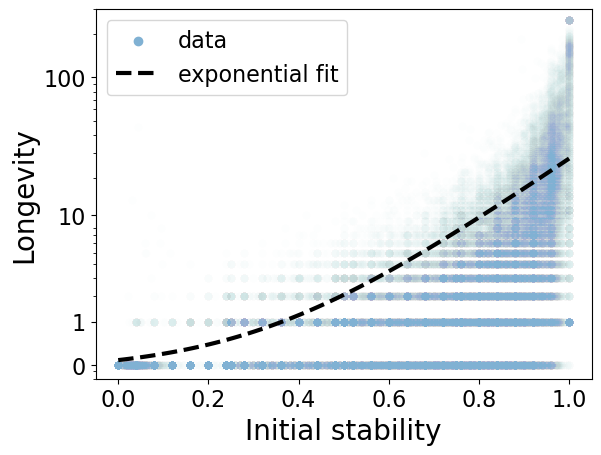

[ 1.78094528e-01 -5.00000000e+00  5.41198273e-16]


In [6]:
# do some trick to show zero data in log scale
ax=sns.scatterplot(data=df_new, x='stability', y='longevity',  alpha=0.01, color='#80b1d3')
plt.scatter([], [], label='data', color='#80b1d3')
x=np.linspace(0.0, 1.0, 80)
ax.set(yscale="log") # to show dots
#plt.plot(x, Logistic(x, *popt_log), 'k--', label='logistic')
plt.plot(x, Exp(x, *popt_exp)+0.9, 'k--', linewidth=3, label='exponential fit')
plt.xlabel('Initial stability', fontsize=20)
plt.ylabel("Longevity", fontsize=20)
plt.legend(loc='upper left', fontsize=16)
plt.ylim(0.8, 300)
plt.xlim(-0.05, 1.05)
plt.xticks(fontsize=16)
plt.yticks([1,2, 11, 101],['0', '1', '10', '100'], fontsize=16)
plt.gca().set_rasterized(True)
plt.savefig("stability_longevity_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
print(popt_exp)

In [2]:
#combining all dataset
def FullData(c_list, rho_list, mu_list, replicate=20):
    stability_design=[]
    mu_design=[]
    rho_design=[]
    connectance_design=[]
    invasion_design=[]
    stability_assembly=[]
    mu_assembly=[]
    rho_assembly=[]
    connectance_assembly=[]
    invasion_assembly=[]
    for i in range(len(c_list)):
        connect=c_list[i]
        path=str('./connectance%.2f' %(connect))
        os.chdir(path)
        for j in range(replicate):
            for k in range(len(rho_list)):
                rho=rho_list[k]
                for l in range(len(mu_list)):
                    mu=mu_list[l]
                    path=str('./replicate%d/rho%.2f_mu%.2f' %(i, rho, mu))
                    os.chdir(path)
                    # get stability in assembly scenario
                    os.chdir('./assembly')
                    abundance=np.loadtxt('abundance.csv', delimiter=',', skiprows=0)
                    stability=np.loadtxt('stability_new.csv', delimiter=',', skiprows=0)
                    invasion=np.loadtxt('invasion_stability.csv', delimiter=',', skiprows=0)
                    N=25
                    for t in range(len(stability)):
                        #assembly
                        if t==0:
                            abundance_prev=-np.ones([2*N])
                        else:
                            abundance_prev=abundance[t-1, :]
                        if np.all(abundance[t, :] == abundance_prev) == False:
                            # we only analyze the cases where species abundances change from the previous time step; otherwise, we omay ver sample stabiliy=1
                            stability_assembly.append(stability[t])
                            invasion_assembly.append(invasion[t])
                            mu_assembly.append(mu)
                            rho_assembly.append(rho)
                            connectance_assembly.append(connect)
                    os.chdir('../')
                    #get stability in designing
                    os.chdir('./designing2')
                    stability=np.loadtxt('stability_new.csv', delimiter=',', skiprows=0)
                    invasion=np.loadtxt('invasion_stability_new.csv', delimiter=',', skiprows=0)
                    for t in range(len(stability)):
                        if np.isnan(stability[t])==False:
                            # we remove nan data
                            stability_design.append(stability[t])
                            invasion_design.append(invasion[t])
                            mu_design.append(mu)
                            rho_design.append(rho)
                            connectance_design.append(connect)
                    os.chdir('../')
                    os.chdir('../../')
        os.chdir('../')
    df_assembly=pd.DataFrame({'full_stability':stability_assembly, 'invasion_stability':invasion_assembly,
                              "rho":rho_assembly, "mu":mu_assembly, 'connectance':connectance_assembly})
    df_design=pd.DataFrame({'full_stability':stability_design, 'invasion_stability':invasion_design,
                            "rho":rho_design, "mu":mu_design, 'connectance':connectance_design})
    return[df_assembly, df_design]
df_assembly, df_design= FullData(c_list=[1.00, 0.5, 0.25], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], mu_list=[0.0, 0.25, 0.5, 1.0, 2.0], replicate=20)

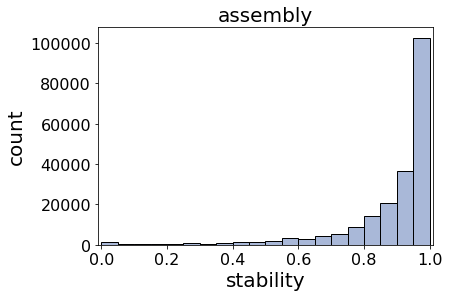

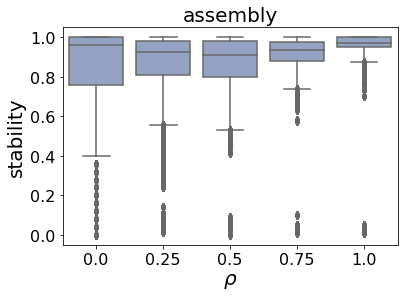

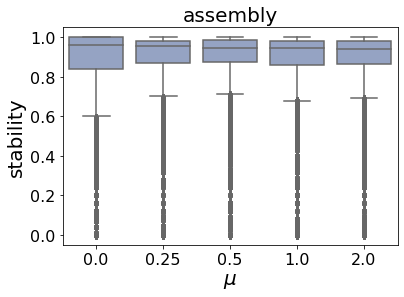

In [83]:
# full
sns.histplot(data=df_assembly,x='full_stability', bins=20, color='#8da0cb')
plt.xlim(-0.01, 1.01)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('stability', fontsize=20)
plt.ylabel("count", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("stability_full_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

# stability against rho, or mu
#sns.stripplot(data=df_assembly,x='rho',y='stability', alpha=0.025, color='#80b1d3')
sns.boxplot(data=df_assembly,x='rho',y='full_stability', color='#8da0cb')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('stability', fontsize=20)
plt.xlabel(r"$\rho$", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("stability_rho_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

#sns.stripplot(data=df_assembly,x='mu',y='stability', alpha=0.025, color='#80b1d3')
sns.boxplot(data=df_assembly,x='mu',y='full_stability', color='#8da0cb')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('stability', fontsize=20)
plt.xlabel(r"$\mu$", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("stability_mu_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

In [14]:
#stat analysis design vs assembly

U, p=sp.stats.ranksums(df_assembly['full_stability'], df_design['full_stability'], alternative='greater')
print([U,p])
print([df_assembly['full_stability'].median(), df_design['full_stability'].median()])
print([len(df_assembly['full_stability']), len(df_design['full_stability'])])

[161.8876861562012, 0.0]
[0.949, 0.6915]
[209260, 16160]


In [23]:
# contorl vs all migration 
print([np.median(df_design_control['stability']), np.median(df_design.query("mu==0").query('rho==1')['stability'])])
U, p=sp.stats.ranksums(df_design.query("mu==0").query('rho==1')['stability'], df_design_control['stability'], 'greater')
print([U,p])
d, res = cliffs_delta(df_design.query("mu==0").query('rho==1')['stability'], df_design_control['stability'])

print(d,res)

[0.24, 0.96]
[10.598785006062094, 1.5093825066459152e-26]
0.821280353200883 large


[0.670687094006015, 0.0]


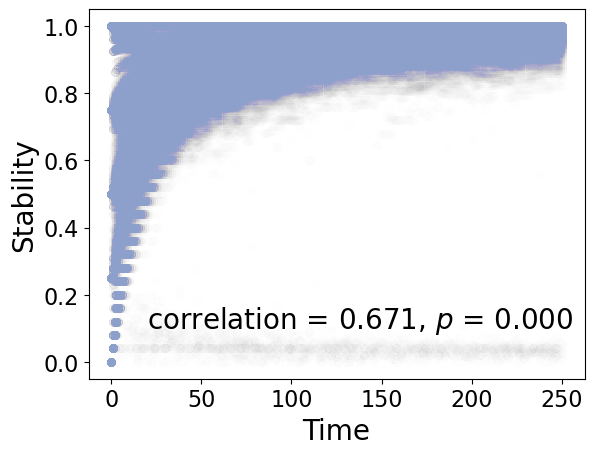

In [55]:
# assembly: time vs stability
def main(c_list=[1.00, 0.5, 0.25], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], mu_list=[0.0, 0.25, 0.5, 1.0, 2.0], replicate=20):
    stability=[]
    time=[]
    for i in range(len(c_list)):
        connect=c_list[i]
        for j in range(replicate):
            os.chdir(str('./connectance%.2f/replicate%d'%(connect, j)))
            for k in range(len(rho_list)):
                rho=rho_list[k]
                for l in range(len(mu_list)):
                    mu=mu_list[l]
                    os.chdir(str('./rho%.2f_mu%.2f/assembly' %(rho, mu)))
                    stab=np.loadtxt('stability_new.csv', delimiter=',').tolist()
                    stability.extend(stab)
                    time.extend(np.linspace(0,len(stab)-1, len(stab)).tolist())
                    os.chdir('../../')
            os.chdir('../../')
    return pd.DataFrame({'stability':stability, 'time':time})
df=main()
plt.scatter(df['time'], df['stability'], color='#8da0cb',alpha=0.005)
rho, p=sp.stats.spearmanr(df['time'], df['stability'])
print([rho, p])
plt.xlabel('Time', fontsize=20)
plt.ylabel('Stability', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.text(x=20, y=0.1, s=str(r'correlation = %.3f, $p$ = %.3f' %(rho, p)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Assembly_StabilityTime.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

In [ ]:
#plot richness over time in the assembly

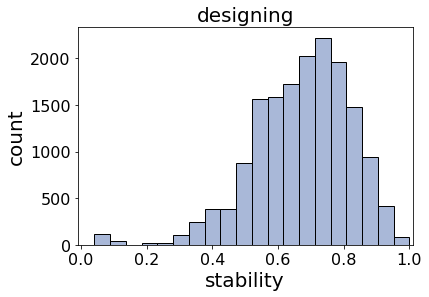

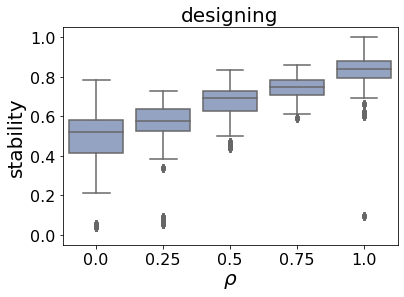

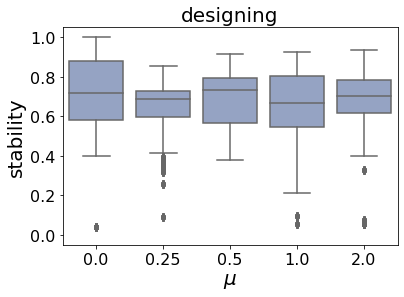

In [85]:
sns.histplot(data=df_design,x='full_stability', bins=20, color='#8da0cb')
plt.xlim(-0.01, 1.01)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('stability', fontsize=20)
plt.ylabel("count", fontsize=20)
plt.title("designing", fontsize=20)
plt.savefig("stability_full_design.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
# stability against rho, or mu
#sns.stripplot(data=df_design,x='rho',y='stability', alpha=0.03, color='#80b1d3')
sns.boxplot(data=df_design,x='rho',y='full_stability', color='#8da0cb')
plt.ylim(-0.05, 1.05)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('stability', fontsize=20)
plt.xlabel(r"$\rho$", fontsize=20)
plt.title("designing", fontsize=20)
plt.savefig("stability_rho_design.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

#sns.stripplot(data=df_design,x='mu',y='stability', alpha=0.03, color='#80b1d3')
sns.boxplot(data=df_design,x='mu',y='full_stability', color='#8da0cb')
plt.ylim(-0.05, 1.05)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('stability', fontsize=20)
plt.xlabel(r"$\mu$", fontsize=20)
plt.title("designing", fontsize=20)
plt.savefig("stability_mu_design.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

In [116]:
os.chdir('../../../../')
os.getcwd()

'/Users/shota/Desktop/SpatialCommunityAssembly/CommunityAssambly_SpatialNetwork/RandomComm/StructuralStability/Conditional/data'

0
1
2


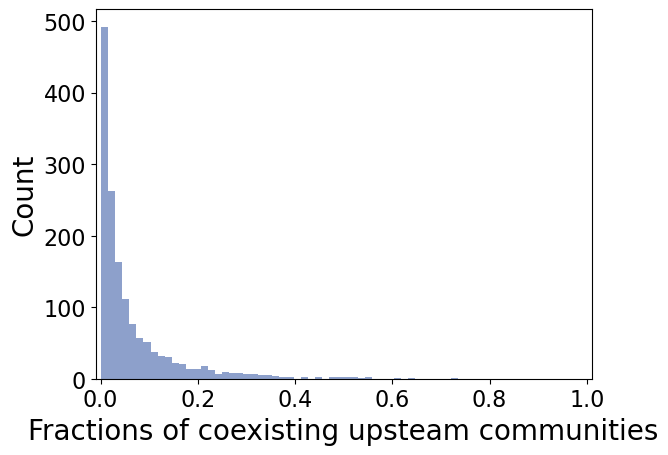

In [56]:
def main (c_list=[1.0, 0.5, 0.25], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], mu_list=[0, 0.25, 0.5, 1.0, 2.0], replicate=20):
    count=[]
    for i in range(len(c_list)):
        connect=c_list[i]
        print(i)
        for j in range(replicate):
            #print(j)
            for k in range(len(rho_list)):
                rho=rho_list[k]
                for l in range(len(rho_list)):
                    mu=mu_list[l]
                    # we should not consider the case where the downstream is empy
                    os.chdir(str('./connectance%.2f/replicate%d/rho%.2f_mu%.2f/designing2' %(connect, j, rho, mu)))
                    stability=np.loadtxt('stability_new.csv', delimiter=',')
                    count.append(np.sum(np.isnan(stability)==False)/len(stability))
                    os.chdir('../../../../')
    return count
count=main()
plt.hist(count, bins=50, color='#8da0cb')
plt.xlim(-0.01, 1.01)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Fractions of coexisting upsteam communities', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.savefig("Designing_SuccessfulSampling.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

In [130]:
len(count)

1500

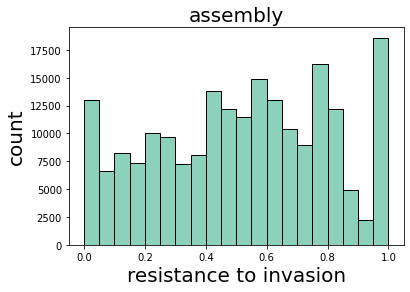

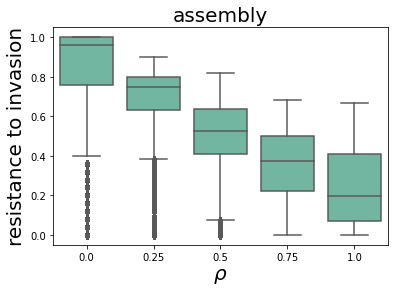

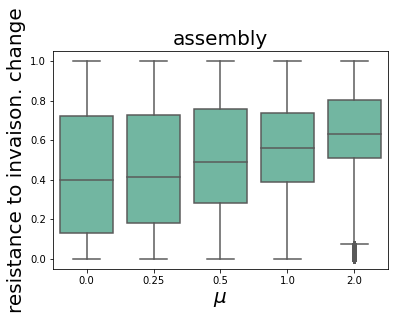

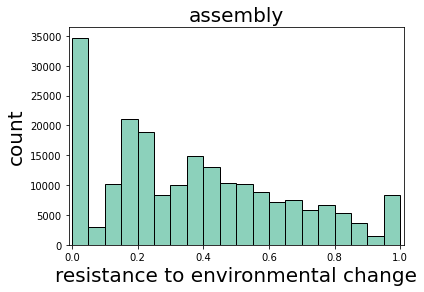

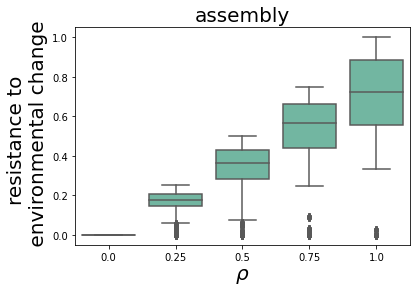

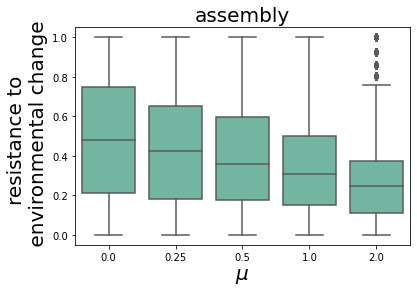

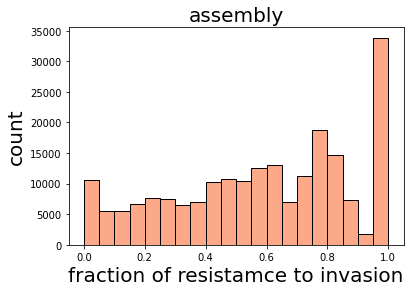

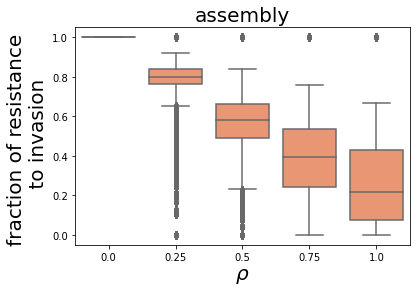

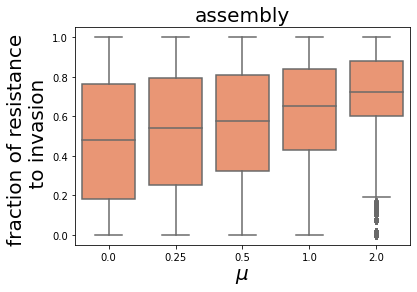

In [37]:
df_assembly['env_stability']=df_assembly['full_stability']-df_assembly['invasion_stability']
df_assembly['fraction']=df_assembly['invasion_stability']/df_assembly['full_stability'].fillna(0)
#resistance to invasion
sns.histplot(data=df_assembly,x='invasion_stability', bins=20, color='#66c2a5')
#plt.xlim(-0.01, 1.01)
plt.xlabel('resistance to invasion', fontsize=20)
plt.ylabel("count", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("ResistInvasion_full_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
sns.boxplot(data=df_assembly,x='rho',y='invasion_stability', color='#66c2a5')
plt.ylabel('resistance to invasion', fontsize=20)
plt.xlabel(r"$\rho$", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("ResistInvasion_rho_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
#sns.stripplot(data=df_assembly,x='mu',y='stability', alpha=0.025, color='#80b1d3')
sns.boxplot(data=df_assembly,x='mu',y='invasion_stability', color='#66c2a5')
plt.ylabel('resistance to invaison. change', fontsize=20)
plt.xlabel(r"$\mu$", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("ResistInvasion_mu_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

#resistance to env
sns.histplot(data=df_assembly,x='env_stability', bins=20, color='#66c2a5')
plt.xlim(-0.01, 1.01)
plt.xlabel('resistance to environmental change', fontsize=20)
plt.ylabel("count", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("ResistEnvChange_full_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
sns.boxplot(data=df_assembly,x='rho',y='env_stability', color='#66c2a5')
plt.ylabel('resistance to \n environmental change', fontsize=20)
plt.xlabel(r"$\rho$", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("ResistEnvChange_rho_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
sns.boxplot(data=df_assembly,x='mu',y='env_stability', color='#66c2a5')
plt.ylabel('resistance to \n environmental change', fontsize=20)
plt.xlabel(r"$\mu$", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("ResistEnvChange_mu_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

#rfrac of resistance to invaison
sns.histplot(data=df_assembly,x='fraction', bins=20, color='#fc8d62')
#plt.xlim(-0.01, 1.01)
plt.xlabel('fraction of resistamce to invasion', fontsize=20)
plt.ylabel("count", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("Frac_ResistInvasion_full_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
sns.boxplot(data=df_assembly,x='rho',y='fraction', color='#fc8d62')
plt.ylabel('fraction of resistance \n to invasion', fontsize=20)
plt.xlabel(r"$\rho$", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("Frac_ResistInvasion_rho_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
sns.boxplot(data=df_assembly,x='mu',y='fraction', color='#fc8d62')
plt.ylabel('fraction of resistance \n to invasion', fontsize=20)
plt.xlabel(r"$\mu$", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("Frac_ResistInvasion_mu_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

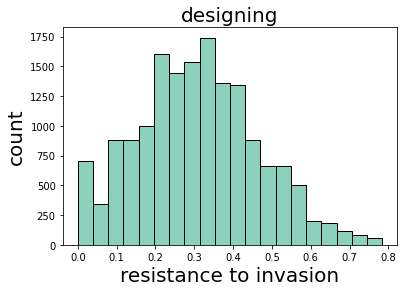

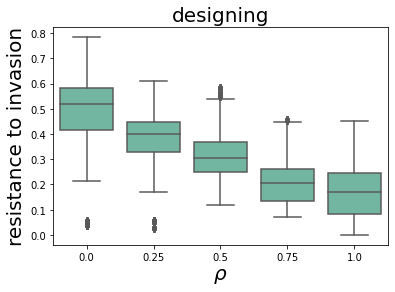

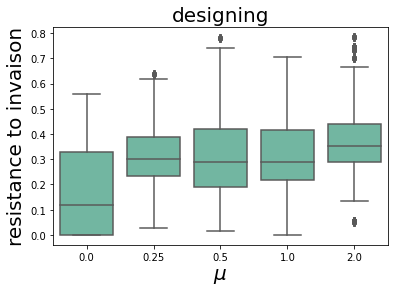

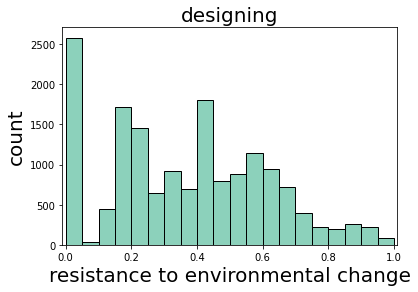

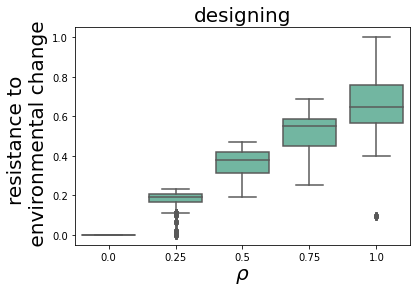

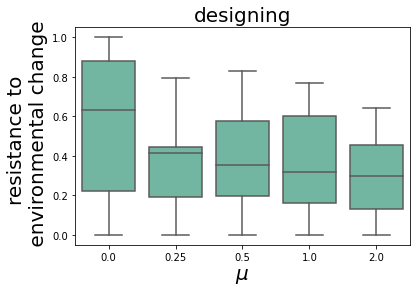

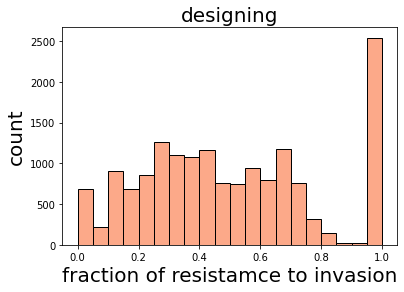

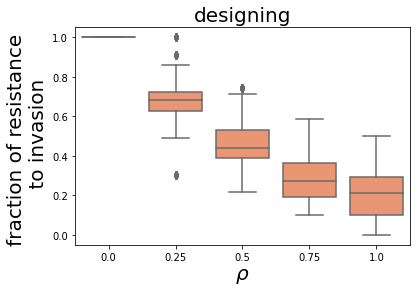

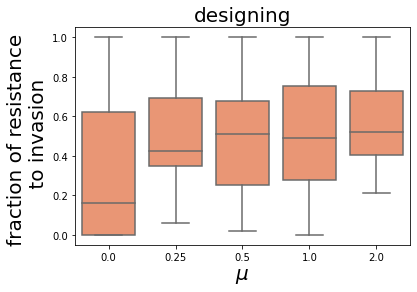

In [43]:
df_design['env_stability']=df_design['full_stability']-df_design['invasion_stability']
df_design['fraction']=df_design['invasion_stability']/df_design['full_stability'].fillna(0)
#resistance to invasion
sns.histplot(data=df_design,x='invasion_stability', bins=20, color='#66c2a5')
#plt.xlim(-0.01, 1.01)
plt.xlabel('resistance to invasion', fontsize=20)
plt.ylabel("count", fontsize=20)
plt.title("designing", fontsize=20)
plt.savefig("ResistInvasion_full_design2.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
sns.boxplot(data=df_design,x='rho',y='invasion_stability', color='#66c2a5')
plt.ylabel('resistance to invasion', fontsize=20)
plt.xlabel(r"$\rho$", fontsize=20)
plt.title("designing", fontsize=20)
plt.savefig("ResistInvasion_rho_design2.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
#sns.stripplot(data=df_assembly,x='mu',y='stability', alpha=0.025, color='#80b1d3')
sns.boxplot(data=df_design,x='mu',y='invasion_stability', color='#66c2a5')
plt.ylabel('resistance to invaison', fontsize=20)
plt.xlabel(r"$\mu$", fontsize=20)
plt.title("designing", fontsize=20)
plt.savefig("ResistInvasion_mu_design2.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

#resistance to env
sns.histplot(data=df_design,x='env_stability', bins=20, color='#66c2a5')
plt.xlim(-0.01, 1.01)
plt.xlabel('resistance to environmental change', fontsize=20)
plt.ylabel("count", fontsize=20)
plt.title("designing", fontsize=20)
plt.savefig("ResistEnvChange_full_design2.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
sns.boxplot(data=df_design,x='rho',y='env_stability', color='#66c2a5')
plt.ylabel('resistance to \n environmental change', fontsize=20)
plt.xlabel(r"$\rho$", fontsize=20)
plt.title("designing", fontsize=20)
plt.savefig("ResistEnvChange_rho_design2.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
sns.boxplot(data=df_design,x='mu',y='env_stability', color='#66c2a5')
plt.ylabel('resistance to \n environmental change', fontsize=20)
plt.xlabel(r"$\mu$", fontsize=20)
plt.title("designing", fontsize=20)
plt.savefig("ResistEnvChange_mu_design2.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

#rfrac of resistance to invaison
sns.histplot(data=df_design,x='fraction', bins=20, color='#fc8d62')
#plt.xlim(-0.01, 1.01)
plt.xlabel('fraction of resistamce to invasion', fontsize=20)
plt.ylabel("count", fontsize=20)
plt.title("designing", fontsize=20)
plt.savefig("Frac_ResistInvasion_full_design2.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
sns.boxplot(data=df_design,x='rho',y='fraction', color='#fc8d62')
plt.ylabel('fraction of resistance \n to invasion', fontsize=20)
plt.xlabel(r"$\rho$", fontsize=20)
plt.title("designing", fontsize=20)
plt.savefig("Frac_ResistInvasion_rho_design2.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
sns.boxplot(data=df_design,x='mu',y='fraction', color='#fc8d62')
plt.ylabel('fraction of resistance \n to invasion', fontsize=20)
plt.xlabel(r"$\mu$", fontsize=20)
plt.title("designing", fontsize=20)
plt.savefig("Frac_ResistInvasion_mu_design2.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

 In both scenarios, the trends over $\mu$ adn $\rho$ are similar.
 1. Over $\rho$: stability increases, res. invasion decreases, res. to environment increases, frac. invasion decreases
 2. Over $\mu$: stability constant, res. invasion increases, res. to environment decreases, frac. invasion increases.
 
 See logistic regression below: contributions of $\mu$ is very small comparing $\rho$.
 Increase of stability over $\rho$ can be understood bycomparing the coefficient of $\rho$ in regression to resistance to the invasion and resistance to environmental change.

In [39]:
# assembly
#vs rho
print(smf.logit(formula='full_stability ~ rho', data=df_assembly).fit().summary())
print(smf.logit(formula='invasion_stability ~ rho', data=df_assembly).fit().summary())
print(smf.logit(formula='env_stability ~ rho', data=df_assembly).fit().summary())
print(smf.logit(formula='fraction~ rho', data=df_assembly).fit().summary())

Optimization terminated successfully.
         Current function value: 0.218883
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         full_stability   No. Observations:               209260
Model:                          Logit   Df Residuals:                   209258
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Mar 2022   Pseudo R-squ.:                 -0.6848
Time:                        08:49:05   Log-Likelihood:                -45804.
converged:                       True   LL-Null:                       -27186.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4798      0.011    134.269      0.000       1.458       1.501
rho            1.2792      0.

In [40]:
#vs mu
print(smf.logit(formula='full_stability ~ mu', data=df_assembly).fit().summary())
print(smf.logit(formula='invasion_stability ~ mu', data=df_assembly).fit().summary())
print(smf.logit(formula='env_stability ~ mu', data=df_assembly).fit().summary())
print(smf.logit(formula='fraction~ mu', data=df_assembly).fit().summary())

Optimization terminated successfully.
         Current function value: 0.225434
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         full_stability   No. Observations:               209260
Model:                          Logit   Df Residuals:                   209258
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Mar 2022   Pseudo R-squ.:                 -0.7352
Time:                        08:49:15   Log-Likelihood:                -47174.
converged:                       True   LL-Null:                       -27186.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1005      0.010    204.907      0.000       2.080       2.121
mu            -0.0463      0.

In [45]:
#vs rho and mu
y=df_assembly.iloc[:, 0] # target
X=df_assembly.iloc[:, 2:4] # features
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =df_assembly.columns[2:4])
data=pd.concat((y,Xss), axis=1)
print(smf.logit(formula='full_stability ~ rho + mu', data=data).fit().summary())
y=df_assembly.iloc[:, 1] # target
X=df_assembly.iloc[:, 2:4] # features
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =df_assembly.columns[2:4])
data=pd.concat((y,Xss), axis=1)
print(smf.logit(formula='invasion_stability ~ rho + mu', data=data).fit().summary())
y=df_assembly.iloc[:, 5] # target
X=df_assembly.iloc[:, 2:4] # features
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =df_assembly.columns[2:4])
data=pd.concat((y,Xss), axis=1)
print(smf.logit(formula='env_stability ~ rho +mu', data=data).fit().summary())
y=df_assembly.iloc[:, 6] # target
X=df_assembly.iloc[:, 2:4] # features
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =df_assembly.columns[2:4])
data=pd.concat((y,Xss), axis=1)
print(smf.logit(formula='fraction~ rho + mu', data=data).fit().summary())

Optimization terminated successfully.
         Current function value: 0.218843
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         full_stability   No. Observations:               209260
Model:                          Logit   Df Residuals:                   209257
Method:                           MLE   Df Model:                            2
Date:                Mon, 21 Mar 2022   Pseudo R-squ.:                 -0.6845
Time:                        09:00:45   Log-Likelihood:                -45795.
converged:                       True   LL-Null:                       -27186.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1382      0.007    289.606      0.000       2.124       2.153
rho            0.4389      0.

In [41]:
# in designing scenario
#vs rho
print(smf.logit(formula='full_stability ~ rho', data=df_design).fit().summary())
print(smf.logit(formula='invasion_stability ~ rho', data=df_design).fit().summary())
print(smf.logit(formula='env_stability ~ rho', data=df_design).fit().summary())
print(smf.logit(formula='fraction~ rho', data=df_design).fit().summary())

Optimization terminated successfully.
         Current function value: 0.535112
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         full_stability   No. Observations:                16160
Model:                          Logit   Df Residuals:                    16158
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Mar 2022   Pseudo R-squ.:                 -0.6843
Time:                        08:51:55   Log-Likelihood:                -8647.4
converged:                       True   LL-Null:                       -5134.1
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0625      0.029     -2.124      0.034      -0.120      -0.005
rho            1.5855      0.

PatsyError: Error evaluating factor: NameError: name 'env_stability' is not defined
    env_stability ~ rho
    ^^^^^^^^^^^^^

In [44]:
#vs mu
print(smf.logit(formula='full_stability ~ mu', data=df_design).fit().summary())
print(smf.logit(formula='invasion_stability ~ mu', data=df_design).fit().summary())
print(smf.logit(formula='env_stability ~ mu', data=df_design).fit().summary())
print(smf.logit(formula='fraction~ mu', data=df_design).fit().summary())

Optimization terminated successfully.
         Current function value: 0.582374
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         full_stability   No. Observations:                16160
Model:                          Logit   Df Residuals:                    16158
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Mar 2022   Pseudo R-squ.:                 -0.8331
Time:                        08:54:39   Log-Likelihood:                -9411.2
converged:                       True   LL-Null:                       -5134.1
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7235      0.026     28.051      0.000       0.673       0.774
mu            -0.0050      0.

In [46]:
#vs rho and mu
y=df_design.iloc[:, 0] # target
X=df_design.iloc[:, 2:4] # features
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =df_design.columns[2:4])
data=pd.concat((y,Xss), axis=1)
print(smf.logit(formula='full_stability ~ rho + mu', data=data).fit().summary())
y=df_design.iloc[:, 1] # target
X=df_design.iloc[:, 2:4] # features
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =df_design.columns[2:4])
data=pd.concat((y,Xss), axis=1)
print(smf.logit(formula='invasion_stability ~ rho + mu', data=data).fit().summary())
y=df_design.iloc[:, 5] # target
X=df_design.iloc[:, 2:4] # features
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =df_design.columns[2:4])
data=pd.concat((y,Xss), axis=1)
print(smf.logit(formula='env_stability ~ rho +mu', data=data).fit().summary())
y=df_design.iloc[:, 6] # target
X=df_design.iloc[:, 2:4] # features
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =df_design.columns[2:4])
data=pd.concat((y,Xss), axis=1)
print(smf.logit(formula='fraction~ rho + mu', data=data).fit().summary())

Optimization terminated successfully.
         Current function value: 0.534706
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         full_stability   No. Observations:                16160
Model:                          Logit   Df Residuals:                    16157
Method:                           MLE   Df Model:                            2
Date:                Mon, 21 Mar 2022   Pseudo R-squ.:                 -0.6830
Time:                        09:03:38   Log-Likelihood:                -8640.8
converged:                       True   LL-Null:                       -5134.1
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7716      0.018     43.783      0.000       0.737       0.806
rho            0.5572      0.

# Analysis of community features

In [ ]:
# calculate contributions (mean abs(coefficient))
def Contribution2(candidate, data):
    # need to rewrite to calculate the coefficients of the best models
    #standarization of data
    y=data.iloc[:, 0] # target
    X=data.iloc[:, 1:] # features
    sscaler = preprocessing.StandardScaler()
    Xss= sscaler.fit(X).transform(X) # standarized
    Xss=pd.DataFrame(Xss, columns =data.columns[1:])
    data=pd.concat((y,Xss), axis=1)
    for i in range(np.size(candidate, 0)):
        formula=candidate.iloc[i, 1] # get formula of the model
        #print(formula)
        model = smf.logit(formula=formula, data=data).fit()
        coef_new=pd.DataFrame(model.params)
        if i== 0:
            coef=coef_new
        else:
            coef=pd.concat([coef, coef_new], axis=1)
    if len(candidate.index)==1:
        # in case we have only one model
         return abs(coef.replace(np.nan, 0))[0]
    else:    
        return abs(coef.replace(np.nan, 0)).mean(axis=1) 
    
def Contribution_main(rho_list=[0.0, 0.25, 0.5, 0.75, 1.0],mu_list=[0.0, 0.25, 0.5, 1.0, 2.0], scenario=0):
    # scenario 0:assembly, otherwise designing
    index=[]
    contr_value=[]
    save_rho=[]
    save_mu=[]
    
    if scenario==0:
        tail='_Assembly_'
        head='assembly_'
    else:
        tail='_Design_'
        head='design2_'
    for i in range(len(rho_list)):
        rho=rho_list[i]
        for j in range(len(mu_list)):
            mu=mu_list[j]
            #print([rho, mu])
            # read file summarizing best models
            if scenario==0 and mu==0 and rho==1:
                print('skip')
            elif scenario==0:
                fname='BestModels'+tail+str('rho%.2f_mu%.2f.csv' %(rho, mu))
                df=pd.read_csv(fname)
                data=pd.read_csv(head+str('rho%.2f_mu%.2f.csv' %(rho, mu)))
            else:
                fname='BestModels'+tail+str('rho%.2f_mu%.2f.csv' %(rho, mu))
                df=pd.read_csv(fname, usecols=[1,2,3,4,5])
                data=pd.read_csv(head+str('rho%.2f_mu%.2f.csv' %(rho, mu)))
            #return [df, data]
            contribution=Contribution2(df, data)
            # get indeces of contributors
            #return contribution
            contribution_index=contribution.index
            # save the contributions
            #print(contribution)
            for k in range(len(contribution_index)):
                index.append(contribution_index[k])
                contr_value.append(contribution[k])
                save_rho.append(rho)
                save_mu.append(mu)
    return pd.DataFrame({'feature':index, 'contribution':contr_value, 'rho':save_rho, 'mu':save_mu})
            

In [ ]:
contribution_assembly= Contribution_main()

In [ ]:
# mean contribution in assembly
index_list=['Intercept', 'total_positive_up', 'total_negative_up', 'mean_positive_up', 'mean_negative_up', 'degree_up',
       'total_positive_down', 'total_negative_down', 'mean_positive_down','mean_negative_down', 'degree_down', 
       'total_positive_trans', 'total_negative_trans', 'mean_positive_trans', 'mean_negative_trans', 'degree_trans']
mean_contr=[]
for i in range(len(index_list)):
    average=contribution_assembly.query(str('feature=="%s"' %(index_list[i]))).iloc[:, 1].sum()/25
    mean_contr.append(average)
mean_contribution=pd.DataFrame({'feature':index_list, 'mean_contribution':mean_contr}).sort_values('mean_contribution', ascending=False)
mean_contribution

In [ ]:
contribution_design= Contribution_main(scenario=1)

In [ ]:
# mean contribution in design
index_list=['Intercept', 'total_positive_up', 'total_negative_up', 'mean_positive_up', 'mean_negative_up', 'degree_up',
       'total_positive_down', 'total_negative_down', 'mean_positive_down','mean_negative_down', 'degree_down', 
       'total_positive_trans', 'total_negative_trans', 'mean_positive_trans', 'mean_negative_trans', 'degree_trans']
mean_contr=[]
for i in range(len(index_list)):
    average=contribution_design.query(str('feature=="%s"' %(index_list[i]))).iloc[:, 1].sum()/25
    mean_contr.append(average)
mean_contribution=pd.DataFrame({'feature':index_list, 'mean_contribution':mean_contr}).sort_values('mean_contribution', ascending=False)
mean_contribution

When we anlyze the mean contirbutions of the features in the two scenario, 
total\_positive\trans and degree\_down seem strong contributors. 

In [ ]:
contribution_assembly.query("feature=='total_positive_trans'")

In [ ]:
contribution_design.query("feature=='total_positive_trans'")

In [ ]:
contribution_assembly.query("feature=='degree_down'")

In [ ]:
contribution_design.query("feature=='degree_down'")

In [ ]:
# How many times each is used ( max 24 or 25)
count_assembly=[]
count_design=[]
for i in range(len(index_list)):
    count_assembly.append(len(contribution_assembly.query(str("feature=='%s'" %(index_list[i])))))
    count_design.append(len(contribution_design.query(str("feature=='%s'" %(index_list[i])))))
df_count=pd.DataFrame({'feature':index_list, 'assembly':count_assembly, 'design':count_design})

In [ ]:
df_count.sort_values('assembly', axis=0, ascending=False)

In the designing scenario, all features almost always appear in the best model.  Then, we can ignore features whose mean contirbution is small.

In [ ]:
print(contribution_design.query("feature=='degree_up'"))
print(contribution_assembly.query("feature=='degree_up'"))

Separte two samling scenario because the assembly does not come from random sampling.
In desgning scenario, all almost feature are inicluded in the best models across mu and rho. Then, mean contribution isa good metric for the absolute values of coefficients.
Top-5 features are degree and popsitive interactions from up to down.
Let see the distribution of the COEFFICIENTS.

In [ ]:
design_features=['degree_down', 'degree_trans', 'degree_up', 'total_positive_trans', 'mean_positive_trans']

def CoefficientSave(candidate, data, df_coef, feature_list, rho, mu):
    f_list=[]
    coef_list=[]
    r_list=[]
    m_list=[]
    
    y=data.iloc[:, 0] # target
    X=data.iloc[:, 1:] # features
    sscaler = preprocessing.StandardScaler()
    Xss= sscaler.fit(X).transform(X) # standarized
    Xss=pd.DataFrame(Xss, columns =data.columns[1:])
    data=pd.concat((y,Xss), axis=1)
    for i in range(np.size(candidate, 0)):
        formula=candidate.iloc[i, 1] # get formula of the model
        #print(formula)
        model = smf.logit(formula=formula, data=data).fit()
        parameter=pd.DataFrame(model.params)
        for j in range(len(parameter)):
            if parameter.index.values[j] in feature_list:
                f_list.append(parameter.index.values[j])
                coef_list.append(parameter.iloc[j,0])
                r_list.append(rho)
                m_list.append(mu)
            
    df_new=pd.DataFrame({'feature':f_list, 'coefficient':coef_list, 'mu':m_list, 'rho':r_list})  
        
    return pd.concat([df_coef, df_new], axis=0, ignore_index=True)

def Coefficient_check(feature_list, scenario, rho_list=[0, 0.25, 0.5, 0.75, 1.0], mu_list=[0.0, 0.25, 0.5, 1.0, 2.0]):
    df_coef=pd.DataFrame({'feature':[], 'coefficient':[], 'mu':[], 'rho':[]})
    if scenario==0:
        tail='_Assembly_'
        head='assembly_'
    else:
        tail='_Design_'
        head='design2_'
    for i in range(len(rho_list)):
        rho=rho_list[i]
        for j in range(len(mu_list)):
            mu=mu_list[j]
            #print([rho, mu])
            # read file summarizing best models
            if scenario==0 and mu==0 and rho==1:
                print('skip')
            elif scenario==0:
                fname='BestModels'+tail+str('rho%.2f_mu%.2f.csv' %(rho, mu))
                df=pd.read_csv(fname)
                data=pd.read_csv(head+str('rho%.2f_mu%.2f.csv' %(rho, mu)))
                df_coef=CoefficientSave(df, data, df_coef, feature_list, rho, mu)
                
            else:
                fname='BestModels'+tail+str('rho%.2f_mu%.2f.csv' %(rho, mu))
                df=pd.read_csv(fname, usecols=[1,2,3,4,5])
                data=pd.read_csv(head+str('rho%.2f_mu%.2f.csv' %(rho, mu)))
                df_coef=CoefficientSave(df, data, df_coef,feature_list, rho, mu)
    return df_coef
    

In [ ]:
coef_design=Coefficient_check(feature_list=index_list, scenario=1)


In [ ]:
import statsmodels
coef_design=pd.read_csv('Design_Coefficients_Best.csv')
top_five=['degree_down', 'degree_trans', 'degree_up', 'total_positive_trans', 'mean_positive_trans']
all_sorted=['degree_down', 'degree_trans', 'degree_up', 'total_positive_trans', 'mean_positive_trans', 'mean_negative_down', 'total_positive_down', 'total_negative_up',
           'total_positive_up', 'mean_positive_down', 'total_negative_down', 'total_negative_trans', 'mean_negative_trans', 'mean_negative_up', 'mean_positive_up']
default=[ 'total_positive_up', 'mean_positive_up', 'total_negative_up', 'mean_negative_up', 'degree_up',
                'total_positive_down','mean_positive_down','total_negative_down','mean_negative_down',  'degree_down',
                'total_positive_trans', 'mean_positive_trans',  'total_negative_trans', 'mean_negative_trans' ,  'degree_trans']
ax=sns.stripplot(data=coef_design, x='feature',y='coefficient', palette='Blues', jitter=True,edgecolor='gray',linewidth=1, 
              hue='mu', order=default)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), title=r'$\mu$')
#plt.hlines(0.5, -0.5, 14.5, color='k', linestyle='--')
plt.hlines(0.0, -0.5, 14.5, color='k', linestyle='-')
#plt.hlines(-0.5, -0.5, 14.5, color='k', linestyle='--')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.ylim(-1.5, 1.5)
sign_list=[]
p_vals=[]
count=[]
for i in range(len(default)):
    if coef_design.query(str('feature=="%s"' %(default[i]))).iloc[:, 1].median()>0:
        sign_list.append(1)
        count.append(len(coef_design.query(str('feature=="%s"' %(default[i])))))
        #print(str("'%s' is greater than 0?" %(default[i])))
        w, p=sp.stats.wilcoxon(coef_design.query(str('feature=="%s"' %(default[i]))).iloc[:, 1].values, alternative='greater')
        p_vals.append(p)
    else:
        sign_list.append(-1)
        #print(str("'%s' is smaller than 0?" %(default[i])))
        count.append(len(coef_design.query(str('feature=="%s"' %(default[i])))))
        w, p=sp.stats.wilcoxon(coef_design.query(str('feature=="%s"' %(default[i]))).iloc[:, 1].values, alternative='less')
        p_vals.append(p)
statsmodels.stats.multitest.fdrcorrection(p_vals)

In [ ]:
# total number of best models
tail='_Design_'
head='design2_'
total_count=0
rho_list=[0, 0.25, 0.5, 0.75, 1.0]
mu_list=[0.0, 0.25, 0.5, 1.0, 2.0]
for i in range(len(rho_list)):
    rho=rho_list[i]
    for j in range(len(mu_list)):
        mu=mu_list[j]
        #print([rho, mu])
        # read file summarizing best models
        fname='BestModels'+tail+str('rho%.2f_mu%.2f.csv' %(rho, mu))
        total_count+=len(pd.read_csv(fname, usecols=[1,2,3,4,5]))    
total_count               
 
design_count=pd.DataFrame({'feature':default, 'count':count, 'freq': [x / total_count for x in count]})
design_count.sort_values(by='count', ascending =False)


As we can see above, mean_positive_down, total_positive_trans, and degree_trans are used in more than 40% of the best models and they are frequently  imfromative.

In [ ]:
#ax=sns.stripplot(data=coef_design, x='feature',y='coefficient', jitter=True,edgecolor='gray',linewidth=1, color='#8da0cb',
 #            order=['mean_positive_down', 'total_positive_trans', 'degree_trans','degree_down', 'total_positive_up', 'degree_up']) # larger than 75% of the the largest
order_y=["degree_trans", "total_positive_trans", "degree_down",  "mean_positive_down","degree_up","total_positive_up" ]
ax=sns.violinplot(data=coef_design.query("feature== 'mean_positive_down' or feature == 'total_positive_trans' or feature == 'degree_trans' or feature == 'degree_down' or feature == 'total_positive_up' or feature == 'degree_up'"),
                  y='feature',x='coefficient', jitter=True,edgecolor='gray',linewidth=1, color='#8da0cb', cut=0, scale="width", 
                  order=order_y) # larger than 75% of the the largest
sns.stripplot(data=coef_design.query("feature== 'mean_positive_down' or feature == 'total_positive_trans' or feature == 'degree_trans' or feature == 'degree_down' or feature == 'total_positive_up' or feature == 'degree_up'"),
                y='feature',x='coefficient', jitter=True,edgecolor='gray',linewidth=1, color='#8da0cb',
               order=order_y) # larger than 75% of the the largest
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), title=r'$\mu$')
plt.vlines(0.5, -0.5, 5.5, color='k', linestyle='--')
plt.vlines(-0.5, -0.5, 5.5, color='k', linestyle='--')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
plt.ylabel('')
plt.vlines(0, -0.5, 5.5, color='k', linestyle='-')
plt.xlabel('coefficient', fontsize=16)
#plt.ylabel('coefficient', fontsize=16)
plt.xlim(-1.5, 1.5)
plt.ylim(-0.5,5.5)
plt.savefig("Design_SelectedFeaturesCoefficient.pdf", pad_inches=0.1, bbox_inches='tight')
sign_list=[]
p_vals=[]
count=[]
for i in range(len(order_y)):
    if coef_design.query(str('feature=="%s"' %(order_y[i]))).iloc[:, 1].median()>0:
        sign_list.append(1)
        print(str("'%s' is greater than 0?" %(order_y[i])))
        w, p=sp.stats.wilcoxon(coef_design.query(str('feature=="%s"' %(order_y[i]))).iloc[:, 1].values, alternative='greater')
        p_vals.append(p)
    else:
        sign_list.append(-1)
        print(str("'%s' is smaller than 0?" %(order_y[i])))
        w, p=sp.stats.wilcoxon(coef_design.query(str('feature=="%s"' %(order_y[i]))).iloc[:, 1].values, alternative='less')
        p_vals.append(p)
statsmodels.stats.multitest.fdrcorrection(p_vals)

As we can see above, all imformative coefficeints include 0s:i.e., sign is not clear. However, there are some trends:
positive: totoal_positive_up, totoal_positive_trans, degree_trans => facilitative upstream communities
negative degree_up(?), mean_positive_down, degree_down

WHY are there such varieties? Can we explain by rho and mu?

In [ ]:
# base code
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Author:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()

        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]),
                ha='right', color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')

        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

In [ ]:
target_feature='degree_trans'
d=coef_design.query(str("feature == '%s'" %(target_feature)))
formula=str("coefficient ~ rho+mu")
model = smf.ols(formula=formula, data=d).fit()
print(model.summary())
sns.scatterplot(data=d, x='mu', y='coefficient')
plt.show()
sns.scatterplot(data=d, x='rho', y='coefficient')
plt.show()
# FOr diaggnosis see below
cls = Linear_Reg_Diagnostic(model)
fig, ax = cls()

In [ ]:
# are there fomula that frequently appear?
def FrmulaSave(candidate, df_formula,rho, mu):
    f_list=[]
    r_list=[]
    m_list=[]
    
    for i in range(np.size(candidate, 0)):
        f_list.append(candidate.iloc[i, 1]) # get formula of the model
        r_list.append(rho)
        m_list.append(mu)
            
    df_new=pd.DataFrame({'formula':f_list,  'mu':m_list, 'rho':r_list})
        
    return pd.concat([df_formula, df_new], axis=0, ignore_index=True)
    
def Formula_check(scenario, rho_list=[0, 0.25, 0.5, 0.75, 1.0], mu_list=[0.0, 0.25, 0.5, 1.0, 2.0]):
    df_formula=pd.DataFrame({'formula':[],  'mu':[], 'rho':[]})
    if scenario==0:
        tail='_Assembly_'
        head='assembly_'
    else:
        tail='_Design_'
        head='design2_'
    for i in range(len(rho_list)):
        rho=rho_list[i]
        for j in range(len(mu_list)):
            mu=mu_list[j]
            #print([rho, mu])
            # read file summarizing best models
            if scenario==0 and mu==0 and rho==1:
                print('skip')
            elif scenario==0:
                fname='BestModels'+tail+str('rho%.2f_mu%.2f.csv' %(rho, mu))
                df=pd.read_csv(fname)
                #data=pd.read_csv(head+str('rho%.2f_mu%.2f.csv' %(rho, mu)))
                #df_formula=CoefficientSave(df, df_formula, rho, mu)
                
            else:
                fname='BestModels'+tail+str('rho%.2f_mu%.2f.csv' %(rho, mu))
                df=pd.read_csv(fname, usecols=[1,2,3,4,5])
                df_formula=FrmulaSave(df, df_formula, rho, mu)
    return df_formula

In [ ]:
design_formula=Formula_check(scenario=1)

In [ ]:
import collections
l=design_formula.iloc[:, 0].values.tolist()
L=collections.Counter(l).most_common()
#L[:55] # appear twice or more
L[:10] # appear three or four times

In [ ]:
#design_formula.query('formula == "stability  ~ total_positive_up + total_positive_trans"')
#design_formula.query('formula == "stability  ~ total_positive_trans"')
#design_formula.query('formula == "stability  ~ total_negative_up + total_positive_trans"')
#design_formula.query('formula == "stability  ~ mean_positive_down + total_positive_trans"')
#design_formula.query('formula == "stability  ~ total_positive_down + total_positive_trans"')
#design_formula.query('formula == "stability  ~ total_positive_down + total_positive_trans"')
#design_formula.query('formula == "stability  ~ mean_negative_down + total_positive_trans"')
#design_formula.query('formula == "stability  ~ mean_positive_down + mean_negative_down"')
#design_formula.query('formula == "stability  ~ mean_negative_down"')
design_formula.query('formula == "stability  ~ total_positive_up + mean_negative_down"')

Shall we check the coefficients in the above frequent models?
But seems that the above is biased toward small rho (never appear rho>1.0)
How about full mode analysis without partinining over rho and mu and including rho and mu in stat analysis?

In [ ]:
def FeatureSelection_Logistic(df):
    """
    df: pandas dataframe, each row represents data, and the first column is target while the rest columns are features
    return the importance of each feature based on the coefficients of them in the best models (Delta AIC<2 and max VIF<10)
    """
    def VIF_check(feature):
        vif = pd.DataFrame()
        vif["VIF Factor"] = [variance_inflation_factor(feature.values, i) for i in range(feature.shape[1])]
       # if max VIF is smaller than 10, we can continue the analysis
        return max(vif.iloc[:, 0])<10
            
    y=df.iloc[:, 0] # target
    X=df.iloc[:, 1:] # features
    sscaler = preprocessing.StandardScaler()
    Xss= sscaler.fit(X).transform(X) # standarized
    Xss=pd.DataFrame(Xss, columns =df.columns[1:]) # adding labels
    
    #Brute force search  of all possioble models
    feature_list = Xss.columns

    def generate_formulas(descriptors, num, target, feature):
        # formulas for regression
        if num > len(descriptors):
            return None
        else:
            for f in itertools.combinations(descriptors, num):
                feature_dropped = feature[list(f)]
                if num>1:
                    if VIF_check(feature_dropped)==1:
                        # VIF are enough small to perform regression
                        formula = target.name + '  ~ ' + ' + '.join(f)
                        yield formula
                else:
                     formula = target.name + '  ~ ' + ' + '.join(f)
                     yield formula

    def modeling_logistic(formula, data):
         #logistic regression of given model
        model = smf.logit(formula=formula, data=data).fit()
        return formula, model

    n_var = []
    formula = []
    model = []
    AIC = []

    for i in range(1,len(feature_list)+1):
        for f in generate_formulas(feature_list, i, y, Xss):
            eq, m = modeling_logistic(formula=f, data=pd.concat([y, Xss], axis=1))
            n_var.append(i)
            formula.append(f)
            model.append(m)
            AIC.append(m.aic)

    df_model = pd.DataFrame({'n_var': n_var,
                            'formula': formula,
                            'model': model,
                            'aic': AIC,
                            'delta_aic': AIC-np.min(AIC)})
    return df_model

def CoefficientSave(candidate, data, feature_list):
    y=data.iloc[:, 0] # target
    X=data.iloc[:, 1:] # features
    sscaler = preprocessing.StandardScaler()
    Xss= sscaler.fit(X).transform(X) # standarized
    Xss=pd.DataFrame(Xss, columns =data.columns[1:])
    data=pd.concat((y,Xss), axis=1)
    for i in range(np.size(candidate, 0)):
        # i-th best model
        formula=candidate.iloc[i, 1] # get formula of the model
        #print(formula)
        model = smf.logit(formula=formula, data=data).fit()
        parameter=pd.DataFrame(model.params)
        f_list=[]
        coef_list=[]
        for j in range(len(parameter)):
            if parameter.index.values[j] in feature_list:
                f_list.append(parameter.index.values[j])
                coef_list.append(parameter.iloc[j,0])  
        df_coef=pd.DataFrame({'feature':f_list, 'coefficient':coef_list})  
        fname=str('%dthModel.csv' %(i))
        df_coef.to_csv(fname, index=False)
    return 0

def FullBestModel(df, scenario):
    df_model=FeatureSelection_Logistic(df.drop(['index'], axis=1)).query('delta_aic<2') #
    if scenario==0:
        fname='BestModelsFull_Assembly.csv'
        os.mkdir('./FullAssembly')
        os.chdir('./FullAssembly')
    else:
        fname='BestModelsFull_Design.csv'
        os.mkdir('./FullDesign')
        os.chdir('./FullDesign')
    df_model.to_csv(fname, index=False)
    index_list=[ 'total_positive_up', 'mean_positive_up', 'total_negative_up', 'mean_negative_up', 'degree_up',
                'total_positive_down','mean_positive_down','total_negative_down','mean_negative_down',  'degree_down',
                'total_positive_trans', 'mean_positive_trans',  'total_negative_trans', 'mean_negative_trans' ,  'degree_trans',
               'mu', 'rho']
    # save coefficient of the best models
    CoefficientSave(df_model, df.drop(['index'], axis=1), feature_list)
    os.chdir('../')
    return 0

## Model selection based on stepwise

BF is time consuming now. Suggest the best models (w/o considering VIF)
1.Forward:bit changeing from https://towardsdatascience.com/stepwise-regression-tutorial-in-python-ebf7c782c922

In [2]:
def composition_convert(abundance):
    return abundance>0.00001


def ListToDF(L):
    # converting 2dim array to the following dataframe
    return pd.DataFrame({'stability':L[0], 'index':L[1], 
                            'total_positive_up':L[2], 'total_negative_up':L[3], 'mean_positive_up':L[4], 'mean_negative_up': L[5], 'degree_up':L[6], 
                            'total_positive_down':L[7], 'total_negative_down':L[8], 'mean_positive_down':L[9], 'mean_negative_down': L[10], 'degree_down':L[11],
                            'total_positive_trans':L[12], 'total_negative_trans':L[13], 'mean_positive_trans':L[14], 'mean_negative_trans': L[15], 'degree_trans':L[16],
                        'resistance_invasion':L[17], 'resistance_environment':L[18]})

def Analysis(List, A, r_up, r_down, index, scenario):
    """
    analze structural stabiliy given community parameters
    scenario ==0 => assembly otherwise designing
    """
    stability=[]
    indeces=[]
    total_positive_up=[]
    total_negative_up=[]
    mean_positive_up=[]
    mean_negative_up=[]
    degree_up=[]
    total_positive_down=[]
    total_negative_down=[]
    mean_positive_down=[]
    mean_negative_down=[]
    degree_down=[]
    total_positive_trans=[]
    total_negative_trans=[]
    mean_positive_trans=[]
    mean_negative_trans=[]
    degree_trans=[]
    invasion=[]
    envir=[]
    feature=[stability, indeces, 
            total_positive_up, total_negative_up, mean_positive_up, mean_negative_up, degree_up,
            total_positive_down, total_negative_down, mean_positive_down, mean_negative_down, degree_down,
            total_positive_trans, total_negative_trans, mean_positive_trans, mean_negative_trans, degree_trans,
             invasion, envir]
    
    if scenario==0:
        os.chdir('./assembly')
        abundance=np.loadtxt('abundance.csv', delimiter=',', skiprows=0)
        stability=np.loadtxt('stability_new.csv', delimiter=',', skiprows=0)
        invasion_stab=np.loadtxt('invasion_stability.csv', delimiter=',', skiprows=0)
        N=np.size(r_up)
    else:
        os.chdir('./designing2')
        stability=np.loadtxt('stability_new.csv', delimiter=',', skiprows=0)
        down_abundance=np.loadtxt('target_down.csv', delimiter=',', skiprows=0)
        up_abundance=np.loadtxt('upstream_community.csv', delimiter=',', skiprows=0)
        invasion_stab=np.loadtxt('invasion_stability_new.csv', delimiter=',', skiprows=0)
    for t in range(len(stability)):
        if scenario==0:
            #assembly
            if t==0:
                abundance_prev=np.zeros([2*N])
            else:
                abundance_prev=abundance[t-1, :]
            if np.all(abundance[t, :] == abundance_prev) == False:
                # we only analyze the cases where species abundances change from the previous time step
                feature=Network(feature,  stability[t], invasion_stab[t], A, abundance[t, :N], abundance[t, N:], index)
        else:
            # dsigning
            if np.isnan(stability[t])==False:
                # we only consider the case when the  target downstream community is maintained.
                feature=Network(feature,  stability[t], invasion_stab[t], A, up_abundance[t, :], down_abundance, index)
    os.chdir('../')
    if List==[]:
        return feature
    else:
        for i in range(len(List)):
            List[i].extend(feature[i])
        return List
            
def Network(List, stability, invasion_stab, interaction,  up_abundance, down_abundance, index):
    # analyzing species interaction network given community compositions
    up_composition=composition_convert(up_abundance)
    down_composition=composition_convert(down_abundance)
    num=np.size(up_composition)
    
    positive_up=[]# positive interaction among upstream
    negative_up=[]# newgative interaction among upstream
    positive_down=[]# positive interaction among downstream
    negative_down=[]# newgative interaction among downstream
    positive_trans=[]# positive interaction from upstream to downstrea
    negative_trans=[]# newgative interaction from upstream to downstrea
    degree_up=[] # degreee within upstream
    degree_down=[] # degree within donwstream
    degree_trans=[] # degree between streams
    
    for i in range(num):
        # i is recever
        degree_up_count=0
        degree_down_count=0
        degree_trans_count=0
        for j in range(num):
            # upstream
            if i !=j and up_composition[i]==1 and up_composition[j]==1:
                #i and j should be different species and they should exist
                if interaction[i, j]>0:
                    positive_up.append(interaction[i, j])
                    degree_up_count+=1
                elif interaction[i, j]<0:
                    #note that we need to ignore no interactio
                    negative_up.append(- interaction[i, j])  # note that we get the sum of strength of negative interaction
                    degree_up_count+=1
            #downsteram
            if i!=j and down_composition[i]==1 and down_composition[j]==1:
                if interaction[i, j]>0:
                    positive_down.append(interaction[i, j])
                    degree_down_count+=1
                elif interaction[i,j]<0:
                    negative_down.append(- interaction[i, j] )
                    degree_down_count+=1
            # from up to down
            if up_composition[j]==1 and down_composition[i]==1:
                if interaction[i, j]>0:
                    positive_trans.append(interaction[i, j])
                    degree_trans_count+=1
                elif interaction[i,j]<0:
                    negative_trans.append(- interaction[i, j] )
                    degree_trans_count+=1
        # degree
        if up_composition[i]==1:
            degree_up.append(degree_up_count)
        if down_composition[i]==1:
            degree_down.append(degree_down_count)
            degree_trans.append(degree_trans_count)
    # ---------------------adding to List---------------
    List[0].append(stability)
    List[1].append(index)
    List[2].append(np.sum(positive_up))
    List[3].append(np.sum(negative_up))
    List[4].append(np.mean(positive_up))
    List[5].append(np.mean(negative_up))
    List[6].append(np.mean(degree_up))
    List[7].append(np.sum(positive_down))
    List[8].append(np.sum(negative_down))
    List[9].append(np.mean(positive_down))
    List[10].append(np.mean(negative_down))
    List[11].append(np.mean(degree_down))
    List[12].append(np.sum(positive_trans))
    List[13].append(np.sum(negative_trans))
    List[14].append(np.mean(positive_trans))
    List[15].append(np.mean(negative_trans))
    List[16].append(np.mean(degree_trans))
    List[17].append(invasion_stab)
    List[18].append(stability-invasion_stab)
    
    return List
            
    
    

def DataFrameGenerator(c_list, rho, mu, replicate=20):
    """
    generating dataframe containing structural stbaility and 15 features
    c_list: list of connectance in interaction network
    mu, rho: parameter of migration
    """
    assembly=[] # 2dim list
    design=[] #2dim list
    for c in range(len(c_list)):
        connect=c_list[c]
        path=str('./connectance%.2f' %(connect))
        os.chdir(path)
        for i in range(replicate):
            path=str('./replicate%d/rho%.2f_mu%.2f' %(i, rho, mu))
            os.chdir(path)
            A=-np.loadtxt('../interaction.csv', delimiter=',', skiprows=0) # note -A is the correct interaction (as diagonal is 1)
            r_up=np.loadtxt('../growthrate_up.csv', delimiter=',', skiprows=0)
            r_down=np.loadtxt('../growthrate_down.csv', delimiter=',', skiprows=0)
            assembly=Analysis(assembly, A, r_up, r_down, i+c*replicate, 0)
            design=Analysis(design, A, r_up, r_down, i+c*replicate, 1)
            os.chdir('../../')
        os.chdir('../')
    df_assembly=ListToDF(assembly).fillna(0)
    df_design=ListToDF(design)
    return [df_assembly, df_design]

def main(c_list=[1.0, 0.5, 0.25], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], mu_list=[0.0, 0.25, 0.5, 1.0, 2.0]):
    for i in range(len(rho_list)):
        rho=rho_list[i]
        for j in range(len(mu_list)):
            mu=mu_list[j]
            print([rho, mu])
            df_assembly, df_design=DataFrameGenerator(c_list, rho, mu, replicate=20)
            df_assembly.to_csv(str('assembly_rho%.2f_mu%.2f.csv'%(rho, mu)), index=False)
            df_design.to_csv(str('design2_rho%.2f_mu%.2f.csv'%(rho, mu)), index=False)
    return 0
main()
            
# Starting Thursday 17:30            

[0.0, 0.0]


/Users/shota/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shota/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.0, 0.25]
[0.0, 0.5]
[0.0, 1.0]
[0.0, 2.0]
[0.25, 0.0]
[0.25, 0.25]
[0.25, 0.5]
[0.25, 1.0]
[0.25, 2.0]
[0.5, 0.0]
[0.5, 0.25]
[0.5, 0.5]
[0.5, 1.0]
[0.5, 2.0]
[0.75, 0.0]
[0.75, 0.25]
[0.75, 0.5]
[0.75, 1.0]
[0.75, 2.0]
[1.0, 0.0]
[1.0, 0.25]
[1.0, 0.5]
[1.0, 1.0]
[1.0, 2.0]


0

In [ ]:
#os.chdir('./data')
os.getcwd()

In [3]:
def FullData(scenario, rho_list=[0.0, 0.25, 0.5, 0.75, 1.0],mu_list=[0.0, 0.25, 0.5,1.0, 2.0]):
    if scenario==0:
        header='assembly'
    else:
        header='design2'
    for i in range(len(rho_list)):
        rho=rho_list[i]
        for j in range(len(mu_list)):
            mu=mu_list[j]
            fname=header+str('_rho%.2f_mu%.2f.csv'%(rho, mu))
            df=pd.read_csv(fname).fillna(0)
            df['rho']=np.ones([len(df)])*rho
            df['mu']=np.ones([len(df)])*mu
            if i ==0 and j==0:
                df_new=df
            else:
                df_new=pd.concat([df_new, df], axis=0, ignore_index=True)
    return df_new.reindex(columns=[ 'stability', 'resistance_invasion','resistance_environment',
                'total_positive_up', 'mean_positive_up', 'total_negative_up', 'mean_negative_up', 'degree_up',
                'total_positive_down','mean_positive_down','total_negative_down','mean_negative_down',  'degree_down',
                'total_positive_trans', 'mean_positive_trans',  'total_negative_trans', 'mean_negative_trans' ,  'degree_trans',
               'mu', 'rho'])
data=FullData(scenario=1)


#standarize
y=data.iloc[:, 0] # target
y2=data.iloc[:, 1:3]
X=data.iloc[:, 3:] # features but ignore index, resistance to invasion/environmental change
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =data.columns[3:])
df_design=pd.concat((y, y2, Xss), axis=1).fillna(0)
df_design# standaril data


stability  resistance_invasion  resistance_environment  \
0          0.560                0.560                   0.000   
1          0.560                0.560                   0.000   
2          0.560                0.560                   0.000   
3          0.680                0.680                   0.000   
4          0.440                0.440                   0.000   
...          ...                  ...                     ...   
18917      0.723                0.213                   0.510   
18918      0.756                0.222                   0.534   
18919      0.829                0.244                   0.585   
18920      0.800                0.267                   0.533   
18921      0.872                0.256                   0.616   

       total_positive_up  mean_positive_up  total_negative_up  \
0               0.347624         -0.769937           1.849526   
1               0.890466          0.075606           0.919274   
2               1.794040          0.335235           2.255920   
3               0.940464          0.030345           0.169900   
4              -0.142401         -1.114892           0.431989   
...                  ...               ...                ...   
18917          -0.573009         -0.270532          -0.220683   
18918          -0.924958         -0.369377          -0.896682   
18919          -0.871427          0.727353          -0.736555   
18920          -0.683799          0.874022          -0.846670   
18921          -1.132454         -0.476534          -0.749872   

       mean_negative_up  degree_up  total_positive_down  mean_positive_down  \
0              0.219242   2.220681            10.599634            1.177726   
1              1.439328   1.720004            10.599634            1.177726   
2              0.139275   2.721358             0.075762            1.175809   
3             -0.302198   1.720004             0.075762            1.175809   
4              1.782933   1.219327             0.075762            1.175809   
...                 ...        ...                  ...                 ...   
18917          0.070635  -0.464767            -0.508302           -0.809608   
18918         -0.469284  -0.983650            -0.508302           -0.809608   
18919          0.167407  -0.783380            -0.508302           -0.809608   
18920          0.558071  -0.983650            -0.508302           -0.809608   
18921          1.408380  -0.926430            -0.508302           -0.809608   

       total_negative_down  mean_negative_down  degree_down  \
0                11.335954            0.995245     7.690011   
1                11.335954            0.995245     7.690011   
2                -0.492461           -0.700100     0.307283   
3                -0.492461           -0.700100     0.307283   
4                -0.492461           -0.700100     0.307283   
...                    ...                 ...          ...   
18917            -0.492461           -0.700100    -0.747393   
18918            -0.492461           -0.700100    -0.747393   
18919            -0.492461           -0.700100    -0.747393   
18920            -0.492461           -0.700100    -0.747393   
18921            -0.492461           -0.700100    -0.747393   

       total_positive_trans  mean_positive_trans  total_negative_trans  \
0                  6.162821             0.033989              3.774293   
1                  5.363451             0.369448              5.093681   
2                  1.422396             0.648003              0.324859   
3                  1.068889             0.496027              0.172412   
4                 -0.111969            -0.162865             -0.088799   
...                     ...                  ...                   ...   
18917             -0.866229             0.063291             -0.773351   
18918             -1.040230            -1.976636             -0.983803   
18919             -0.784203            -0.475849             -1.049105   

In [103]:
import statsmodels.formula.api as smf


def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels  logistic regression
           with an intercept
           selected by forward selection
           evaluated by psuedo R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            #print(candidate)
            formula = "{} ~ {}".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.logit(formula, data).fit().prsquared 
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        #print([best_new_score, best_candidate])
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} ".format(response,
                                   ' + '.join(selected))
    model = smf.logit(formula, data).fit()
    return model

In [119]:
#Full model
full_model=smf.logit('stability ~  total_positive_up + mean_positive_up + total_negative_up +mean_negative_up + degree_up'+
                     '+ total_positive_down + mean_positive_down + total_negative_down + mean_negative_down + degree_down'+
                '+ total_positive_trans + mean_positive_trans + total_negative_trans + mean_negative_trans + degree_trans'+
               '+mu +rho', df_design.drop(['resistance_invasion', 'resistance_environment'], axis=1)).fit()
print(full_model.summary())
print([full_model.aic,full_model.aic])# AICand BIC
#model.prsquared #Psedo-Rsquare


Optimization terminated successfully.
         Current function value: 0.559295
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                18922
Model:                          Logit   Df Residuals:                    18904
Method:                           MLE   Df Model:                           17
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                0.004995
Time:                        15:42:47   Log-Likelihood:                -10583.
converged:                       True   LL-Null:                       -10636.
Covariance Type:            nonrobust   LLR p-value:                 6.078e-15
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5191      0.016     32.413      0.000       0.488       0.551

In [120]:
# Null model
null_model=smf.logit('stability ~1 ', df_design.drop(['resistance_invasion', 'resistance_environment'], axis=1)).fit()
print(null_model.summary())
print([null_model.aic, null_model.bic])# AICand BIC

Optimization terminated successfully.
         Current function value: 0.646680
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                18922
Model:                          Logit   Df Residuals:                    18921
Method:                           MLE   Df Model:                            0
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                 -0.1505
Time:                        15:42:48   Log-Likelihood:                -12236.
converged:                       True   LL-Null:                       -10636.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4611      0.015     30.888      0.000       0.432       0.490
[24474.9638753173, 24482.8119

In [121]:
# forward selection without VIF
forward_model=forward_selected(df_design.drop(['resistance_invasion', 'resistance_environment'], axis=1), 'stability')
print(forward_model.summary())# which is identical to Full model
print([forward_model.aic, forward_model.bic])

Optimization terminated successfully.
         Current function value: 0.646300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646526
  

Not Psuedo R here is based on the ratio of log likelihood of the focal model to the null model.
Forward model is better than the null model bus some coefficeint can be ignored due to the small coefficient values and their large p-values.


In [231]:
# backward model by hand based on p-value
#Removing : mean_positive_tras->degree_down->mean_negative_up ->mean_positive_down
#total_positive_down ->total_positive_up->mean_negative_down ->mean_negative_trans
#mean_positive_up->total_negative_down->total_negative_trans->degree_up
backward_model=smf.logit('stability ~ degree_trans'+
               '+mu +rho + total_negative_up +  total_positive_trans',
df_design.drop(['resistance_invasion', 'resistance_environment'], axis=1)).fit()
print(backward_model.summary())
print([backward_model.aic,backward_model.aic])# AICand BIC
#model.prsquared #Psedo-Rsquare

Optimization terminated successfully.
         Current function value: 0.559654
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                18922
Model:                          Logit   Df Residuals:                    18916
Method:                           MLE   Df Model:                            5
Date:                Tue, 15 Mar 2022   Pseudo R-squ.:                0.004357
Time:                        09:08:57   Log-Likelihood:                -10590.
converged:                       True   LL-Null:                       -10636.
Covariance Type:            nonrobust   LLR p-value:                 1.839e-18
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5189      0.016     32.406      0.000       0.488       0.550

Due to the large sample sies, AIC and BIC have different suggestion on which forawad model is better.

In addition, we can check the VIF to remove multicoliniality

In [26]:
def VIF_check(feature):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(feature.values, i) for i in range(feature.shape[1])]
    return vif

In [123]:
# from full model
#remove degree_down, 'degreee_up'
VIF_check(df_design.drop(['stability', 'resistance_invasion', 'resistance_environment', 'degree_down', 'degree_up'], axis=1))
full_model2=smf.logit('stability ~  total_positive_up + mean_positive_up + total_negative_up +mean_negative_up'+
                     '+ total_positive_down + mean_positive_down + total_negative_down + mean_negative_down'+
               '+ total_positive_trans + mean_positive_trans + total_negative_trans + mean_negative_trans + degree_trans'+
               '+mu +rho', df_design.drop(['resistance_invasion', 'resistance_environment'], axis=1)).fit()
print(full_model2.summary())
print([full_model2.aic,full_model2.bic])# AICand BIC

Optimization terminated successfully.
         Current function value: 0.559419
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                18922
Model:                          Logit   Df Residuals:                    18906
Method:                           MLE   Df Model:                           15
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                0.004775
Time:                        15:43:31   Log-Likelihood:                -10585.
converged:                       True   LL-Null:                       -10636.
Covariance Type:            nonrobust   LLR p-value:                 6.561e-15
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5191      0.016     32.411      0.000       0.488       0.550

In [124]:
# from forward model
# removing degree_up
"""
Intercept                0.5191      0.016     32.411      0.000       0.488       0.550
rho                      0.7128      0.017     42.809      0.000       0.680       0.745
total_positive_trans     0.0664      0.032      2.062      0.039       0.003       0.130
total_negative_up        0.0490      0.039      1.264      0.206      -0.027       0.125
degree_trans            -0.1384      0.036     -3.872      0.000      -0.209      -0.068
degree_up                0.0719      0.054      1.333      0.183      -0.034       0.178
mean_positive_up         0.0135      0.018      0.766      0.444      -0.021       0.048
total_negative_trans     0.0376      0.028      1.328      0.184      -0.018       0.093
mean_negative_trans     -0.0158      0.018     -0.893      0.372      -0.051       0.019
total_negative_down     -0.0236      0.027     -0.881      0.379      -0.076       0.029
mu                      -0.0588      0.016     -3.739      0.000      -0.090      -0.028
total_positive_up        0.0130      0.040      0.327      0.743      -0.065       0.091
mean_positive_trans      0.0025      0.018      0.142      0.887      -0.033       0.038
mean_negative_up        -0.0025      0.017     -0.144      0.885      -0.037       0.032
total_positive_down     -0.0031      0.030     -0.105      0.916      -0.061       0.055

#print(VIF_check(df_design[['rho', 'total_positive_trans', 'total_negative_up', 'degree_trans',
                  'mean_positive_up', 'total_negative_trans', 'mean_negative_trans', 'mu', 'total_positive_up',
                  'mean_positive_trans', 'mean_negative_up', 'total_positive_down']]))
"""
forward_model2=smf.logit('stability ~ rho + total_negative_trans + total_positive_up +degree_trans'+ 
                  '+mean_negative_up + total_positive_trans + mean_positive_trans + mu +total_negative_up'+
                  '+ mean_negative_trans + total_negative_down',
                    df_design.drop(['resistance_invasion', 'resistance_environment'], axis=1)).fit()
print(forward_model2.summary())
print([forward_model2.aic,forward_model2.aic])# AICand BIC


Optimization terminated successfully.
         Current function value: 0.559437
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                18922
Model:                          Logit   Df Residuals:                    18910
Method:                           MLE   Df Model:                           11
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                0.004742
Time:                        15:43:32   Log-Likelihood:                -10586.
converged:                       True   LL-Null:                       -10636.
Covariance Type:            nonrobust   LLR p-value:                 1.197e-16
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5190      0.016     32.409      0.000       0.488       0.550

In [125]:
# from backward model
#  not removing
"""
Intercept                0.5189      0.016     32.406      0.000       0.488       0.550
degree_trans            -0.0944      0.026     -3.589      0.000      -0.146      -0.043
mu                      -0.0587      0.016     -3.736      0.000      -0.089      -0.028
rho                      0.7134      0.017     42.905      0.000       0.681       0.746
total_negative_up        0.0953      0.025      3.861      0.000       0.047       0.144
total_positive_trans     0.0755      0.018      4.151      0.000       0.040       0.111
"""
VIF_check(df_design[['total_negative_up', 'total_positive_trans', 'degree_trans', 'mu', 'rho' ]])

VIF Factor
0    2.442794
1    1.305830
2    2.790047
3    1.002506
4    1.002710

So far we have 6 models
1. null model
2. full model1
3. full model2 (+VIF)
4. forward model1
5. forward model2 (+VIF)
6. backward model

Compare their AIC and BIC+> Backward model seems the best as below:

In [48]:

AICs=[null_model.aic, full_model.aic, full_model2.aic, forward_model.aic,
                         forward_model2.aic, backward_model.aic]
BICs=[null_model.bic, full_model.bic, full_model2.bic, forward_model.bic,
                         forward_model2.bic, backward_model.bic]
IC=pd.DataFrame({'model':['null', 'full1', 'full2', 'forward1', 'forward2', 'backward'],
                   r'D_AIC':AICs-np.min(AICs),
                   'D_BIC':BICs-np.min(BICs)}).sort_values('D_AIC')
IC

model        D_AIC        D_BIC
5  backward     0.000000     0.000000
4  forward2     3.801239    50.889722
3  forward1     4.418809    75.051534
1     full1    10.419450   104.596417
2     full2    11.104186    89.584992
0      null  3283.415423  3244.175020

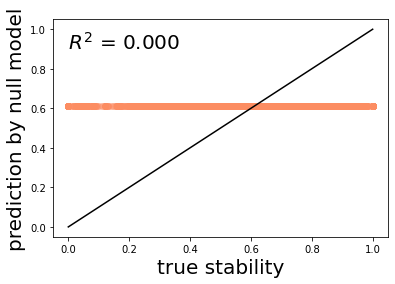

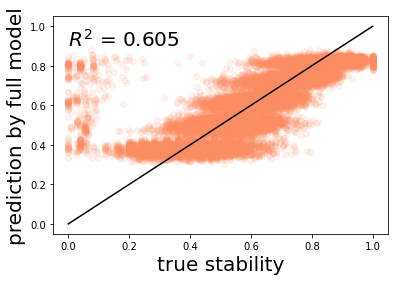

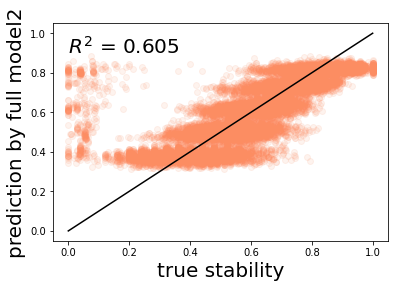

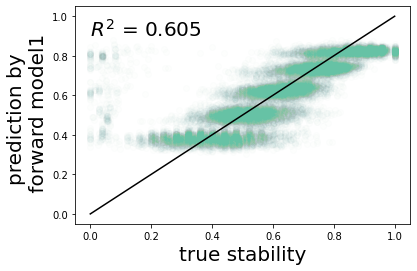

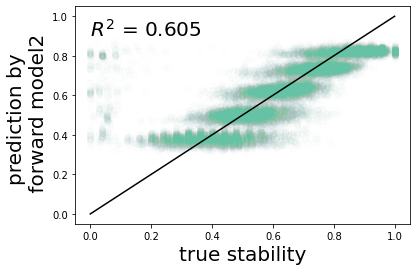

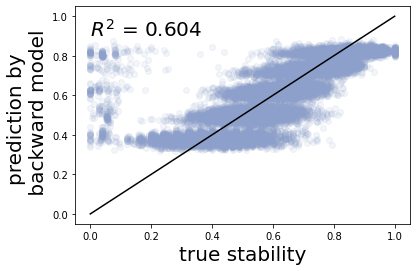

In [61]:
from sklearn.metrics import r2_score

plt.scatter(df_design.iloc[:, 0], null_model.predict(df_design.iloc[:, 1:]), color='#fc8d62', alpha=0.1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('true stability', fontsize=20)
plt.ylabel('prediction by null model', fontsize=20)
R2=r2_score(df_design.iloc[:, 0], null_model.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Null_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], full_model.predict(df_design.iloc[:, 1:]), color='#fc8d62', alpha=0.1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('true stability', fontsize=20)
plt.ylabel('prediction by full model', fontsize=20)
R2=r2_score(df_design.iloc[:, 0], full_model.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Full1_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], full_model2.predict(df_design.iloc[:, 1:]), color='#fc8d62', alpha=0.1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('true stability', fontsize=20)
plt.ylabel('prediction by full model2', fontsize=20)
R2=r2_score(df_design.iloc[:, 0], full_model2.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Full2_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], forward_model.predict(df_design.iloc[:, 1:]), color='#66c2a5', alpha=0.01)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('true stability', fontsize=20)
plt.ylabel('prediction by \n forward model1', fontsize=20)
R2=r2_score(df_design.iloc[:, 0], forward_model.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Forward1_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], forward_model2.predict(df_design.iloc[:, 1:]), color='#66c2a5', alpha=0.01)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('true stability', fontsize=20)
plt.ylabel('prediction by \n forward model2', fontsize=20)
R2=r2_score(df_design.iloc[:, 0], forward_model2.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Forward2_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], backward_model.predict(df_design.iloc[:, 1:]), color='#8da0cb', alpha=0.1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('true stability', fontsize=20)
plt.ylabel('prediction by \n backward model', fontsize=20)
R2=r2_score(df_design.iloc[:, 0], backward_model.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('backward1_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()




0.6036568385517354

In [51]:
# using assembly data as test data
data1=FullData(scenario=1)
data2=FullData(scenario=0).query('rho<1 or mu>0').query('rho>0').reset_index(drop=True) 
# ignore scenarios where downstream is empty or upstream is empty

#standarize
y=data2.iloc[:, 0] # target
y2=data2.iloc[:, 1:3]
X1=data1.iloc[:, 3:] # features but ignore index, resistance to invasion/environmental change
X2=data2.iloc[:, 3:] # features but ignore index, resistance to invasion/environmental change
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X1).transform(X2) # standarized
Xss=pd.DataFrame(Xss, columns =data2.columns[3:])
df_assembly=pd.concat((y, y2, Xss), axis=1).fillna(0)
df_assembly# standaril data

stability  resistance_invasion  resistance_environment  \
0           0.280                0.030                   0.250   
1           0.400                0.150                   0.250   
2           0.420                0.180                   0.240   
3           0.450                0.210                   0.240   
4           0.470                0.240                   0.230   
...           ...                  ...                     ...   
175217      0.966                0.542                   0.424   
175218      0.966                0.542                   0.424   
175219      0.966                0.542                   0.424   
175220      0.966                0.542                   0.424   
175221      0.966                0.542                   0.424   

        total_positive_up  mean_positive_up  total_negative_up  \
0               -1.455966         -4.619126          -1.432194   
1               -1.455966         -4.619126          -1.432194   
2               -1.455966         -4.619126          -1.432194   
3               -1.455966         -4.619126          -1.432194   
4               -1.455966         -4.619126          -1.432194   
...                   ...               ...                ...   
175217           1.212211         -0.348343           0.988847   
175218           1.212211         -0.348343           0.988847   
175219           1.212211         -0.348343           0.988847   
175220           1.212211         -0.348343           0.988847   
175221           1.212211         -0.348343           0.988847   

        mean_negative_up  degree_up  total_positive_down  mean_positive_down  \
0              -4.585442  -1.784733            -0.508302           -0.809608   
1              -4.585442  -1.784733            -0.028842            0.820227   
2              -4.585442  -1.784733             0.533028            0.960296   
3              -4.585442  -1.784733             1.626483            1.263764   
4              -4.585442  -1.784733             2.762087            1.413807   
...                  ...        ...                  ...                 ...   
175217         -0.667741   0.512490             1.201866            1.128191   
175218         -0.667741   0.512490             1.201866            1.128191   
175219         -0.667741   0.512490             1.201866            1.128191   
175220         -0.667741   0.512490             1.201866            1.128191   
175221         -0.667741   0.512490             1.201866            1.128191   

        total_negative_down  mean_negative_down  degree_down  \
0                 -0.492461           -0.700100    -0.747393   
1                 -0.492461           -0.700100     0.307283   
2                 -0.312076           -0.260577     1.361958   
3                  0.730054            0.491402     2.416634   
4                  2.355038            0.687531     3.471309   
...                     ...                 ...          ...   
175217             0.722591            0.780185     0.759286   
175218             0.722591            0.780185     0.759286   
175219             0.722591            0.780185     0.759286   
175220             0.722591            0.780185     0.759286   
175221             0.722591            0.780185     0.759286   

        total_positive_trans  mean_positive_trans  total_negative_trans  \
0                   -1.04023            -1.976636             -1.133261   
1                   -1.04023            -1.976636             -1.133261   
2                   -1.04023            -1.976636             -1.133261   
3                   -1.04023            -1.976636             -1.133261   
4                   -1.04023            -1.976636             -1.133261   
...                      ...                  ...                   ...   
175217               1.23938             0.452946              3.643792   
175218               1.23938             0.452946              3.643792   
175219           

"\nax1.set_xlabel('true stability', fontsize=20)\nax1.set_ylabel('prediction by null model', fontsize=20)\nfig1.gca().set_rasterized(True)\nfig1.savefig('Null_assembly.pdf', pad_inches=0.1, bbox_inches='tight')\nax2.set_xlabel('true stability', fontsize=20)\nax2.set_ylabel('prediction by full model1', fontsize=20)\nfig2.gca().set_rasterized(True)\nfig2.savefig('Full1_assembly.pdf', pad_inches=0.1, bbox_inches='tight')\nax3.set_xlabel('true stability', fontsize=20)\nax3.set_ylabel('prediction by full model2', fontsize=20)\nfig3.gca().set_rasterized(True)\nfig3.savefig('Full2_assembly.pdf', pad_inches=0.1, bbox_inches='tight')\nax4.set_xlabel('true stability', fontsize=20)\nax4.set_ylabel('prediction by \n forward model1', fontsize=20)\nfig4.gca().set_rasterized(True)\nfig4.savefig('Forward1_assembly.pdf', pad_inches=0.1, bbox_inches='tight')\nax5.set_xlabel('true stability', fontsize=20)\nax5.set_ylabel('prediction by \n forward model2', fontsize=20)\nfig5.gca().set_rasterized(True)\nfi

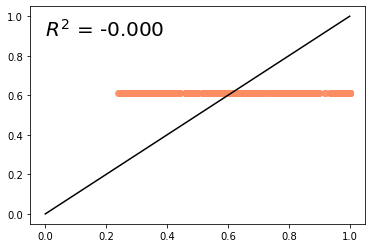

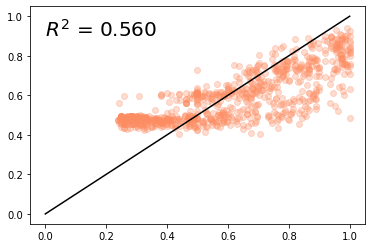

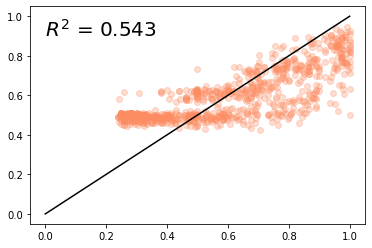

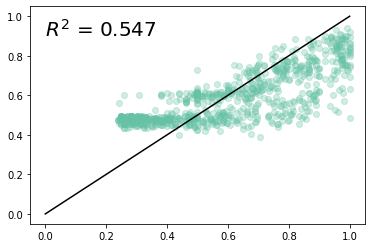

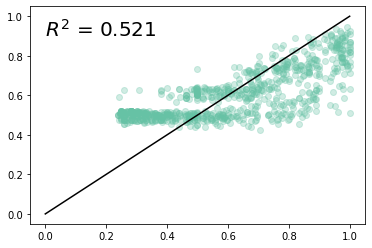

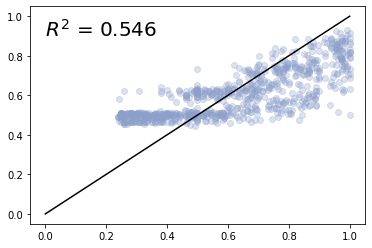

In [145]:
# difference to assembly data (test data)
# using all would be problematic as they are non random data
# However most data of assembly is stability >0.85 wheich are rare in design data => bad fitting
np.random.seed(0) 
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()
fig6, ax6 = plt.subplots()
diff1=0
diff2=0
diff3=0
diff4=0
diff5=0
diff6=0
 # remove cases where downstream is absent
flag=0
for i in range(2, 10):
    df=df_assembly.query(str('stability<=%.1f' %((i+1)*0.1))).reset_index(drop=True) # conside only stabiliy <0.95
    df=df.query(str('stability>=%.1f' %(i*0.1))).reset_index(drop=True) # conside only stabiliy <0.95
    rand_samp=np.random.randint(low=0, high=len(df), size=100).tolist()
    if flag==0:
        df_sub=df.iloc[rand_samp, :]
        flag=1
    else:
        df_sub=pd.concat([df_sub,df.iloc[rand_samp, :]], axis=0, ignore_index=True)
ax1.scatter(df_sub.iloc[:, 0], null_model.predict(df_sub.iloc[:, 1:]), color='#fc8d62', alpha=0.3)
ax1.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
R2=r2_score(df_sub.iloc[:, 0], null_model.predict(df_sub.iloc[:, 1:]))
ax1.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax2.scatter(df_sub.iloc[:, 0], full_model.predict(df_sub.iloc[:, 1:]), color='#fc8d62', alpha=0.3)
ax2.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
R2=r2_score(df_sub.iloc[:, 0], full_model.predict(df_sub.iloc[:, 1:]))
ax2.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax3.scatter(df_sub.iloc[:, 0], full_model2.predict(df_sub.iloc[:, 1:]), color='#fc8d62', alpha=0.3)
ax3.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
R2=r2_score(df_sub.iloc[:, 0], full_model2.predict(df_sub.iloc[:, 1:]))
ax3.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax4.scatter(df_sub.iloc[:, 0], forward_model.predict(df_sub.iloc[:, 1:]), color='#66c2a5', alpha=0.3)
ax4.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
R2=r2_score(df_sub.iloc[:, 0], forward_model.predict(df_sub.iloc[:, 1:]))
ax4.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax5.scatter(df_sub.iloc[:, 0], forward_model2.predict(df_sub.iloc[:, 1:]), color='#66c2a5', alpha=0.3)
ax5.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
R2=r2_score(df_sub.iloc[:, 0], forward_model2.predict(df_sub.iloc[:, 1:]))
ax5.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax6.scatter(df_sub.iloc[:, 0], backward_model.predict(df_sub.iloc[:, 1:]), color='#8da0cb', alpha=0.3)
ax6.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
R2=r2_score(df_sub.iloc[:, 0], backward_model.predict(df_sub.iloc[:, 1:]))
ax6.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

"""
ax1.set_xlabel('true stability', fontsize=20)
ax1.set_ylabel('prediction by null model', fontsize=20)
fig1.gca().set_rasterized(True)
fig1.savefig('Null_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax2.set_xlabel('true stability', fontsize=20)
ax2.set_ylabel('prediction by full model1', fontsize=20)
fig2.gca().set_rasterized(True)
fig2.savefig('Full1_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax3.set_xlabel('true stability', fontsize=20)
ax3.set_ylabel('prediction by full model2', fontsize=20)
fig3.gca().set_rasterized(True)
fig3.savefig('Full2_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax4.set_xlabel('true stability', fontsize=20)
ax4.set_ylabel('prediction by \n forward model1', fontsize=20)
fig4.gca().set_rasterized(True)
fig4.savefig('Forward1_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax5.set_xlabel('true stability', fontsize=20)
ax5.set_ylabel('prediction by \n forward model2', fontsize=20)
fig5.gca().set_rasterized(True)
fig5.savefig('Forward2_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax6.set_xlabel('true stability', fontsize=20)
ax6.set_ylabel('prediction by \n backward model', fontsize=20)
fig6.gca().set_rasterized(True)
fig6.savefig('Backward_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
"""   

Vizually OK. Now focus on backward and forward 2, both of which have small values of VIFs.
Now understand how each parameters affect

In [62]:
# backward model to invasion
smf.logit('resistance_invasion~  total_negative_up'+
                '+ total_positive_trans  + degree_trans'+
                 '+mu +rho', df_design).fit().summary()

Optimization terminated successfully.
         Current function value: 0.428231
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     resistance_invasion   No. Observations:                18922
Model:                           Logit   Df Residuals:                    18916
Method:                            MLE   Df Model:                            5
Date:                 Mon, 14 Mar 2022   Pseudo R-squ.:                  -2.105
Time:                         14:11:31   Log-Likelihood:                -8103.0
converged:                        True   LL-Null:                       -2609.4
Covariance Type:             nonrobust   LLR p-value:                     1.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.2055      0.018    -65.511      0.000      -1.242      -1.169
total_negative_up        0.1325      0.027      4.968      0.000       0.080       0.185
total_positive_trans     0.1415      0.019      7.444      0.000       0.104       0.179
degree_trans            -0.1144      0.029     -3.916      0.000      -0.172      -0.057
mu                       0.2929      0.017     17.466      0.000       0.260       0.326
rho                     -0.5748      0.018    -31.255      0.000      -0.611      -0.539
========================================================================================
"""

In [63]:
# backward model to resistance
smf.logit('resistance_environment~  total_negative_up'+
                '+ total_positive_trans  + degree_trans'+
                 '+mu +rho', df_design).fit().summary()

Optimization terminated successfully.
         Current function value: 0.395336
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                             
==================================================================================
Dep. Variable:     resistance_environment   No. Observations:                18922
Model:                              Logit   Df Residuals:                    18916
Method:                               MLE   Df Model:                            5
Date:                    Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3328
Time:                            14:12:44   Log-Likelihood:                -7480.6
converged:                           True   LL-Null:                       -11211.
Covariance Type:                nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.8466      0.020    -42.566      0.000      -0.886      -0.808
total_negative_up       -0.0273      0.029     -0.938      0.348      -0.084       0.030
total_positive_trans    -0.0595      0.021     -2.796      0.005      -0.101      -0.018
degree_trans             0.0086      0.031      0.281      0.779      -0.052       0.069
mu                      -0.4275      0.020    -21.911      0.000      -0.466      -0.389
rho                      1.4517      0.022     65.245      0.000       1.408       1.495
========================================================================================
"""

In [64]:
smf.logit('resistance_invasion ~  rho + total_negative_trans + total_positive_up +degree_trans'+ 
                  '+mean_negative_up + total_positive_trans + mean_positive_trans + mu +total_negative_up'+
                  '+ mean_negative_trans + total_negative_down', df_design).fit().summary()

Optimization terminated successfully.
         Current function value: 0.427578
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     resistance_invasion   No. Observations:                18922
Model:                           Logit   Df Residuals:                    18910
Method:                            MLE   Df Model:                           11
Date:                 Mon, 14 Mar 2022   Pseudo R-squ.:                  -2.101
Time:                         14:21:59   Log-Likelihood:                -8090.6
converged:                        True   LL-Null:                       -2609.4
Covariance Type:             nonrobust   LLR p-value:                     1.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.2074      0.018    -65.513      0.000      -1.244      -1.171
rho                     -0.5794      0.018    -31.408      0.000      -0.616      -0.543
total_negative_trans     0.1140      0.029      3.964      0.000       0.058       0.170
total_positive_up        0.0579      0.036      1.626      0.104      -0.012       0.128
degree_trans            -0.1231      0.032     -3.872      0.000      -0.185      -0.061
mean_negative_up        -0.0181      0.019     -0.945      0.345      -0.056       0.019
total_positive_trans     0.0474      0.032      1.501      0.133      -0.015       0.109
mean_positive_trans      0.0105      0.020      0.534      0.594      -0.028       0.049
mu                       0.2950      0.017     17.557      0.000       0.262       0.328
total_negative_up        0.0953      0.036      2.613      0.009       0.024       0.167
mean_negative_trans     -0.0129      0.020     -0.652      0.515      -0.052       0.026
total_negative_down      0.0082      0.025      0.324      0.746      -0.041       0.058
========================================================================================
"""

In [65]:
smf.logit('resistance_environment ~ rho + total_negative_trans + total_positive_up +degree_trans'+ 
                  '+mean_negative_up + total_positive_trans + mean_positive_trans + mu +total_negative_up'+
                  '+ mean_negative_trans + total_negative_down', df_design).fit().summary()

Optimization terminated successfully.
         Current function value: 0.394636
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                             
==================================================================================
Dep. Variable:     resistance_environment   No. Observations:                18922
Model:                              Logit   Df Residuals:                    18910
Method:                               MLE   Df Model:                           11
Date:                    Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3339
Time:                            14:22:03   Log-Likelihood:                -7467.3
converged:                           True   LL-Null:                       -11211.
Covariance Type:                nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.8468      0.020    -42.562      0.000      -0.886      -0.808
rho                      1.4560      0.022     65.223      0.000       1.412       1.500
total_negative_trans    -0.0786      0.031     -2.514      0.012      -0.140      -0.017
total_positive_up        0.0102      0.038      0.271      0.786      -0.064       0.084
degree_trans            -0.0116      0.034     -0.347      0.729      -0.077       0.054
mean_negative_up         0.0107      0.020      0.539      0.590      -0.028       0.049
total_positive_trans     0.0315      0.035      0.903      0.366      -0.037       0.100
mean_positive_trans     -0.0005      0.020     -0.026      0.979      -0.040       0.039
mu                      -0.4281      0.020    -21.915      0.000      -0.466      -0.390
total_negative_up       -0.0316      0.039     -0.804      0.421      -0.109       0.045
mean_negative_trans     -0.0022      0.021     -0.107      0.915      -0.043       0.039
total_negative_down     -0.0453      0.029     -1.578      0.115      -0.102       0.011
========================================================================================
"""

There are many overlaps
1. mu increases R. Invasion but decreases R. Environment: larger mu indicate more invasion to downstream
2. rho decreases R. Invasion but increases R. Environment: largeer rho indicates more invasion to upstream
3. degree_trans decreases resistance to invasion: invasion may drive resisrance species extinction?
4. total_positive_up increases resistance to invasion=>??? Invasion from up and down would not kill resisdent in downstream?
Different point: total positie/negative_trans. Butboth increases R. INvasion but dcrease R. Env


# March 14 Adidtional analysis
1. Correlations of features in the design scenario
Total positive/negative trans have high correlation with \_down. This may be the reasons why the backwardforward2 models do not include th
2. control from deign scenario

In [125]:
def FullData(scenario, rho_list=[0.0, 0.25, 0.5, 0.75, 1.0],mu_list=[0.0, 0.25, 0.5,1.0, 2.0]):
    if scenario==0:
        header='assembly'
    else:
        header='design2'
    for i in range(len(rho_list)):
        rho=rho_list[i]
        for j in range(len(mu_list)):
            mu=mu_list[j]
            fname=header+str('_rho%.2f_mu%.2f.csv'%(rho, mu))
            df=pd.read_csv(fname).fillna(0)
            df['rho']=np.ones([len(df)])*rho
            df['mu']=np.ones([len(df)])*mu
            if i ==0 and j==0:
                df_new=df
            else:
                df_new=pd.concat([df_new, df], axis=0, ignore_index=True)
    return df_new.reindex(columns=[ 'stability', 'resistance_invasion','resistance_environment',
                'total_positive_up', 'mean_positive_up', 'total_negative_up', 'mean_negative_up', 'degree_up',
                'total_positive_down','mean_positive_down','total_negative_down','mean_negative_down',  'degree_down',
                'total_positive_trans', 'mean_positive_trans',  'total_negative_trans', 'mean_negative_trans' ,  'degree_trans',
               'mu', 'rho'])
data=FullData(scenario=1)

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
corr=data.drop(['resistance_invasion', 'resistance_environment'], axis=1).corr() #pearson corr.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
mask=mask-np.eye(np.size(corr, axis=0))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax=sns.heatmap(corr, vmin=-1, vmax=1,annot=True,fmt='.2f',mask=mask, cmap="RdBu")
ax.tick_params(axis='both', which='major', labelsize=18)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=18)
plt.savefig('Feature_PearsonCorr_design.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

In [ ]:
# Spearman corr
f, ax = plt.subplots(figsize=(12, 10))
corr=data.drop(['resistance_invasion', 'resistance_environment'], axis=1).corr('spearman') #pearson corr.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
mask=mask-np.eye(np.size(corr, axis=0))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax=sns.heatmap(corr, vmin=-1, vmax=1,annot=True,fmt='.2f',mask=mask, cmap="RdBu")
ax.tick_params(axis='both', which='major', labelsize=18)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=18)
plt.savefig('Feature_SpearmanCorr_design.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

## Control: downstream only

In [146]:
df=pd.read_csv('design_control.csv')
# standarize
y=df.iloc[:, 0] # target
X=df.iloc[:, 1:] 
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =df.columns[1:])
df=pd.concat([y, Xss], axis=1)
df

stability  total_positive  total_negative  mean_positive  mean_negative  \
0        0.56        3.601758        2.700277       0.719342       0.441470   
1        0.12       -0.512571       -0.707941       0.717560      -1.225075   
2        0.12       -0.431282       -0.594320       0.540405      -0.595415   
3        0.12       -0.740912       -0.158963      -1.127804       3.338374   
4        0.32        0.752085        1.131886      -0.030911       0.304306   
5        0.24        0.220739       -0.070064      -0.017563       0.542403   
6        0.12       -0.304418       -0.339179       1.223912       0.818513   
7        0.36        0.790489        1.018854      -0.051614       0.285895   
8        0.08       -0.740912       -0.707941      -1.127804      -1.225075   
9        0.32        0.803281        1.687077       0.432142       0.306380   
10       0.36        1.916570        2.735482       0.353350       0.895215   
11       0.24       -0.124169       -0.162311       0.296276       0.589172   
12       0.04       -0.740912       -0.707941      -1.127804      -1.225075   
13       0.08       -0.740912       -0.433551      -1.127804       1.055829   
14       0.44        2.255588        2.245097       0.434554       0.738727   
15       0.48        2.725639        0.765909       0.473071      -0.058258   
16       0.40        1.354062        2.720033       0.411357       0.451131   
17       0.04       -0.740912       -0.707941      -1.127804      -1.225075   
18       0.00        1.632579        2.695208       0.347706       0.660867   
19       0.56        1.837215        0.425084       0.474921      -0.047773   
20       0.24       -0.288104       -0.655482       2.531614      -0.352935   
21       0.16       -0.740912       -0.230886      -1.127804       0.757715   
22       0.04       -0.740912       -0.707941      -1.127804      -1.225075   
23       0.44        1.513283        1.594341       0.128577       0.369760   
24       0.16       -0.360355       -0.707941       0.409954      -1.225075   
25       0.24       -0.294108       -0.328778       1.279460      -0.174462   
26       0.40        0.357970        1.301279       0.238463       0.862664   
27       0.32        0.140746       -0.202957       0.907973       0.873797   
28       0.44        0.543985        0.455126       0.760203       0.532770   
29       0.24       -0.706048       -0.465217      -0.846042       0.120039   
30       0.44        1.418281        0.592737       0.534078       0.576935   
31       0.28       -0.076124        0.084209       0.663050       0.238225   
32       0.04       -0.740912       -0.707941      -1.127804      -1.225075   
33       0.24       -0.740912       -0.670701      -1.127804      -0.605956   
34       0.08       -0.740912       -0.707941      -1.127804      -1.225075   
35       0.20       -0.647407       -0.529057       0.383540       1.748913   
36       0.20       -0.374071       -0.302786       0.058064       0.458879   
37       0.24       -0.566732       -0.431507      -0.564742       0.306853   
38       0.44        0.961861        0.766195       0.707016       0.136476   
39       0.32       -0.515683       -0.485291      -0.217695      -0.299671   
40       0.28       -0.206183       -0.614555       1.032935       0.327483   
41       0.08       -0.555606       -0.649111       1.867345      -0.247011   
42       0.36        0.077738       -0.030805       0.195398       0.651187   
43       0.36       -0.371049       -0.501278      -0.131441      -0.079798   
44       0.08       -0.740912       -0.707941      -1.127804      -1.225075   
45       0.12       -0.740912       -0.707941      -1.127804      -1.225075   
46       0.04       -0.740912       -0.707941      -1.127804      -1.225075   
47       0.16       -0.538036       -0.651086       2.151332      -0.279857   
48       0.16       -0.740912       -0.707941      -1.127804      -1.225075   
49       0.12       -0.540267       -0.506989       2.

In [75]:
null_model=smf.logit('stability ~1 ', df).fit()
print(null_model.summary())
print([null_model.aic, null_model.bic])# AICand BIC

Optimization terminated successfully.
         Current function value: 0.423309
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                   60
Model:                          Logit   Df Residuals:                       59
Method:                           MLE   Df Model:                            0
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  -3.857
Time:                        14:52:09   Log-Likelihood:                -25.399
converged:                       True   LL-Null:                       -5.2291
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2387      0.309     -4.004      0.000      -1.845      -0.632
[52.79709697856071, 54.891441

In [76]:
full_model=smf.logit('stability ~total_positive + total_negative +mean_positive+mean_negative+degree ', df).fit()
print(full_model.summary())
print([full_model.aic, full_model.bic])# AICand BIC

Optimization terminated successfully.
         Current function value: 0.376971
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                   60
Model:                          Logit   Df Residuals:                       54
Method:                           MLE   Df Model:                            5
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  -3.325
Time:                        14:52:12   Log-Likelihood:                -22.618
converged:                       True   LL-Null:                       -5.2291
Covariance Type:            nonrobust   LLR p-value:                     1.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.3914      0.352     -3.951      0.000      -2.082      -0.701
total_positive   

In [102]:
# remove total_positive
VIF_check(df[[ 'total_negative',  'mean_positive',  'mean_negative', 'degree' ]])
full_model2=smf.logit('stability ~ total_negative +mean_positive+degree ', df).fit()
print(full_model2.summary())
print([full_model2.aic, full_model2.bic])# AICand BIC

Optimization terminated successfully.
         Current function value: 0.381196
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                   60
Model:                          Logit   Df Residuals:                       56
Method:                           MLE   Df Model:                            3
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  -3.374
Time:                        15:05:12   Log-Likelihood:                -22.872
converged:                       True   LL-Null:                       -5.2291
Covariance Type:            nonrobust   LLR p-value:                     1.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.3936      0.352     -3.954      0.000      -2.084      -0.703
total_negative   

In [32]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels  logistic regression
           with an intercept
           selected by forward selection
           evaluated by psuedo R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = -100.0, -100.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
           # print(candidate)
            formula = "{} ~ {}".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.logit(formula, data).fit().prsquared 
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        print([best_new_score, best_candidate])
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} ".format(response,
                                   ' + '.join(selected))
    model = smf.logit(formula, data).fit()
    return model

In [93]:
forward_model=forward_selected(df, 'stability')
print(forward_model.summary())# which is identical to Full model
print([forward_model.aic, forward_model.bic])

Optimization terminated successfully.
         Current function value: 0.417319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.419160
         Iterations 5
[-3.37465638725883, 'degree']
Optimization terminated successfully.
         Current function value: 0.381373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381288
         Iterations 6
[-3.3653161405332925, 'total_positive']
Optimization

In [101]:
#VIF_check(df[['total_negative', 'degree', 'mean_positive' ]])
# remove total positive
forward_model2=smf.logit('stability ~ total_negative +mean_positive+degree ', df).fit()
print(forward_model2.summary())
print([forward_model2.aic, forward_model.bic])# AICand BIC

Optimization terminated successfully.
         Current function value: 0.381196
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                   60
Model:                          Logit   Df Residuals:                       56
Method:                           MLE   Df Model:                            3
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  -3.374
Time:                        15:05:00   Log-Likelihood:                -22.872
converged:                       True   LL-Null:                       -5.2291
Covariance Type:            nonrobust   LLR p-value:                     1.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.3936      0.352     -3.954      0.000      -2.084      -0.703
total_negative   

In [94]:
backward_model=smf.logit('stability ~  +degree ', df).fit()
print(backward_model.summary())
print([backward_model.aic, backward_model.bic])

Optimization terminated successfully.
         Current function value: 0.381255
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                   60
Model:                          Logit   Df Residuals:                       58
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  -3.375
Time:                        15:01:21   Log-Likelihood:                -22.875
converged:                       True   LL-Null:                       -5.2291
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3833      0.348     -3.970      0.000      -2.066      -0.700
degree         0.7380      0.

In [103]:
# aic, bic
AICs=[null_model.aic, full_model.aic, full_model2.aic, forward_model.aic,
                         forward_model2.aic, backward_model.aic]
BICs=[null_model.bic, full_model.bic, full_model2.bic, forward_model.bic,
                         forward_model2.bic, backward_model.bic]
IC=pd.DataFrame({'model':['null', 'full1', 'full2', 'forward1', 'forward2', 'backward'],
                   r'D_AIC':AICs-np.min(AICs),
                   'D_BIC':BICs-np.min(BICs)}).sort_values('D_AIC')
IC

model     D_AIC      D_BIC
5  backward  0.000000   0.000000
0      null  3.046486   0.952141
2     full2  3.992910   8.181599
4  forward2  3.992910   8.181599
3  forward1  5.482151  11.765185
1     full1  7.485878  15.863256

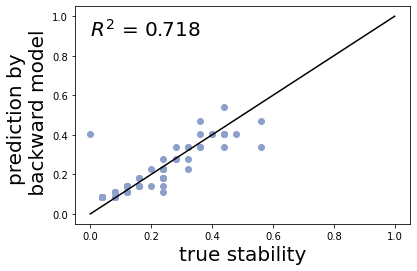

In [106]:
plt.scatter(df.iloc[:, 0], backward_model.predict(df.iloc[:, 1:]), color='#8da0cb', alpha=1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('true stability', fontsize=20)
plt.ylabel('prediction by \n backward model', fontsize=20)
R2=r2_score(df.iloc[:, 0], backward_model.predict(df.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('backward1_control.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

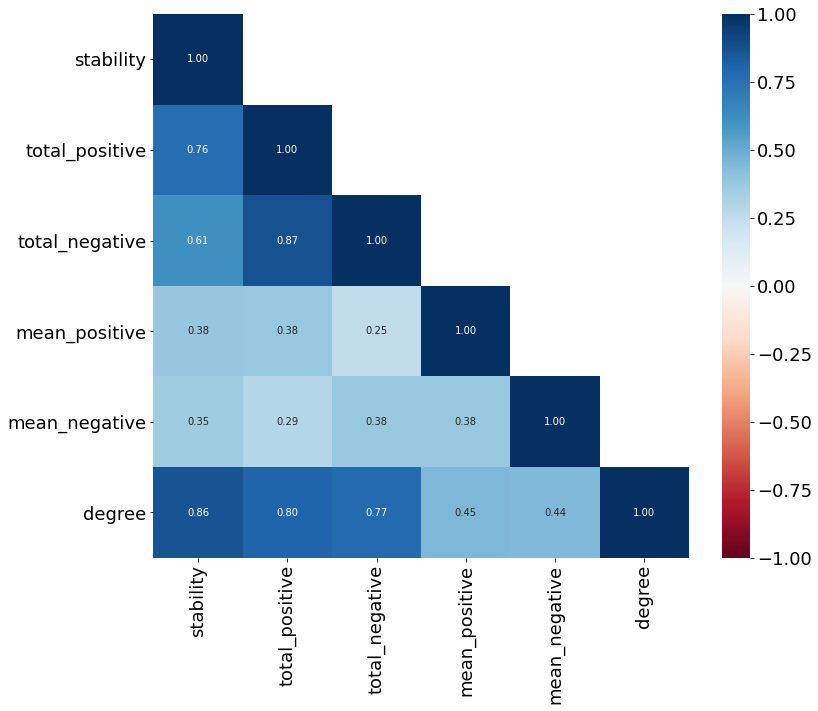

In [115]:
f, ax = plt.subplots(figsize=(12, 10))
corr=df.corr() #pearson corr.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
mask=mask-np.eye(np.size(corr, axis=0))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax=sns.heatmap(corr, vmin=-1, vmax=1,annot=True,fmt='.2f',mask=mask, cmap="RdBu")
ax.tick_params(axis='both', which='major', rotation =90, labelsize=18)
plt.yticks(rotation=0)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=18)
plt.savefig('Feature_PearsonCorr_control.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

# Unintuitive features
There are some features that are not clear why they affect the stability, R. invasion, or R. to environmental change
1. In control: why degree matter?
2. In design: why total_positive/negative_trans affect R. invasion? => See below + total_positive_trans are correlated with total negative_trans
3. In design: why total_positive/negative_upaffect R. invasion? => intuition: related to total  negative trans (invasion from up to down)

                            OLS Regression Results                            
Dep. Variable:                 degree   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     57.06
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           2.47e-14
Time:                        08:33:47   Log-Likelihood:                -110.03
No. Observations:                  60   AIC:                             226.1
Df Residuals:                      57   BIC:                             232.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.4833      0.201     17.

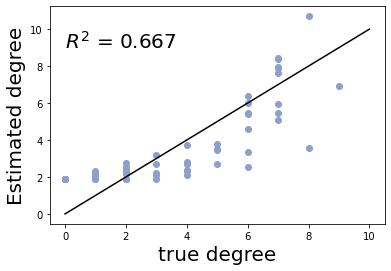

In [199]:
# 1. control model
# Degree would correlate with total_positive and negative
# standarize
#standarize
y=df.iloc[:, -1] # target
X=df.iloc[:, 1:3] # features but ignore index, resistance to invasion/environmental change
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =df.columns[1:3])
df_control=pd.concat((y, Xss), axis=1).fillna(0)

model=smf.ols('degree ~ total_negative +total_positive ', df_control).fit()
print(model.summary())
plt.scatter(df_control.iloc[:, 0], model.predict(df_control.iloc[:, 1:3]), color='#8da0cb', alpha=1)
plt.plot(np.linspace(0, 10, 101), np.linspace(0, 10, 101), color='k')
plt.xlabel('true degree', fontsize=20)
plt.ylabel('Estimated degree', fontsize=20)
R2=r2_score(df_control.iloc[:, 0], model.predict(df_control.iloc[:, 1:3]))
plt.text(x=0.0, y=9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Degree_vs_TotalsPositiveNegative_control.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

It seems that degree summarize the total positive and total negative. Are these two related to resistance to invasion? Check literature later

In [204]:
# 2. desgin model
#total_positive_trans_down correlates with donstream features
model=smf.ols('total_positive_trans ~ total_negative_down +total_positive_down + degree_down', df_design).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     total_positive_trans   R-squared:                       0.612
Model:                              OLS   Adj. R-squared:                  0.612
Method:                   Least Squares   F-statistic:                     9963.
Date:                  Tue, 15 Mar 2022   Prob (F-statistic):               0.00
Time:                          08:42:46   Log-Likelihood:                -17882.
No. Observations:                 18922   AIC:                         3.577e+04
Df Residuals:                     18918   BIC:                         3.580e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

In [236]:
model2=smf.logit('stability ~ rho+mu+degree_trans+total_negative_trans', df_design).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.560793
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              stability   No. Observations:                18922
Model:                          Logit   Df Residuals:                    18917
Method:                           MLE   Df Model:                            4
Date:                Tue, 15 Mar 2022   Pseudo R-squ.:                0.002331
Time:                        09:11:49   Log-Likelihood:                -10611.
converged:                       True   LL-Null:                       -10636.
Covariance Type:            nonrobust   LLR p-value:                 4.408e-10
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5184      0.016     32.393      0.000       0.487       0.550
rho                      0.7092      0.017     42.744      0.000       0.677       0.742
mu                      -0.0567      0.016     -3.609      0.000      -0.087      -0.026
degree_trans            -0.0020      0.017     -0.121      0.903      -0.035       0.031
total_negative_trans     0.0545      0.017      3.272      0.001       0.022       0.087
========================================================================================
"""

In [237]:
[backward_model.aic, model2.aic]

[21191.548452686555, 21232.640999909447]

In [241]:
smf.logit('resistance_invasion ~ total_negative_trans+ total_negative_up+total_positive_trans', df_design).fit().summary()

Optimization terminated successfully.
         Current function value: 0.465742
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     resistance_invasion   No. Observations:                18922
Model:                           Logit   Df Residuals:                    18918
Method:                            MLE   Df Model:                            3
Date:                 Tue, 15 Mar 2022   Pseudo R-squ.:                  -2.377
Time:                         09:15:44   Log-Likelihood:                -8812.8
converged:                        True   LL-Null:                       -2609.4
Covariance Type:             nonrobust   LLR p-value:                     1.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.1014      0.017    -65.336      0.000      -1.134      -1.068
total_negative_trans     0.0707      0.023      3.078      0.002       0.026       0.116
total_negative_up        0.0461      0.017      2.642      0.008       0.012       0.080
total_positive_trans     0.0738      0.023      3.162      0.002       0.028       0.120
========================================================================================
"""

## Interpretation

total_positive_up => preventing invasion from upstream to downstream . corr with total negative trans
total_positive_trans => helping resident species in the downstream.
Let's confirm the first point

In [326]:
# check 1st point: Claculate the fraction of succesful nvasion from up to down
# note remove data of mu=0 (no migration from up to down)

data=FullData(scenario=1)

In [327]:
import os
import numpy as np
from scipy.integrate import solve_ivp 

def Comp(x):
    # comver abundance data into composition data
    # x should be 1dim array of species abundances
    return x>pow(10, -5)

def ODE_structured(t,x,  r_up, r_down, A):
    # note that -A represents intertaction matrix
    dx=np.zeros([np.size(x)])
    N_up=np.size(r_up)
    N_down=np.size(r_down)
    for i in range(N_up):
        # upstream community
        if x[i]>pow(10, -6):
            dx[i] = x[i]*(r_up[i] + np.dot(A[i, :], x[:N_up]))
    for i in range(N_down):
        if x[i+N_up]>pow(10, -6):
            dx[i+N_up]=x[i+N_up]*(r_down[i]+np.dot(A[i, :], x[:N_up]) + np.dot( A[i, :N_down], x[N_up:]))
    return dx
def InvasionGrowth(r_up, r_down, i, A, x):
    N=np.size(r_down)
    inv=np.zeros([2*N])
    inv[i+N]=0.01
    sol=solve_ivp(ODE_structured, [0, 300], y0=x+inv, 
                method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                args=[r_up, r_down, A])# ODE
    sol_last=sol.y[N+i, -1] #wheter invader
    return sol_last>pow(10, -5)
    
    
def InvasionUpDown(r_up, r_down,A, X_up, x_down):
    # run the communiy at equillium
    x=np.concatenate((X_up*0.01, x_down))
    sol=solve_ivp(ODE_structured, [0, 300], y0=x, 
                method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                args=[r_up, r_down, A])# ODE
    sol_last=sol.y[:, -1]
    for k in range(np.size(sol_last)):
            if sol_last[k]<pow(10, -6):
                sol_last[k]=0.0
    invasion_success=0
    N=np.size(X_up)
    count=0
    # we consider only the case when i exist in upstream but not in downstream
    for i in range(N):
        if X_up[i]>0 and x_down[i]<pow(10,-5):  
            invasion_success+=InvasionGrowth(r_up, r_down, i, A, x)
            count+=1
    if count>0:
        return invasion_success/count
    else:
        return 0
def main():            
    
    c_list=[1.0, 0.5,0.25]
    mu_list=[0.0, 0.25, 0.5, 1.0, 2.0]
    rho_list=[0.0, 0.25, 0.5, 0.75, 1.0]
    
    success_invasion=[]
    for i in range(len(c_list)):
        connect=c_list[i]
        os.chdir('./connectance%.2f' %(connect))
        for j in range(20):
            os.chdir('./replicate%d'%(j)) 
            print([connect, j])
            A=-np.loadtxt('interaction.csv', delimiter=',')
            r_up=np.loadtxt('growthrate_up.csv', delimiter=',')
            r_down=np.loadtxt('growthrate_down.csv', delimiter=',')
            for k in range(len(rho_list)):
                rho=rho_list[k]
                for l in range(len(mu_list)):
                    mu=mu_list[l]
                    os.chdir('./rho%.2f_mu%.2f/designing2' %(rho, mu))
                    x_down=np.loadtxt('target_down.csv', delimiter=',')
                    X_up=np.loadtxt('upstream_community.csv', delimiter=',')
                    stability=np.loadtxt('stability_new.csv', delimiter=',')
                    for s in range(len(stability)):
                        #print(s)
                        if np.isnan(stability[s])==False:
                            inv=InvasionUpDown(r_up, r_down,A, X_up[s, :], x_down)
                            success_invasion.append(inv)
                    os.chdir('../../')
            os.chdir('../')
        os.chdir('../')
    return success_invasion
success_invasion=main()
data['InvasionUpDown']=success_invasion

[1.0, 0]
[1.0, 1]
[1.0, 2]
[1.0, 3]
[1.0, 4]
[1.0, 5]
[1.0, 6]
[1.0, 7]
[1.0, 8]
[1.0, 9]
[1.0, 10]
[1.0, 11]
[1.0, 12]
[1.0, 13]
[1.0, 14]
[1.0, 15]
[1.0, 16]
[1.0, 17]
[1.0, 18]
[1.0, 19]
[0.5, 0]
[0.5, 1]
[0.5, 2]
[0.5, 3]
[0.5, 4]
[0.5, 5]
[0.5, 6]
[0.5, 7]
[0.5, 8]
[0.5, 9]
[0.5, 10]
[0.5, 11]
[0.5, 12]
[0.5, 13]
[0.5, 14]
[0.5, 15]
[0.5, 16]
[0.5, 17]
[0.5, 18]
[0.5, 19]
[0.25, 0]
[0.25, 1]
[0.25, 2]
[0.25, 3]
[0.25, 4]
[0.25, 5]
[0.25, 6]
[0.25, 7]
[0.25, 8]
[0.25, 9]
[0.25, 10]
[0.25, 11]
[0.25, 12]
[0.25, 13]
[0.25, 14]
[0.25, 15]
[0.25, 16]
[0.25, 17]
[0.25, 18]
[0.25, 19]


[0.010473255142253095, 0.14969302218748418]


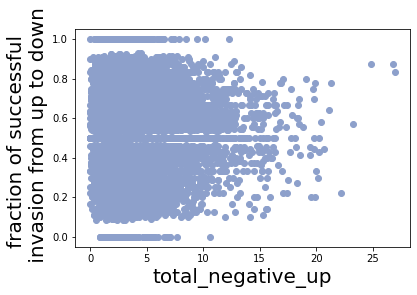

In [329]:


plt.scatter(data['total_negative_up'], data['InvasionUpDown'], color='#8da0cb', alpha=1)
plt.xlabel('total_negative_up', fontsize=20)
plt.ylabel('fraction of successful \n invasion from up to down', fontsize=20)
[r, p]=sp.stats.pearsonr(data['InvasionUpDown'], data['total_negative_up'])
print([r, p])
#plt.text(x=0.0, y=9, s=str('$r$ = %.3f' %(r)), fontsize=20)
#plt.gca().set_rasterized(True)
#plt.savefig('InvasionUpDow_TotNegUp.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

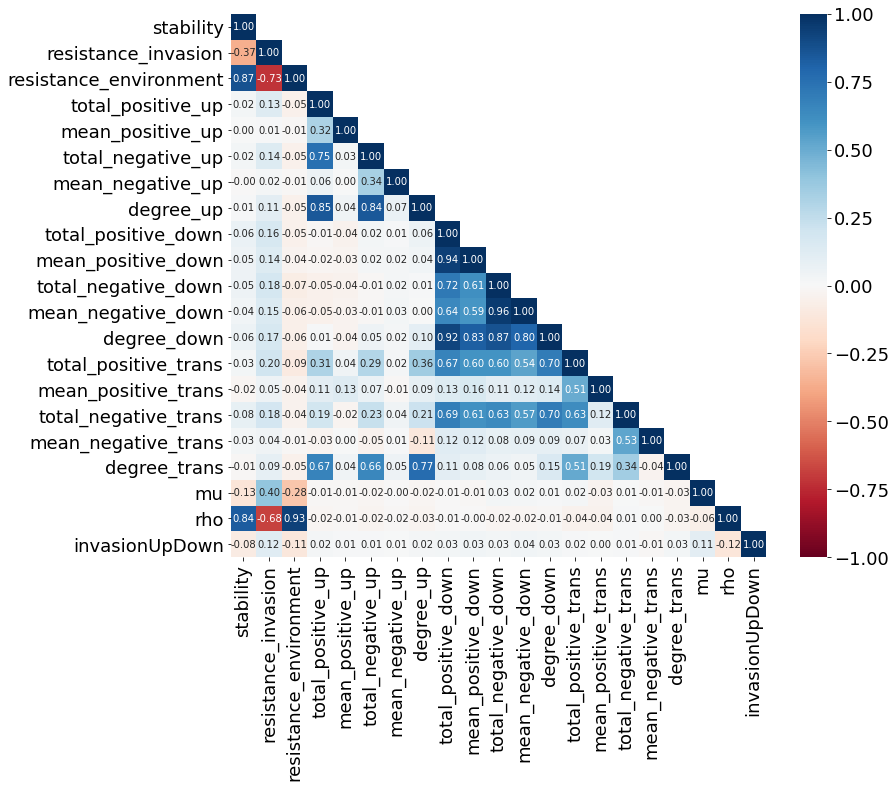

In [306]:
f, ax = plt.subplots(figsize=(12, 10))
corr=data.corr('spearman') #pearson corr.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
mask=mask-np.eye(np.size(corr, axis=0))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax=sns.heatmap(corr, vmin=-1, vmax=1,annot=True,fmt='.2f',mask=mask, cmap="RdBu")
ax.tick_params(axis='both', which='major', rotation =90, labelsize=18)
plt.yticks(rotation=0)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=18)
#plt.savefig('Feature_PearsonCorr_control.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

The intiution was wrong. Maybe summerizing removed features?

                             OLS Regression Results                             
Dep. Variable:     total_positive_trans   R-squared:                       0.612
Model:                              OLS   Adj. R-squared:                  0.612
Method:                   Least Squares   F-statistic:                     9963.
Date:                  Thu, 17 Mar 2022   Prob (F-statistic):               0.00
Time:                          08:24:59   Log-Likelihood:                -20317.
No. Observations:                 18922   AIC:                         4.064e+04
Df Residuals:                     18918   BIC:                         4.067e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

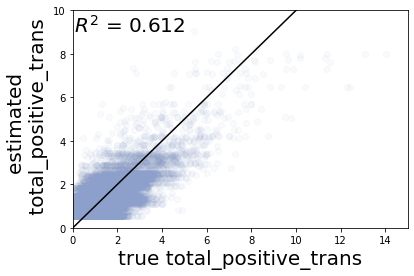

In [356]:
#NOTE using non-standarized data
model1=smf.ols('total_positive_trans ~ total_positive_down + total_negative_down + degree_down', data).fit()
print(model1.summary())
plt.scatter(data[['total_positive_trans']], model1.predict(data[['total_positive_down', 'total_negative_down', 'degree_down']]), 
            color='#8da0cb', alpha=0.05)
plt.plot(np.linspace(0, 15, 101), np.linspace(0, 15, 101), color='k')
plt.xlabel('true total_positive_trans', fontsize=20)
plt.ylabel('estimated \n total_positive_trans', fontsize=20)
plt.ylim(0, 10)
plt.xlim(0, 15)
plt.text(x=0.05, y=9, s=str('$R^2$ = %.3f' %(0.612)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('TotalPositiveTrans_TotalPositivenEgativeDown.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

In [416]:
m1=smf.logit('resistance_invasion ~ degree_trans+mu +rho + total_negative_up +  total_positive_trans',df_design).fit()
print(m1.summary())
print(m1.aic)


Optimization terminated successfully.
         Current function value: 0.428231
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     resistance_invasion   No. Observations:                18922
Model:                           Logit   Df Residuals:                    18916
Method:                            MLE   Df Model:                            5
Date:                 Thu, 17 Mar 2022   Pseudo R-squ.:                  -2.105
Time:                         10:19:34   Log-Likelihood:                -8103.0
converged:                        True   LL-Null:                       -2609.4
Covariance Type:             nonrobust   LLR p-value:                     1.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.2055      0.018    -65.511      0.000      -1.242    

In [421]:
m2=smf.logit('resistance_invasion ~ mu +rho + total_negative_up+degree_down',df_design).fit()
print(m2.summary())
print(m2.aic)

Optimization terminated successfully.
         Current function value: 0.428739
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     resistance_invasion   No. Observations:                18922
Model:                           Logit   Df Residuals:                    18917
Method:                            MLE   Df Model:                            4
Date:                 Thu, 17 Mar 2022   Pseudo R-squ.:                  -2.109
Time:                         10:22:26   Log-Likelihood:                -8112.6
converged:                        True   LL-Null:                       -2609.4
Covariance Type:             nonrobust   LLR p-value:                     1.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2043      0.018    -65.511      0.000      -1.240      -1.168


As we can see above, total_positive_trans summarizes the downstream interactions (maybe related to coexistance ?), which is also supported by the heatmap.

Next, do the similar analysis for total_negative_up

                            OLS Regression Results                            
Dep. Variable:      total_negative_up   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                 2.723e+04
Date:                Thu, 17 Mar 2022   Prob (F-statistic):               0.00
Time:                        08:56:26   Log-Likelihood:                -36060.
No. Observations:               18922   AIC:                         7.212e+04
Df Residuals:                   18920   BIC:                         7.214e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2484      0.024     10.475   

Text(0, 0.5, 'estimated \n total_negative_up')

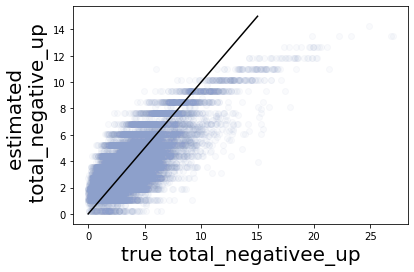

In [360]:
model=smf.ols('total_negative_up ~ degree_trans', data).fit()
print(model.summary())
plt.scatter(data[['total_negative_up']], model.predict(data[['degree_trans']]), 
            color='#8da0cb', alpha=0.05)
plt.plot(np.linspace(0, 15, 101), np.linspace(0, 15, 101), color='k')
plt.xlabel('true total_negativee_up', fontsize=20)
plt.ylabel('estimated \n total_negative_up', fontsize=20)

total_negative_up correlates with degree_trans=> We can inrase total_negative_up?

In [371]:
backward_model2a=smf.logit('resistance_invasion ~ total_negative_up'+
               '+mu +rho +  total_positive_trans', df_design).fit()
print(backward_model2a.summary())
print([backward_model2a.aic,backward_model2a.bic])# AICand BIC

Optimization terminated successfully.
         Current function value: 0.428779
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     resistance_invasion   No. Observations:                18922
Model:                           Logit   Df Residuals:                    18917
Method:                            MLE   Df Model:                            4
Date:                 Thu, 17 Mar 2022   Pseudo R-squ.:                  -2.109
Time:                         09:03:04   Log-Likelihood:                -8113.4
converged:                        True   LL-Null:                       -2609.4
Covariance Type:             nonrobust   LLR p-value:                     1.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.2045      0.018    -65.506      0.000      -1.241    

In [372]:
backward_model2b=smf.logit('resistance_invasion ~ degree_trans'+
               '+mu +rho +  total_positive_trans',df_design).fit()
print(backward_model2b.summary())
print([backward_model2b.aic,backward_model2b.bic])# AICand BIC

Optimization terminated successfully.
         Current function value: 0.429093
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     resistance_invasion   No. Observations:                18922
Model:                           Logit   Df Residuals:                    18917
Method:                            MLE   Df Model:                            4
Date:                 Thu, 17 Mar 2022   Pseudo R-squ.:                  -2.112
Time:                         09:03:19   Log-Likelihood:                -8119.3
converged:                        True   LL-Null:                       -2609.4
Covariance Type:             nonrobust   LLR p-value:                     1.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.2038      0.018    -65.505      0.000      -1.240    

In [373]:
backward_model2c=smf.logit('resistance_invasion ~ degree_trans + total_negative_up'+
               '+mu +rho +  total_positive_trans',df_design).fit()
print(backward_model2c.summary())
print([backward_model2c.aic,backward_model2c.bic])# AICand BIC

Optimization terminated successfully.
         Current function value: 0.428231
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     resistance_invasion   No. Observations:                18922
Model:                           Logit   Df Residuals:                    18916
Method:                            MLE   Df Model:                            5
Date:                 Thu, 17 Mar 2022   Pseudo R-squ.:                  -2.105
Time:                         09:04:03   Log-Likelihood:                -8103.0
converged:                        True   LL-Null:                       -2609.4
Covariance Type:             nonrobust   LLR p-value:                     1.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.2055      0.018    -65.511      0.000      -1.242    

In [383]:
smf.logit('resistance_environment ~ total_negative_up+total_positive_trans+degree_trans+mu + rho' ,df_design).fit().summary()

Optimization terminated successfully.
         Current function value: 0.395336
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                             
==================================================================================
Dep. Variable:     resistance_environment   No. Observations:                18922
Model:                              Logit   Df Residuals:                    18916
Method:                               MLE   Df Model:                            5
Date:                    Thu, 17 Mar 2022   Pseudo R-squ.:                  0.3328
Time:                            09:17:33   Log-Likelihood:                -7480.6
converged:                           True   LL-Null:                       -11211.
Covariance Type:                nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.8466      0.020    -42.566      0.000      -0.886      -0.808
total_negative_up       -0.0273      0.029     -0.938      0.348      -0.084       0.030
total_positive_trans    -0.0595      0.021     -2.796      0.005      -0.101      -0.018
degree_trans             0.0086      0.031      0.281      0.779      -0.052       0.069
mu                      -0.4275      0.020    -21.911      0.000      -0.466      -0.389
rho                      1.4517      0.022     65.245      0.000       1.408       1.495
========================================================================================
"""

# Consider logics:
Let's introduce richness again. Richness increases the total positive/negative interactions and mean degree. Literature suggests that richness increases resistance to the invasion because higher species decreases resource availability

Go back to the control case with richness data

In [14]:
os.chdir('../')
df_control=pd.read_csv('design_control.csv')

# read richnes data
c_list=[1.00,0.5, 0.25]
rho=0.0
mu=0.0
rich=[]
for i in range(len(c_list)):
    connect=c_list[i]
    os.chdir(str('./connectance%.2f' %(connect)))
    for j in range(20):
        os.chdir('./replicate%d/rho%.2f_mu%.2f/designing2' %(j, rho, mu))
        down=np.loadtxt('target_down.csv', delimiter=',')
        richness=np.sum(down>0)
        rich.append(richness)
        os.chdir('../../../')
    os.chdir('../')
#rich

In [17]:
df_control['richness']=rich
df_control.to_csv('design_control.csv', index=False)
df_control

stability  total_positive  total_negative  mean_positive  mean_negative  \
0        0.56        8.989858        6.613960       0.236575       0.194528   
1        0.12        0.472694        0.000000       0.236347       0.000000   
2        0.12        0.640973        0.220492       0.213658       0.073497   
3        0.12        0.000000        1.065341       0.000000       0.532671   
4        0.32        3.090687        3.570353       0.140486       0.178518   
5        0.24        1.990735        1.237858       0.142195       0.206310   
6        0.12        0.903596        0.715616       0.301199       0.238539   
7        0.36        3.170188        3.351005       0.137834       0.176369   
8        0.08        0.000000        0.000000       0.000000       0.000000   
9        0.32        3.196669        4.647753       0.199792       0.178760   
10       0.36        5.501314        6.682279       0.189700       0.247492   
11       0.24        1.276734        1.058844       0.182391       0.211769   
12       0.04        0.000000        0.000000       0.000000       0.000000   
13       0.08        0.000000        0.532479       0.000000       0.266240   
14       0.44        6.203122        5.730641       0.200101       0.229226   
15       0.48        7.176186        2.860142       0.205034       0.136197   
16       0.40        4.336854        6.652299       0.197130       0.195656   
17       0.04        0.000000        0.000000       0.000000       0.000000   
18       0.00        4.913418        6.604123       0.188978       0.220137   
19       0.56        5.337039        2.198738       0.205271       0.137421   
20       0.24        0.937368        0.101801       0.468684       0.101801   
21       0.16        0.000000        0.925768       0.000000       0.231442   
22       0.04        0.000000        0.000000       0.000000       0.000000   
23       0.44        4.666459        4.467789       0.160912       0.186158   
24       0.16        0.787800        0.000000       0.196950       0.000000   
25       0.24        0.924939        0.735800       0.308313       0.122633   
26       0.40        2.274820        3.899076       0.174986       0.243692   
27       0.32        1.825141        0.979967       0.260734       0.244992   
28       0.44        2.659894        2.257038       0.241809       0.205185   
29       0.24        0.072174        0.471027       0.036087       0.157009   
30       0.44        4.469795        2.524085       0.212847       0.210340   
31       0.28        1.376194        1.537239       0.229366       0.170804   
32       0.04        0.000000        0.000000       0.000000       0.000000   
33       0.24        0.000000        0.072267       0.000000       0.072267   
34       0.08        0.000000        0.000000       0.000000       0.000000   
35       0.20        0.193567        0.347140       0.193567       0.347140   
36       0.20        0.759407        0.786241       0.151881       0.196560   
37       0.24        0.360574        0.536445       0.072115       0.178815   
38       0.44        3.524949        2.860697       0.234997       0.158928   
39       0.32        0.466253        0.432073       0.116563       0.108018   
40       0.28        1.106956        0.181223       0.276739       0.181223   
41       0.08        0.383607        0.114165       0.383607       0.114165   
42       0.36        1.694706        1.314045       0.169471       0.219007   
43       0.36        0.765662        0.401049       0.127610       0.133683   
44       0.08        0.000000        0.000000       0.000000       0.000000   
45       0.12        0.000000        0.000000       0.000000       0.000000   
46       0.04        0.000000        0.000000       0.000000       0.000000   
47       0.16        0.419979        0.110331       0.419979       0.110331   
48       0.16        0.000000        0.000000       0.000000       0.000000   
49       0.12        0.415361        0.389966       0.

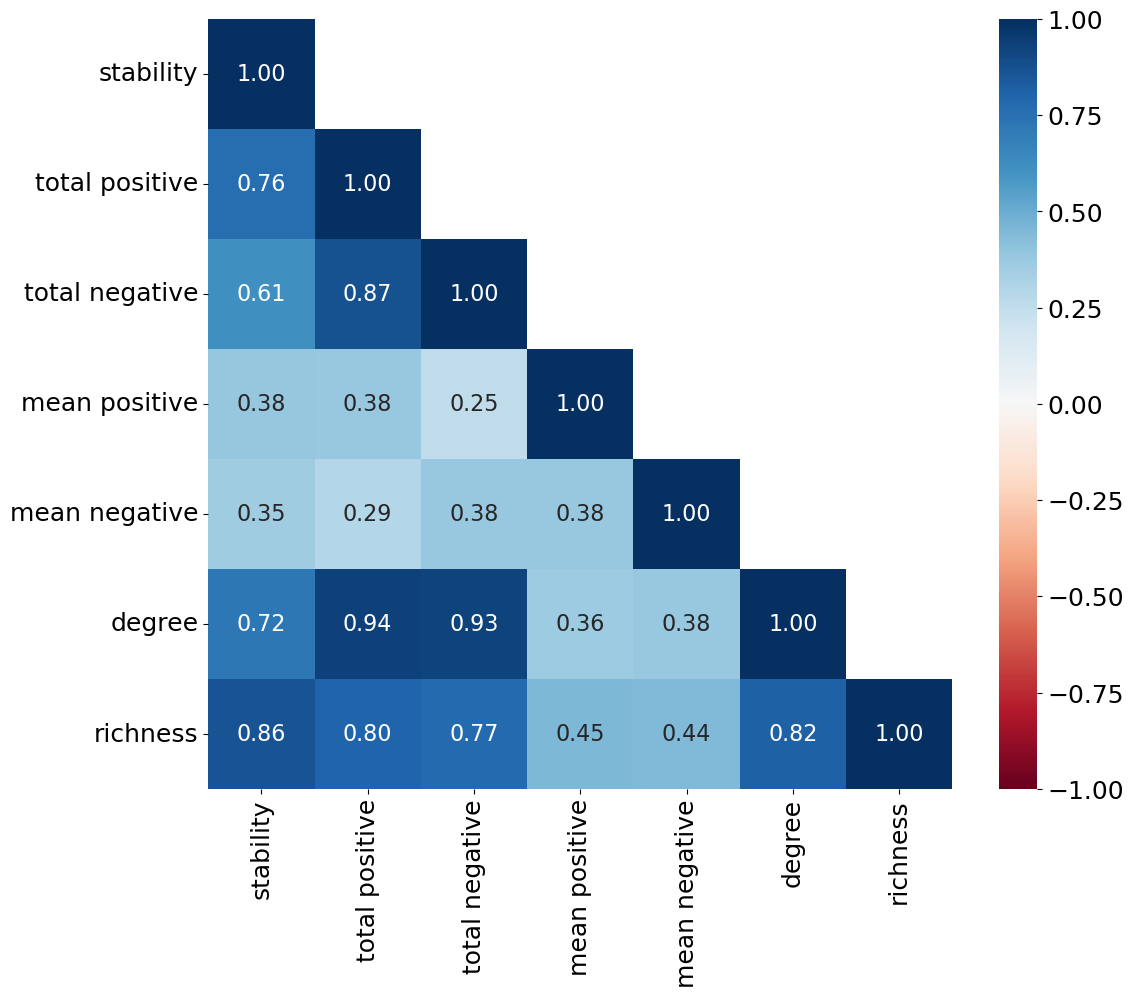

In [18]:
df_control=pd.read_csv("design_control.csv")
f, ax = plt.subplots(figsize=(12, 10))
corr=df_control.corr() #pearson corr.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
mask=mask-np.eye(np.size(corr, axis=0))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax=sns.heatmap(corr, vmin=-1, vmax=1,annot=True,fmt='.2f',mask=mask, cmap="RdBu",annot_kws={"size": 16})
ax.tick_params(axis='both', which='major', rotation =90, labelsize=18)
plt.yticks(rotation=0)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=18)
plt.savefig('Feature_PearsonCorr_control.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

Optimization terminated successfully.
         Current function value: 0.381255
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                   60
Model:                          Logit   Df Residuals:                       58
Method:                           MLE   Df Model:                            1
Date:                Mon, 26 Sep 2022   Pseudo R-squ.:                  -3.375
Time:                        16:42:33   Log-Likelihood:                -22.875
converged:                       True   LL-Null:                       -5.2291
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6444      0.774     -3.417      0.001      -4.161      -1.127
richness       0.2813      0.

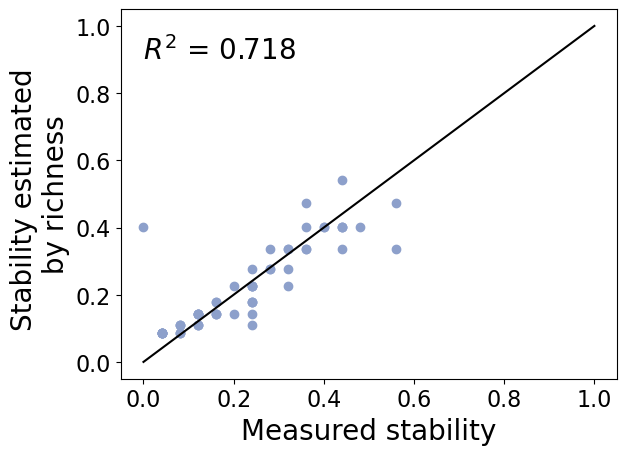

In [19]:
from sklearn.metrics import r2_score
model=smf.logit('stability~richness', df_control).fit()
print(model.summary())
plt.scatter(df_control[['stability']], model.predict(df_control[['richness']]), 
            color='#8da0cb', alpha=1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('Measured stability', fontsize=20)
plt.ylabel('Stability estimated \n by richness ', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
R2=r2_score(df_control[['stability']], model.predict(df_control[['richness']]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
#plt.gca().set_rasterized(True)
plt.savefig('COntrol_Stability_EstimatedByRichness.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

In [7]:
print(smf.logit('stability~degree', df_control).fit().summary())
print(smf.logit('stability~total_positive', df_control).fit().summary())
print(smf.logit('stability~total_negative', df_control).fit().summary())
print(smf.logit('stability~richness+total_positive+total_negative', df_control).fit().summary())
print(smf.logit('stability~degree+total_positive+total_negative', df_control).fit().summary())
print(smf.logit('stability~richness+degree+total_positive+total_negative', df_control).fit().summary())

Optimization terminated successfully.
         Current function value: 0.391964
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                   60
Model:                          Logit   Df Residuals:                       58
Method:                           MLE   Df Model:                            1
Date:                Tue, 22 Mar 2022   Pseudo R-squ.:                  -3.498
Time:                        09:37:19   Log-Likelihood:                -23.518
converged:                       True   LL-Null:                       -5.2291
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8201      0.474     -3.841      0.000      -2.749      -0.891
degree         0.2308      0.

Yes. the richnes seems important than others (in AIC)

## Causality

Richness-> total_positive/negative 
positve/negative_up +R_down => positive/negative_trans => R_envinv => stability
1. R_up +R_down + rho + mu (effect of R_up)
2. 1+ total_positive/negative_up
3. 2+ total_positive/negative_trans

=>only total_positive_trans matter when we considering richness_down, rho and mu


In [77]:
from graphviz import Graph
from graphviz import Digraph
g=Digraph()
g.attr('node', shape='plain')
with g.subgraph() as s:
    s.attr(rank='same')
    s.node('richness_up', fontcolor='#8da0cb')
    s.node('richness_down')

with g.subgraph() as s:
    s.attr(rank='same')
    s.node('total_positive_up',fontcolor='#8da0cb')
    s.node('total_negative_up',fontcolor='#8da0cb')
    s.node('degree_up')
    s.node('total_positive_down')
    s.node('total_negative_down')
    s.node('degree_down')
with g.subgraph() as s:
    s.attr(rank='same')
    s.node('total_positive_trans',fontcolor='#8da0cb')
    s.node('total_negative_trans',fontcolor='#8da0cb')
    s.node('degree_trans')
with g.subgraph() as s:
    s.attr(rank='same')    
    s.node(r'mu')
    s.node(r'rho')
    s.attr('node', shape='box')
    s.node('resistance_invasion_up') # not sampled

g.node('stability')
g.node('resistance_env.change')
g.node('resistance_invasion_down')




g.attr('node', shape='box')
g.node('resistance_invasion_up') # not sampled

g.edge('resistance_env.change','stability')
g.edge('resistance_invasion_down','stability')
g.edge('resistance_invasion_up','resistance_env.change')
#g.edge('richness_down', 'resistance_invasion_down')
#g.edge('richness_up', 'resistance_invasion_up')
g.edge('richness_up', 'total_positive_up')
g.edge('richness_up', 'total_negative_up')
g.edge('richness_up', 'degree_up')
g.edge('richness_up', 'total_positive_trans')
g.edge('richness_up', 'total_negative_trans')
g.edge('richness_down', 'total_positive_trans')
g.edge('richness_down', 'total_negative_trans')
g.edge('richness_up', 'degree_trans')
g.edge('richness_down', 'degree_trans')
g.edge('total_positive_up', 'resistance_invasion_up')
g.edge('total_negative_up', 'resistance_invasion_up')
#g.edge('total_positive_up', 'total_positive_trans')
#g.edge('total_negative_up', 'total_negative_trans')
g.edge('richness_down', 'total_positive_down')
g.edge('richness_down', 'total_negative_down')
g.edge('richness_down', 'degree_down')
g.edge('total_positive_down', 'resistance_invasion_down')
g.edge('total_negative_down', 'resistance_invasion_down')
#g.edge('degree_up', 'degree_trans')
g.edge('total_positive_trans', 'resistance_env.change')
g.edge('total_negative_trans', 'resistance_env.change')
g.edge('total_positive_trans', 'resistance_invasion_down')
g.edge('total_negative_trans', 'resistance_invasion_down')
g.edge('mu', 'resistance_env.change')
g.edge('mu', 'resistance_invasion_down')
g.edge('rho', 'resistance_env.change')
g.edge('rho', 'resistance_invasion_down')
g.render('./DAG_full')
g.view()

'DAG_full.pdf'

In [79]:
g=Digraph()
g.attr('node', shape='plain')
with g.subgraph() as s:
    s.attr(rank='same')
    s.node('richness_up', fontcolor='#8da0cb')
    s.node('richness_down')
    s.node(r'mu')
    s.node(r'rho')
with g.subgraph() as s:
    s.attr(rank='same')
    s.node('total_positive_up',fontcolor='#8da0cb')
    s.node('total_negative_up',fontcolor='#8da0cb')
with g.subgraph() as s:
    s.attr(rank='same')
    s.node('total_positive_trans',fontcolor='#8da0cb')
    s.node('total_negative_trans',fontcolor='#8da0cb')

g.node('stability')

g.edge('richness_up', 'total_positive_up')
g.edge('richness_up', 'total_negative_up')
g.edge('richness_up', 'total_positive_trans')
g.edge('richness_up', 'total_negative_trans')
g.edge('total_positive_up', 'stability')
g.edge('total_negative_up', 'stability')
g.edge('richness_down', 'total_positive_trans')
g.edge('richness_down', 'total_negative_trans')
#g.edge('total_positive_up', 'total_positive_trans')
#g.edge('total_negative_up', 'total_negative_trans')
g.edge('total_positive_trans', 'stability')
g.edge('total_negative_trans', 'stability')
g.edge('richness_down', 'stability')
g.edge('rho', 'stability')
g.edge('mu', 'stability')
g.render('./DAG_simple')
g.view()

'DAG_simple.pdf'

In [450]:
data=FullData(scenario=1)
c_list=[1.0, 0.5, 0.25]
rho_list=[0.0, 0.25, 0.5, 0.75, 1.0]
mu_list=[0.0, 0.25, 0.5, 1.0, 2.0]
rich_up=[]
rich_down=[]
for i in range(len(c_list)):
    connect=c_list[i]
    for j in range(20):
        print([connect, j])
        for k in range(len(rho_list)):
            rho=rho_list[k]
            for l in range(len(mu_list)):
                mu=mu_list[l]
                path=str('./connectance%.2f/replicate%d/rho%.2f_mu%.2f/designing2' %(connect, j, rho, mu))
                os.chdir(path)
                rd=np.sum(np.loadtxt('target_down.csv', delimiter=',')>0)
                up=np.loadtxt('upstream_community.csv', delimiter=',')
                stability=np.loadtxt('stability_new.csv', delimiter=',')
                for m in range(len(stability)):
                    if np.isnan(stability[m])==False:
                        rich_down.append(rd)
                        rich_up.append(np.sum(up[m, :]>0))
                os.chdir('../../../../')
data['richness_up']=rich_up
data['richness_down']=rich_down            
data
    

[1.0, 0]
[1.0, 1]
[1.0, 2]
[1.0, 3]
[1.0, 4]
[1.0, 5]
[1.0, 6]
[1.0, 7]
[1.0, 8]
[1.0, 9]
[1.0, 10]
[1.0, 11]
[1.0, 12]
[1.0, 13]
[1.0, 14]
[1.0, 15]
[1.0, 16]
[1.0, 17]
[1.0, 18]
[1.0, 19]
[0.5, 0]
[0.5, 1]
[0.5, 2]
[0.5, 3]
[0.5, 4]
[0.5, 5]
[0.5, 6]
[0.5, 7]
[0.5, 8]
[0.5, 9]
[0.5, 10]
[0.5, 11]
[0.5, 12]
[0.5, 13]
[0.5, 14]
[0.5, 15]
[0.5, 16]
[0.5, 17]
[0.5, 18]
[0.5, 19]
[0.25, 0]
[0.25, 1]
[0.25, 2]
[0.25, 3]
[0.25, 4]
[0.25, 5]
[0.25, 6]
[0.25, 7]
[0.25, 8]
[0.25, 9]
[0.25, 10]
[0.25, 11]
[0.25, 12]
[0.25, 13]
[0.25, 14]
[0.25, 15]
[0.25, 16]
[0.25, 17]
[0.25, 18]
[0.25, 19]


stability  resistance_invasion  resistance_environment  \
0          0.560                0.560                   0.000   
1          0.560                0.560                   0.000   
2          0.560                0.560                   0.000   
3          0.680                0.680                   0.000   
4          0.440                0.440                   0.000   
...          ...                  ...                     ...   
18917      0.723                0.213                   0.510   
18918      0.756                0.222                   0.534   
18919      0.829                0.244                   0.585   
18920      0.800                0.267                   0.533   
18921      0.872                0.256                   0.616   

       total_positive_up  mean_positive_up  total_negative_up  \
0               4.956080          0.165203           8.339342   
1               6.447756          0.201492           5.975433   
2               8.930685          0.212635           9.372051   
3               6.585145          0.199550           4.071161   
4               3.609543          0.150398           4.737168   
...                  ...               ...                ...   
18917           2.426275          0.186637           3.078632   
18918           1.459154          0.182394           1.360817   
18919           1.606252          0.229465           1.767723   
18920           2.121835          0.235759           1.487906   
18921           0.888976          0.177795           1.733882   

       mean_negative_up  degree_up  total_positive_down  mean_positive_down  \
0              0.198556   8.000000             8.989858            0.236575   
1              0.248976   7.000000             8.989858            0.236575   
2              0.195251   9.000000             0.472694            0.236347   
3              0.177007   7.000000             0.472694            0.236347   
4              0.263176   6.000000             0.472694            0.236347   
...                 ...        ...                  ...                 ...   
18917          0.192415   2.636364             0.000000            0.000000   
18918          0.170102   1.600000             0.000000            0.000000   
18919          0.196414   2.000000             0.000000            0.000000   
18920          0.212558   1.600000             0.000000            0.000000   
18921          0.247697   1.714286             0.000000            0.000000   

       ...  degree_down  total_positive_trans  mean_positive_trans  \
0      ...          8.0              8.192365             0.195056   
1      ...          8.0              7.283204             0.227600   
2      ...          1.0              2.800859             0.254624   
3      ...          1.0              2.398799             0.239880   
4      ...          1.0              1.055754             0.175959   
...    ...          ...                   ...                  ...   
18917  ...          0.0              0.197899             0.197899   
18918  ...          0.0              0.000000             0.000000   
18919  ...          0.0              0.291191             0.145595   
18920  ...          0.0              0.291191             0.145595   
18921  ...          0.0              0.291191             0.145595   

       total_negative_trans  mean_negative_trans  degree_trans   mu  rho  \
0                  8.465661             0.217068           9.0  0.0  0.0   
1                 10.741641             0.268541           8.0  0.0  0.0   
2                  2.515296             0.279477          10.0  0.0  0.0   
3                  2.252321             0.375387           8.0  0.0  0.0   
4                  1.801725             0.225216           7.0  0.0  0.0   
...                     ...                  ...           ...  ...  ...   
18917              0.620855             0.155214           5.0  2.0  1.0   
18918              0.257820             0.12891

In [21]:
os.getcwd()

'/Users/shibasakishota/Desktop/スイス留学/Data/Project4/data'

In [51]:
data=pd.read_csv('design_data.csv')
#standarize
y=data.iloc[:, 0] # target
y2=data.iloc[:, 1:3]
X=data.iloc[:, 3:] # features but ignore index, resistance to invasion/environmental change
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =data.columns[3:])
df_design=pd.concat((y, y2, Xss), axis=1).fillna(0)
df_design# standaril data

stability  resistance_invasion  resistance_environment  \
0          0.560                0.560                   0.000   
1          0.560                0.560                   0.000   
2          0.560                0.560                   0.000   
3          0.680                0.680                   0.000   
4          0.440                0.440                   0.000   
...          ...                  ...                     ...   
18917      0.723                0.213                   0.510   
18918      0.756                0.222                   0.534   
18919      0.829                0.244                   0.585   
18920      0.800                0.267                   0.533   
18921      0.872                0.256                   0.616   

       total_positive_up  mean_positive_up  total_negative_up  \
0               1.849526          0.219242           0.347624   
1               0.919274          1.439328           0.890466   
2               2.255920          0.139275           1.794040   
3               0.169900         -0.302198           0.940464   
4               0.431989          1.782933          -0.142401   
...                  ...               ...                ...   
18917          -0.220683          0.070635          -0.573009   
18918          -0.896682         -0.469284          -0.924958   
18919          -0.736555          0.167407          -0.871427   
18920          -0.846670          0.558071          -0.683799   
18921          -0.749872          1.408380          -1.132454   

       mean_negative_up  degree_up  total_positive_down  mean_positive_down  \
0             -0.769937   2.220681            11.335954            0.995245   
1              0.075606   1.720004            11.335954            0.995245   
2              0.335235   2.721358            -0.492461           -0.700100   
3              0.030345   1.720004            -0.492461           -0.700100   
4             -1.114892   1.219327            -0.492461           -0.700100   
...                 ...        ...                  ...                 ...   
18917         -0.270532  -0.464767            -0.492461           -0.700100   
18918         -0.369377  -0.983650            -0.492461           -0.700100   
18919          0.727353  -0.783380            -0.492461           -0.700100   
18920          0.874022  -0.983650            -0.492461           -0.700100   
18921         -0.476534  -0.926430            -0.492461           -0.700100   

       ...  degree_down  total_positive_trans  mean_positive_trans  \
0      ...     7.690011              3.774293            -0.520468   
1      ...     7.690011              5.093681            -0.258572   
2      ...     0.307283              0.324859            -0.202927   
3      ...     0.307283              0.172412             0.285064   
4      ...     0.307283             -0.088799            -0.479013   
...    ...          ...                   ...                  ...   
18917  ...    -0.747393             -0.773351            -0.835186   
18918  ...    -0.747393             -0.983803            -0.969020   
18919  ...    -0.747393             -1.049105            -1.255599   
18920  ...    -0.747393             -0.713356             0.217836   
18921  ...    -0.747393             -0.989911            -0.366728   

       total_negative_trans  mean_negative_trans  degree_trans        mu  \
0                  6.162821             0.033989      2.071837 -1.073981   
1                  5.363451             0.369448      1.648605 -1.073981   
2                  1.422396             0.648003      2.495068 -1.073981   
3                  1.068889             0.496027      1.648605 -1.073981   
4                 -0.111969            -0.162865      1.225373 -1.073981   
...                     ...                  ...           ...       ...   
18917             -0.866229             0.063291      0.378909  1.722478   
18918             -1.040230            -1.97663

In [66]:
model1=smf.logit('stability ~richness_up+richness_down+rho+mu+rho', df_design).fit()
print(model1.summary())
print([model1.aic, model1.bic])
"""
#plt.scatter(df_design[['stability']], model1.predict(df_design[['richness_up']]), 
plt.scatter(df_design.query('rho>1.4')[['richness_up']], df_design.query('rho>1.4')[['stability']],
           color='#8da0cb', alpha=0.05)
#plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
x=pd.DataFrame({'richness_up':np.linspace(-4,4,101)})
plt.plot(x, model1.predict(x), color='k')
plt.xlabel('richness', fontsize=20)
plt.ylabel('stability', fontsize=20)
"""

Optimization terminated successfully.
         Current function value: 0.561350
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                18922
Model:                          Logit   Df Residuals:                    18917
Method:                           MLE   Df Model:                            4
Date:                Fri, 18 Mar 2022   Pseudo R-squ.:                0.001340
Time:                        13:17:25   Log-Likelihood:                -10622.
converged:                       True   LL-Null:                       -10636.
Covariance Type:            nonrobust   LLR p-value:                 9.851e-06
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5178      0.016     32.366      0.000       0.486       0.549
richness_up       0.

"\n#plt.scatter(df_design[['stability']], model1.predict(df_design[['richness_up']]), \nplt.scatter(df_design.query('rho>1.4')[['richness_up']], df_design.query('rho>1.4')[['stability']],\n           color='#8da0cb', alpha=0.05)\n#plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')\nx=pd.DataFrame({'richness_up':np.linspace(-4,4,101)})\nplt.plot(x, model1.predict(x), color='k')\nplt.xlabel('richness', fontsize=20)\nplt.ylabel('stability', fontsize=20)\n"

In [576]:
model2=smf.logit('stability ~richness_up+total_positive_up+total_negative_up+richness_down+rho+mu', df_design).fit()
print(model2.summary())
print([model2.aic, model2.bic])

Optimization terminated successfully.
         Current function value: 0.560883
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                18922
Model:                          Logit   Df Residuals:                    18915
Method:                           MLE   Df Model:                            6
Date:                Fri, 18 Mar 2022   Pseudo R-squ.:                0.002171
Time:                        09:16:35   Log-Likelihood:                -10613.
converged:                       True   LL-Null:                       -10636.
Covariance Type:            nonrobust   LLR p-value:                 2.715e-08
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.5181      0.016     32.374      0.000       0.487       0.549
richness

In [87]:
model3=smf.logit('stability ~richness_up+total_positive_up+total_negative_up'+
                 '+total_positive_trans+total_negative_trans+richness_down+mu+rho', 
                 df_design).fit()
print(model3.summary())
print([model3.aic, model3.bic])
model3b=smf.logit('stability ~richness_up+total_positive_trans+total_negative_trans+richness_down+rho+mu', 
                 df_design).fit()
print(model3b.summary())
print([model3b.aic, model3b.bic])
model3c=smf.logit('stability ~richness_up+total_positive_trans+richness_down+rho+mu', 
                 df_design).fit()
print(model3c.summary())
print([model3c.aic, model3c.bic])

Optimization terminated successfully.
         Current function value: 0.560269
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                18922
Model:                          Logit   Df Residuals:                    18913
Method:                           MLE   Df Model:                            8
Date:                Fri, 18 Mar 2022   Pseudo R-squ.:                0.003263
Time:                        14:25:34   Log-Likelihood:                -10601.
converged:                       True   LL-Null:                       -10636.
Covariance Type:            nonrobust   LLR p-value:                 6.456e-12
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5183      0.016     32.381      0.000       0.487       0.550

In [524]:
VIF_check(df_design[['richness_up', 'total_positive_trans', 'total_negative_trans', 'total_positive_up', 'total_positive_down' ]])

VIF Factor
0    1.000339
1    3.023023
2    2.252908
3    1.317401
4    2.591761

In [513]:
smf.logit('resistance_environment ~richness_up', df_design).fit().summary()

Optimization terminated successfully.
         Current function value: 0.627588
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                             
==================================================================================
Dep. Variable:     resistance_environment   No. Observations:                18922
Model:                              Logit   Df Residuals:                    18920
Method:                               MLE   Df Model:                            1
Date:                    Thu, 17 Mar 2022   Pseudo R-squ.:                -0.05922
Time:                            15:50:31   Log-Likelihood:                -11875.
converged:                           True   LL-Null:                       -11211.
Covariance Type:                nonrobust   LLR p-value:                     1.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.5671      0.015    -37.358      0.000      -0.597      -0.537
richness_up     0.1624      0.015     10.663      0.000       0.133       0.192
===============================================================================
"""

Summary from the caulaity
We can control five features: richness_up. total_positive_up, total_negative_up, total_positive_trans, and total_negative_trans.
From the above three analysis, we can see that richness_up and total_negative_trans increases the stability

Let go back to the prediction part

In [49]:
null_model=smf.logit('stability~1', df_design).fit()
print(null_model.summary())
print([null_model.aic, null_model.bic])

Optimization terminated successfully.
         Current function value: 0.646680
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                18922
Model:                          Logit   Df Residuals:                    18921
Method:                           MLE   Df Model:                            0
Date:                Mon, 26 Sep 2022   Pseudo R-squ.:                 -0.1505
Time:                        17:09:53   Log-Likelihood:                -12236.
converged:                       True   LL-Null:                       -10636.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4611      0.015     30.888      0.000       0.432       0.490
[24474.9638753173, 24482.8119

In [47]:
#Full model
full_model=smf.logit('stability ~  total_positive_up + mean_positive_up + total_negative_up +mean_negative_up + degree_up + richness_up'+
                     '+ total_positive_down + mean_positive_down + total_negative_down + mean_negative_down + degree_down + richness_down'+
                '+ total_positive_trans + mean_positive_trans + total_negative_trans + mean_negative_trans + degree_trans'+
               '+mu +rho', df_design).fit()
print(full_model.summary())
print([full_model.aic,full_model.aic])# AICand BIC



PatsyError: Error evaluating factor: NameError: name 'total_positive_trans' is not defined
    stability ~  total_positive_up + mean_positive_up + total_negative_up +mean_negative_up + degree_up + richness_up+ total_positive_down + mean_positive_down + total_negative_down + mean_negative_down + degree_down + richness_down+ total_positive_trans + mean_positive_trans + total_negative_trans + mean_negative_trans + degree_trans+mu +rho
                                                                                                                                                                                                                                          ^^^^^^^^^^^^^^^^^^^^

In [27]:
#vif check, full model2
#removing: degree_down->'degree_up'->
print(VIF_check(df_design[['total_positive_up','mean_positive_up', 'total_negative_up', 'mean_negative_up',
                'total_positive_down', 'mean_positive_down', 'total_negative_down', 'mean_negative_down',     
                'total_positive_trans', 'mean_positive_trans', 'total_negative_trans', 'mean_negative_trans','degree_trans', 
                'richness_up', 'richness_down', 'mu', 'rho' ]]))

full_model2=smf.logit('stability ~  total_positive_up + mean_positive_up + total_negative_up +mean_negative_up  + richness_up'+
                     '+ total_positive_down + mean_positive_down + total_negative_down + mean_negative_down  + richness_down'+
                '+ total_positive_trans + mean_positive_trans + total_negative_trans + mean_negative_trans + degree_trans'+
               '+mu +rho', df_design).fit()
print(full_model2.summary())
print([full_model2.aic,full_model2.aic])# AICand BIC


    VIF Factor
0     4.809490
1     1.182245
2     4.955575
3     1.209552
4     3.804187
5     1.833167
6     4.351388
7     1.954939
8     3.204845
9     1.280105
10    4.196822
11    1.263409
12    3.377631
13    1.037870
14    1.022520
15    1.017136
16    1.033293
Optimization terminated successfully.
         Current function value: 0.559326
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                18922
Model:                          Logit   Df Residuals:                    18904
Method:                           MLE   Df Model:                           17
Date:                Mon, 26 Sep 2022   Pseudo R-squ.:                0.004941
Time:                        16:55:42   Log-Likelihood:                -10584.
converged:                       True   LL-Null:                       -10636.
Covariance Type:            nonrobust   LLR p-value:                 1.002e

In [33]:
forward_model=forward_selected(df_design.drop(['resistance_invasion', 'resistance_environment'], axis=1), 'stability')
print(forward_model.summary())# which is identical to Full model
print([forward_model.aic, forward_model.bic])

Optimization terminated successfully.
         Current function value: 0.646651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.561463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646398
  

In [29]:
# forward model2 
#removing degree_up
print(VIF_check(df_design[['total_positive_up','mean_positive_up', 'total_negative_up', 'mean_negative_up',
                'total_positive_down',  'total_negative_down',     
                'total_positive_trans', 'mean_positive_trans', 'total_negative_trans', 'mean_negative_trans','degree_trans', 
                'richness_up', 'richness_down', 'mu', 'rho' ]]))
forward_model2=smf.logit('stability ~  total_positive_up + mean_positive_up + total_negative_up +mean_negative_up  + richness_up'+
                     '+ total_positive_down  + total_negative_down   + richness_down'+
                '+ total_positive_trans + mean_positive_trans + total_negative_trans + mean_negative_trans + degree_trans'+
               '+mu +rho', df_design).fit()
print(forward_model2.summary())
print([forward_model2.aic,forward_model2.aic])# AICand BIC

    VIF Factor
0     4.809431
1     1.181540
2     4.937089
3     1.209373
4     2.850125
5     3.543030
6     3.035525
7     1.273405
8     4.128536
9     1.257319
10    3.363818
11    1.037293
12    1.022208
13    1.016059
14    1.031545
Optimization terminated successfully.
         Current function value: 0.559330
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                18922
Model:                          Logit   Df Residuals:                    18906
Method:                           MLE   Df Model:                           15
Date:                Mon, 26 Sep 2022   Pseudo R-squ.:                0.004934
Time:                        16:55:59   Log-Likelihood:                -10584.
converged:                       True   LL-Null:                       -10636.
Covariance Type:            nonrobust   LLR p-value:                 1.493e-15
                          

In [35]:
#backward
#removing:mean_negative_up ->mean_positive_trans->total_positive_down->mean_positive_down
#degree_down-> richness_up ->total_positive_up -> mean_negative_down->richness_down
#mean_negative_trans->mean_positive_up -> total_negative_trans->total_negative_down
#degree_up 
backward_model=smf.logit('stability ~  total_negative_up '+
                '+ total_positive_trans   + degree_trans'+
               '+mu +rho', df_design).fit()
print(backward_model.summary())
print([backward_model.aic,backward_model.aic])# AICand BIC

Optimization terminated successfully.
         Current function value: 0.560110
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              stability   No. Observations:                18922
Model:                          Logit   Df Residuals:                    18916
Method:                           MLE   Df Model:                            5
Date:                Mon, 26 Sep 2022   Pseudo R-squ.:                0.003546
Time:                        16:59:20   Log-Likelihood:                -10598.
converged:                       True   LL-Null:                       -10636.
Covariance Type:            nonrobust   LLR p-value:                 7.539e-15
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5186      0.016     32.399      0.000       0.487       0.550

In [31]:
VIF_check(df_design[['total_negative_up', 'total_positive_trans', 'degree_trans', 'mu', 'rho' ]])

VIF Factor
0    2.503437
1    1.104946
2    2.607308
3    1.001924
4    1.001884

In [36]:
#AIC check
aics=[null_model.aic, full_model.aic, full_model2.aic, forward_model.aic, forward_model2.aic, backward_model.aic]
pd.DataFrame({'Models':['Null', 'Full_1', 'Full_2', 'Forward_1', 'Forward_2', 'Backward'], 
              'AIC':aics, 'DeltaAIC':aics-np.min(aics)}).sort_values('DeltaAIC')

Models           AIC     DeltaAIC
3  Forward_1  21196.763968     0.000000
4  Forward_2  21199.276110     2.512142
1     Full_1  21202.776371     6.012403
2     Full_2  21203.128459     6.364491
5   Backward  21208.788628    12.024660
0       Null  24474.963875  3278.199908

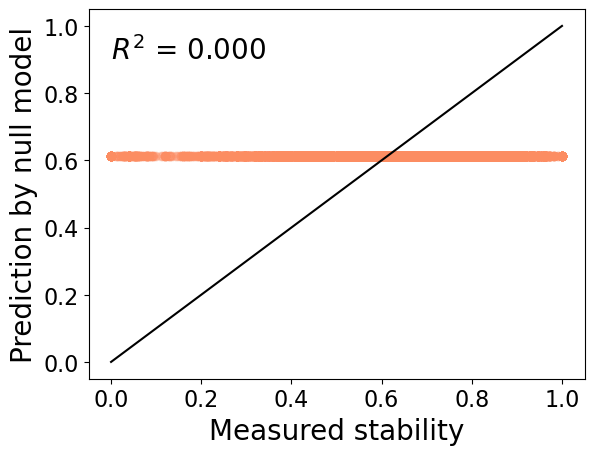

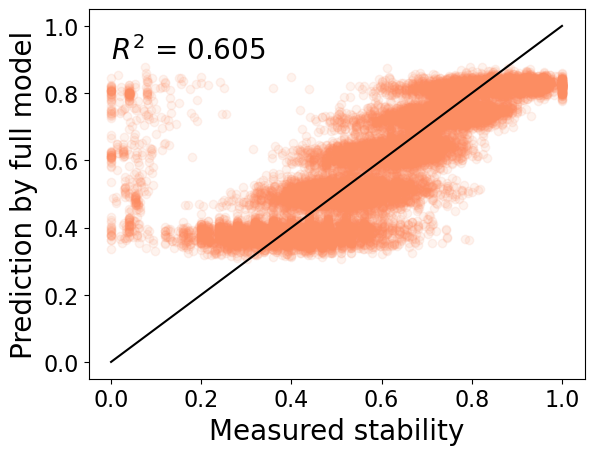

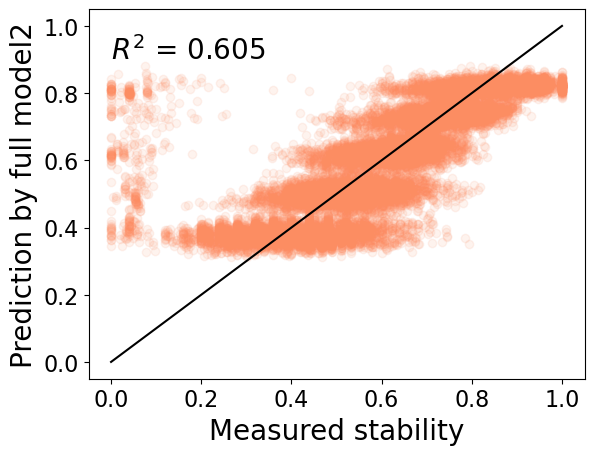

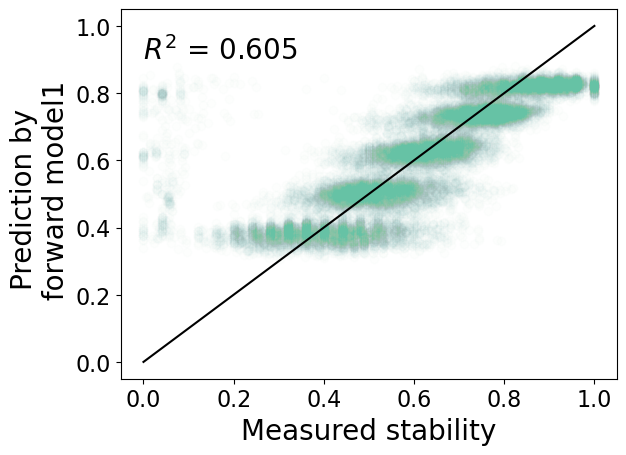

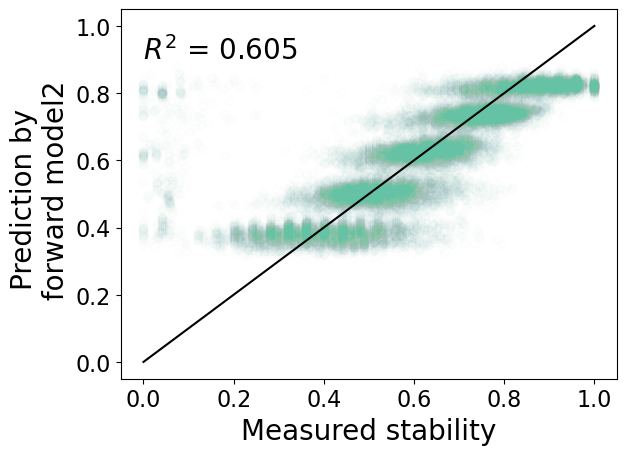

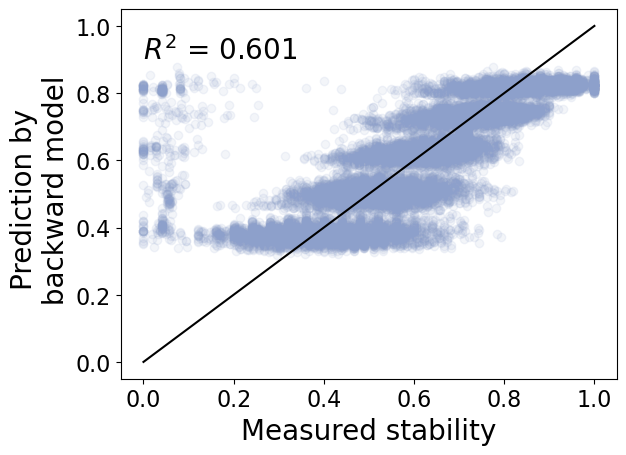

In [52]:
# plot against design data
from sklearn.metrics import r2_score

plt.scatter(df_design.iloc[:, 0], null_model.predict(df_design.iloc[:, 1:]), color='#fc8d62', alpha=0.1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('Measured stability', fontsize=20)
plt.ylabel('Prediction by null model', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
R2=r2_score(df_design.iloc[:, 0], null_model.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Null_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], full_model.predict(df_design.iloc[:, 1:]), color='#fc8d62', alpha=0.1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('Measured stability', fontsize=20)
plt.ylabel('Prediction by full model', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
R2=r2_score(df_design.iloc[:, 0], full_model.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Full1_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], full_model2.predict(df_design.iloc[:, 1:]), color='#fc8d62', alpha=0.1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('Measured stability', fontsize=20)
plt.ylabel('Prediction by full model2', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
R2=r2_score(df_design.iloc[:, 0], full_model2.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Full2_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], forward_model.predict(df_design.iloc[:, 1:]), color='#66c2a5', alpha=0.01)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('Measured stability', fontsize=20)
plt.ylabel('Prediction by \n forward model1', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
R2=r2_score(df_design.iloc[:, 0], forward_model.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Forward1_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], forward_model2.predict(df_design.iloc[:, 1:]), color='#66c2a5', alpha=0.01)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('Measured stability', fontsize=20)
plt.ylabel('Prediction by \n forward model2', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
R2=r2_score(df_design.iloc[:, 0], forward_model2.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Forward2_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], backward_model.predict(df_design.iloc[:, 1:]), color='#8da0cb', alpha=0.1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('Measured stability', fontsize=20)
plt.ylabel('Prediction by \n backward model', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
R2=r2_score(df_design.iloc[:, 0], backward_model.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('backward1_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

In [130]:
data=FullData(scenario=0)
c_list=[1.0, 0.5, 0.25]
rho_list=[0.0, 0.25, 0.5, 0.75, 1.0]
mu_list=[0.0, 0.25, 0.5, 1.0, 2.0]
rich_up=[]
rich_down=[]
for i in range(len(c_list)):
    connect=c_list[i]
    for j in range(20):
        print([connect, j])
        for k in range(len(rho_list)):
            rho=rho_list[k]
            for l in range(len(mu_list)):
                mu=mu_list[l]
                path=str('./connectance%.2f/replicate%d/rho%.2f_mu%.2f/assembly' %(connect, j, rho, mu))
                os.chdir(path)
                x=np.loadtxt('abundance.csv', delimiter=',')
                prev=x[0, :]
                for t in range(1, np.size(x, 0)):
                    if np.all(x[t, :]==prev)==False:
                        rich_up.append(np.sum(Comp(x[t, :25])))
                        rich_down.append(np.sum(Comp(x[t, 25:])))
                    prev=x[t, :]
                    
                os.chdir('../../../../')
data['richness_up']=rich_up
data['richness_down']=rich_down            
data
    

[1.0, 0]
[1.0, 1]
[1.0, 2]
[1.0, 3]
[1.0, 4]
[1.0, 5]
[1.0, 6]
[1.0, 7]
[1.0, 8]
[1.0, 9]
[1.0, 10]
[1.0, 11]
[1.0, 12]
[1.0, 13]
[1.0, 14]
[1.0, 15]
[1.0, 16]
[1.0, 17]
[1.0, 18]
[1.0, 19]
[0.5, 0]
[0.5, 1]
[0.5, 2]
[0.5, 3]
[0.5, 4]
[0.5, 5]
[0.5, 6]
[0.5, 7]
[0.5, 8]
[0.5, 9]
[0.5, 10]
[0.5, 11]
[0.5, 12]
[0.5, 13]
[0.5, 14]
[0.5, 15]
[0.5, 16]
[0.5, 17]
[0.5, 18]
[0.5, 19]
[0.25, 0]
[0.25, 1]
[0.25, 2]
[0.25, 3]
[0.25, 4]
[0.25, 5]
[0.25, 6]
[0.25, 7]
[0.25, 8]
[0.25, 9]
[0.25, 10]
[0.25, 11]
[0.25, 12]
[0.25, 13]
[0.25, 14]
[0.25, 15]
[0.25, 16]
[0.25, 17]
[0.25, 18]
[0.25, 19]


stability  resistance_invasion  resistance_environment  \
0           0.040                0.040                   0.000   
1           0.040                0.040                   0.000   
2           0.120                0.120                   0.000   
3           0.160                0.160                   0.000   
4           0.280                0.280                   0.000   
...           ...                  ...                     ...   
220772      0.966                0.542                   0.424   
220773      0.966                0.542                   0.424   
220774      0.966                0.542                   0.424   
220775      0.966                0.542                   0.424   
220776      0.966                0.542                   0.424   

        total_positive_up  mean_positive_up  total_negative_up  \
0                0.000000          0.000000           0.000000   
1                0.000000          0.000000           0.000000   
2                0.000000          0.000000           0.000000   
3                0.000000          0.000000           0.000000   
4                0.000000          0.000000           0.000000   
...                   ...               ...                ...   
220772           7.331879          0.183297           6.152229   
220773           7.331879          0.183297           6.152229   
220774           7.331879          0.183297           6.152229   
220775           7.331879          0.183297           6.152229   
220776           7.331879          0.183297           6.152229   

        mean_negative_up  degree_up  total_positive_down  mean_positive_down  \
0               0.000000   0.000000             0.000000            0.000000   
1               0.000000   0.000000             0.195451            0.195451   
2               0.000000   0.000000             0.562435            0.140609   
3               0.000000   0.000000             0.317255            0.158628   
4               0.000000   0.000000             1.746185            0.249455   
...                  ...        ...                  ...                 ...   
220772          0.161901   4.588235             1.384071            0.230678   
220773          0.161901   4.588235             1.384071            0.230678   
220774          0.161901   4.588235             1.384071            0.230678   
220775          0.161901   4.588235             1.384071            0.230678   
220776          0.161901   4.588235             1.384071            0.230678   

        ...  degree_down  total_positive_trans  mean_positive_trans  \
0       ...     0.000000              0.000000             0.000000   
1       ...     1.000000              0.000000             0.000000   
2       ...     2.000000              0.000000             0.000000   
3       ...     2.000000              0.000000             0.000000   
4       ...     3.000000              0.000000             0.000000   
...     ...          ...                   ...                  ...   
220772  ...     1.428571              2.592706             0.235701   
220773  ...     1.428571              2.592706             0.235701   
220774  ...     1.428571              2.592706             0.235701   
220775  ...     1.428571              2.592706             0.235701   
220776  ...     1.428571              2.592706             0.235701   

        total_negative_trans  mean_negative_trans  degree_trans   mu  rho  \
0                   0.000000             0.000000      0.000000  0.0  0.0   
1                   0.000000             0.000000      0.000000  0.0  0.0   
2                   0.000000             0.000000      0.000000  0.0  0.0   
3                   0.000000             0.000000      0.000000  0.0  0.0   
4                   0.000000             0.000000      0.000000  0.0  0.0   
...                      ...                  ...           ...  ...  ...   
220772              8.240544             0.392407      4.571429  2.0 

In [38]:
#data.to_csv('assembly_data.csv', index=False)
df_assembly=pd.read_csv('assembly_data.csv')

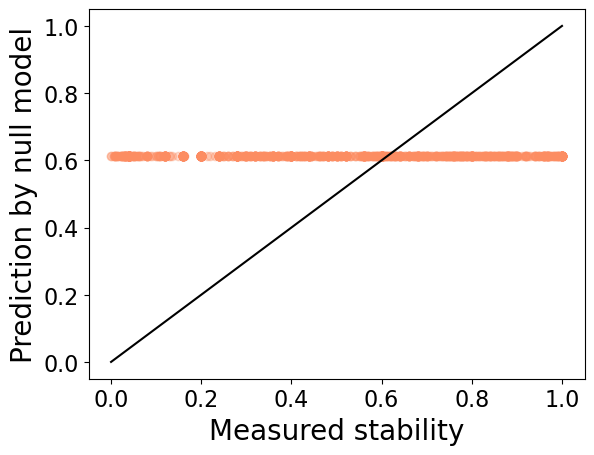

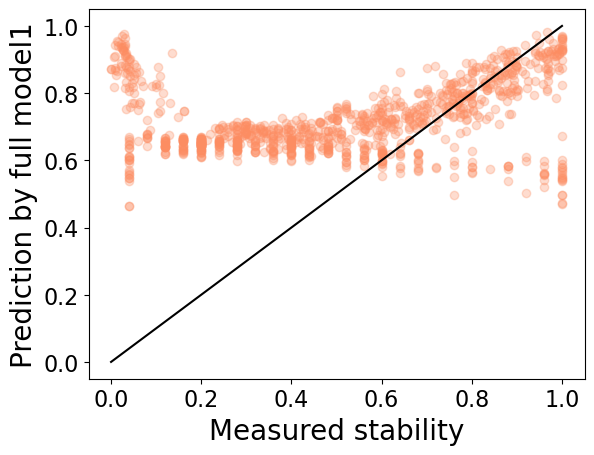

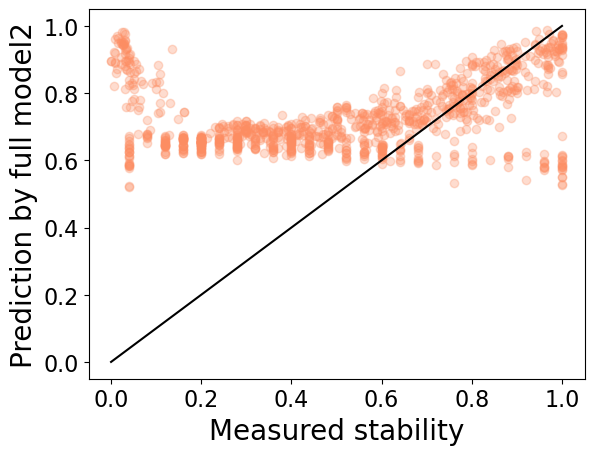

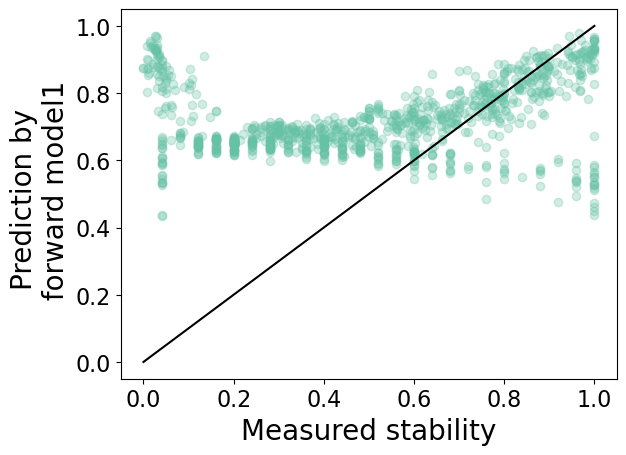

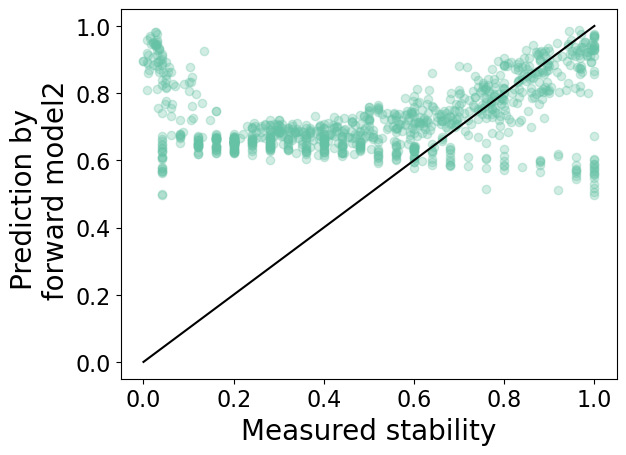

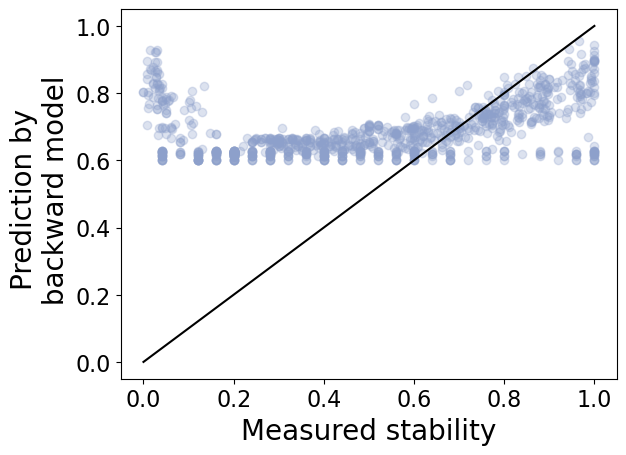

In [39]:
#prediction against subsampled assemble data
np.random.seed(0) 
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()
fig6, ax6 = plt.subplots()
diff1=0
diff2=0
diff3=0
diff4=0
diff5=0
diff6=0
 # remove cases where downstream is absent
flag=0
for i in range(0, 10):
    df=df_assembly.query(str('stability<=%.1f' %((i+1)*0.1))).reset_index(drop=True) # conside only stabiliy <0.95
    df=df.query(str('stability>=%.1f' %(i*0.1))).reset_index(drop=True) # conside only stabiliy <0.95
    rand_samp=np.random.randint(low=0, high=len(df), size=100).tolist()
    if flag==0:
        df_sub=df.iloc[rand_samp, :]
        flag=1
    else:
        df_sub=pd.concat([df_sub,df.iloc[rand_samp, :]], axis=0, ignore_index=True)
ax1.scatter(df_sub.iloc[:, 0], null_model.predict(df_sub.iloc[:, 1:]), color='#fc8d62', alpha=0.3)
ax1.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
ax1.tick_params(axis='both', which='major', labelsize=16)
#R2=r2_score(df_sub.iloc[:, 0], null_model.predict(df_sub.iloc[:, 1:]))
#ax1.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax2.scatter(df_sub.iloc[:, 0], full_model.predict(df_sub.iloc[:, 1:]), color='#fc8d62', alpha=0.3)
ax2.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
ax2.tick_params(axis='both', which='major', labelsize=16)
#R2=r2_score(df_sub.iloc[:, 0], full_model.predict(df_sub.iloc[:, 1:]))
#ax2.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax3.scatter(df_sub.iloc[:, 0], full_model2.predict(df_sub.iloc[:, 1:]), color='#fc8d62', alpha=0.3)
ax3.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
ax3.tick_params(axis='both', which='major', labelsize=16)
#R2=r2_score(df_sub.iloc[:, 0], full_model2.predict(df_sub.iloc[:, 1:]))
#ax3.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax4.scatter(df_sub.iloc[:, 0], forward_model.predict(df_sub.iloc[:, 1:]), color='#66c2a5', alpha=0.3)
ax4.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
ax4.tick_params(axis='both', which='major', labelsize=16)
#R2=r2_score(df_sub.iloc[:, 0], forward_model.predict(df_sub.iloc[:, 1:]))
#ax4.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax5.scatter(df_sub.iloc[:, 0], forward_model2.predict(df_sub.iloc[:, 1:]), color='#66c2a5', alpha=0.3)
ax5.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
ax5.tick_params(axis='both', which='major', labelsize=16)
#R2=r2_score(df_sub.iloc[:, 0], forward_model2.predict(df_sub.iloc[:, 1:]))
#ax5.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax6.scatter(df_sub.iloc[:, 0], backward_model.predict(df_sub.iloc[:, 1:]), color='#8da0cb', alpha=0.3)
ax6.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
ax6.tick_params(axis='both', which='major', labelsize=16)
#R2=r2_score(df_sub.iloc[:, 0], backward_model.predict(df_sub.iloc[:, 1:]))
#ax6.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax1.set_xlabel('Measured stability', fontsize=20)
ax1.set_ylabel('Prediction by null model', fontsize=20)
fig1.gca().set_rasterized(True)
fig1.savefig('Null_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax2.set_xlabel('Measured stability', fontsize=20)
ax2.set_ylabel('Prediction by full model1', fontsize=20)
fig2.gca().set_rasterized(True)
fig2.savefig('Full1_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax3.set_xlabel('Measured stability', fontsize=20)
ax3.set_ylabel('Prediction by full model2', fontsize=20)
fig3.gca().set_rasterized(True)
fig3.savefig('Full2_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax4.set_xlabel('Measured stability', fontsize=20)
ax4.set_ylabel('Prediction by \n forward model1', fontsize=20)
fig4.gca().set_rasterized(True)
fig4.savefig('Forward1_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax5.set_xlabel('Measured stability', fontsize=20)
ax5.set_ylabel('Prediction by \n forward model2', fontsize=20)
fig5.gca().set_rasterized(True)
fig5.savefig('Forward2_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax6.set_xlabel('Measured stability', fontsize=20)
ax6.set_ylabel('Prediction by \n backward model', fontsize=20)
fig6.gca().set_rasterized(True)
fig6.savefig('Backward_assembly.pdf', pad_inches=0.1, bbox_inches='tight')

## March 21

Suppose we fix the migration parameter values as well as  the downstream communities, does the stability increase over the richness or the total_positive_negative?

Fix parameters: rho=0.5, mu=0.5. We set the baseline at the end of the simulations. Then, we sampled the metacommunity where the downstream composition is identical, the richness in the upstream is the lowest (but larger than zero). Calculate the stability, richness_up, and the total_positive_mean

In [74]:
def Comp(x):
    # comver abundance data into composition data
    # x should be 1dim array of species abundances
    return x>pow(10, -5)
def Positive_trans(abundance, N, interaction):
    ans=0.0
    for i in range(N):
        if abundance[i]>pow(10,-5):
            for j in range(N):
                if abundance[N+j]>pow(10,-5):
                    if interaction[j,i]>0:
                        ans+=interaction[j,i]
    return ans
    
    
def Manipulation(interaction, stability, abundance, N):
    base_stability=[]
    base_richness=[]
    base_positive=[]
    mani_richness=[]
    mani_positive=[]
    mani_stability=[]
    #print([base_stability, base_richness, base_positive])
    #for t in range(len(stability)-2, -1, -1):
    T=51 # time point to get baseline communities
    for t in range(T-1, -1, -1):
        up_richness=np.sum(Comp(abundance[t, :N]))
        if np.all(Comp(abundance[t, N:])==Comp(abundance[T, N:])) and up_richness>=1:
            base_stability.append(stability[T])
            base_richness.append(np.sum(Comp(abundance[T, :N])))
            base_positive.append(Positive_trans(abundance[T, :], N, interaction))
            mani_richness.append(up_richness)
            mani_positive.append(Positive_trans(abundance[t, :], N, interaction))
            mani_stability.append(stability[t])
    return [base_stability, base_richness, base_positive, mani_stability, mani_richness, mani_positive]
                         
            
                  


def main (c_list=[1.0, 0.5, 0.25], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], mu_list=[0, 0.25, 0.5, 1.0, 2.0], replicate=20):
    base_stability_list=[]
    base_richness_list=[]
    base_positive_list=[]
    mani_stability_list=[]
    mani_richness_list=[]
    mani_positive_list=[]
    
    for i in range(len(c_list)):
        connect=c_list[i]
        print(i)
        for j in range(replicate):
            #print(j)
            for k in range(len(rho_list)):
                rho=rho_list[k]
                for l in range(len(rho_list)):
                    mu=mu_list[l]
                    if mu>0 or rho<1:
                        # we should not consider the case where the downstream is empy
                        os.chdir(str('./connectance%.2f/replicate%d/rho%.2f_mu%.2f/assembly' %(connect, j, rho, mu)))
                        interaction=-np.loadtxt('../../interaction.csv', delimiter=',')
                        stability=np.loadtxt('stability_new.csv', delimiter=',')
                        abundance=np.loadtxt('abundance.csv',delimiter=',')
                        base_stability, base_richness, base_positive, mani_stability, mani_richness, mani_positive=Manipulation(interaction, stability, abundance, 25)
                        base_stability_list.extend(base_stability)
                        base_richness_list.extend(base_richness)
                        base_positive_list.extend(base_positive)
                        mani_stability_list.extend(mani_stability)
                        mani_richness_list.extend(mani_richness)
                        mani_positive_list.extend(mani_positive)
                        os.chdir('../../../../')
    df=pd.DataFrame({'base_stability':base_stability_list, 'base_richness':base_richness_list,
                        'base_positive':base_positive_list, 'mani_stability':mani_stability_list,
                        'mani_richness':mani_richness_list, 'mani_positive':mani_positive_list})
    return df.query('mani_stability>0')
df=main(replicate=20)

0
1
2


SpearmanrResult(correlation=-0.13770780696726068, pvalue=1.925606177882065e-10)


<ipython-input-75-0e7823ddb3b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['diff_richness']=(df_new['base_richness']-df_new['mani_richness'])
<ipython-input-75-0e7823ddb3b7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['diff_stability']=(df_new['base_stability']-df_new['mani_stability'])
<ipython-input-75-0e7823ddb3b7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

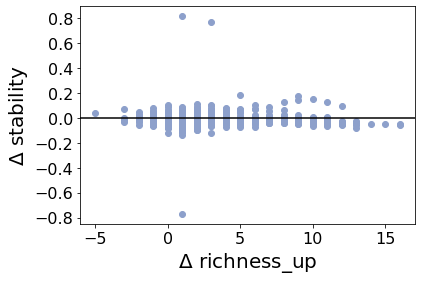

SpearmanrResult(correlation=0.038268468103974024, pvalue=0.07813375036057886)


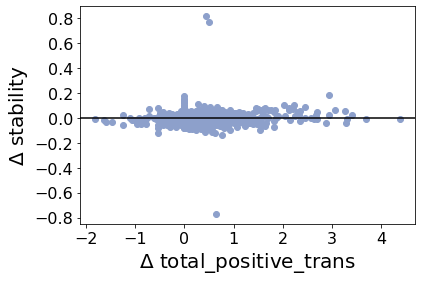

In [75]:
df_new=df[~df.duplicated()] # remove duplicated
df_new['diff_richness']=(df_new['base_richness']-df_new['mani_richness'])
df_new['diff_stability']=(df_new['base_stability']-df_new['mani_stability'])
df_new['diff_positive']=(df_new['base_positive']-df_new['mani_positive'])
plt.scatter(df_new['diff_richness'],  df_new['diff_stability'],
            color='#8da0cb', alpha=1)
plt.xlabel('$\Delta$ richness_up', fontsize=20)
plt.ylabel('$\Delta$ stability', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
print(sp.stats.spearmanr(df_new['diff_richness'], df_new['diff_stability']))
#plt.savefig('Assemble_DeltaRichnessUp_DeltaStability.pdf', pad_inches=0.1, bbox_inches='tight')
plt.axhline(y=0, color='k')
plt.show()

plt.scatter(df_new['diff_positive'], df_new['diff_stability'],  
            color='#8da0cb',alpha=1)
plt.xlabel('$\Delta$ total_positive_trans', fontsize=20)
plt.ylabel('$\Delta$ stability', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
print(sp.stats.spearmanr(df_new['diff_positive'], df_new['diff_stability']))
plt.axhline(y=0, color='k')
#plt.savefig('Assemble_DeltaPositiveTrans_DeltaStability.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

In [73]:
df_new

base_stability  base_richness  base_positive  mani_stability  \
0              0.740              6       6.212093           0.740   
1              0.883              3       4.102197           0.883   
5              0.694              4       4.818264           0.694   
6              0.694              4       4.818264           0.745   
8              0.724              4       5.090505           0.724   
...              ...            ...            ...             ...   
5606           0.974             14       0.481362           0.964   
5608           0.937             13       0.481362           0.937   
5610           0.937             13       0.481362           0.935   
5613           0.897             14       1.415476           0.897   
5615           0.897             14       1.415476           0.921   

      mani_richness  mani_positive  diff_richness  diff_stability  \
0                 6       6.212093              0           0.000   
1                 3       4.102197              0           0.000   
5                 4       4.818264              0           0.000   
6                 3       3.801612              1          -0.051   
8                 4       5.090505              0           0.000   
...             ...            ...            ...             ...   
5606             10       0.481362              4           0.010   
5608             13       0.481362              0           0.000   
5610             12       0.481362              1           0.002   
5613             14       1.415476              0           0.000   
5615             13       1.415476              1          -0.024   

      diff_positive  
0          0.000000  
1          0.000000  
5          0.000000  
6          1.016652  
8          0.000000  
...             ...  
5606       0.000000  
5608       0.000000  
5610       0.000000  
5613       0.000000  
5615       0.000000  

[2396 rows x 9 columns]

No correlation? But this might be due to the non-random sampling. 

In [32]:
os.chdir('../')
os.getcwd()

'/Users/shibasakishota/Desktop/スイス留学/Data/Project4/data'

diff_LogOdds     0.018264
diff_positive    0.170834
dtype: float64
SignificanceResult(statistic=0.11240178399086796, pvalue=4.28367226902538e-58)


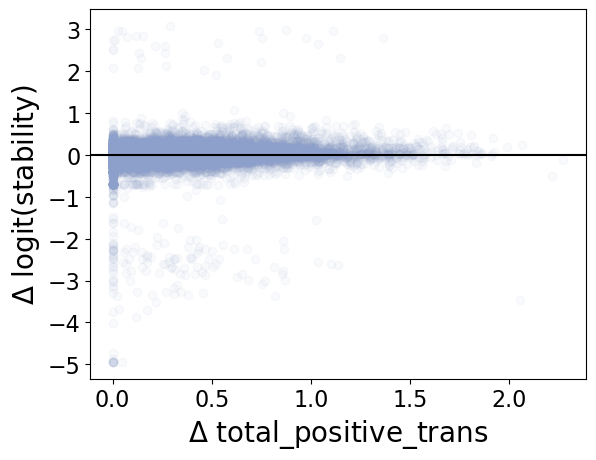

                W-val alternative         p-val       RBC  CLES
Wilcoxon  117070114.5     greater  5.108520e-88  0.161796   NaN


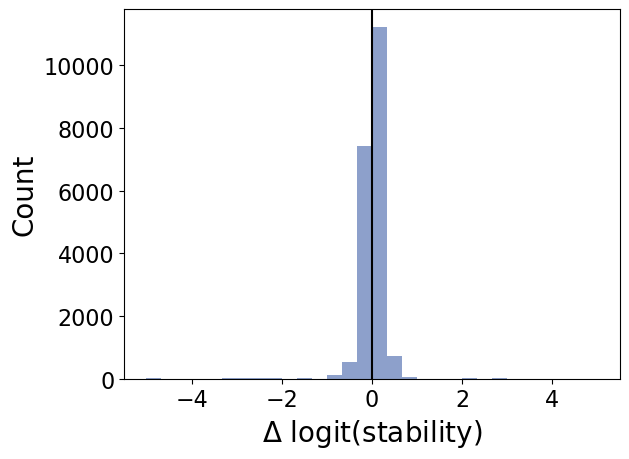

In [35]:
#Introducing species into te transient communities in the assembly
df1=pd.read_csv('Assembly_Manipulation_add.csv')
print(df1.median())
plt.scatter(df1.iloc[:, 1], df1.iloc[:, 0],  
            color='#8da0cb',alpha=0.05)
plt.ylabel('$\Delta$ logit(stability)', fontsize=20)
plt.xlabel('$\Delta$ total_positive_trans', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.xlim(0, 10)
print(sp.stats.spearmanr(df1.iloc[:, 0], df1.iloc[:, 1]))
plt.axhline(y=0, color='k')
#plt.savefig('Assemble_Manipulation_add.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

print(pingouin.wilcoxon(df1.iloc[:, 0], alternative='greater'))


plt.hist(df1.dropna().iloc[:, 0], range=(-5, 5), bins=30,color='#8da0cb')
plt.axvline(0, color='k')
plt.xlabel('$\Delta$ logit(stability)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.yscale('log')
#plt.savefig('Assemble_Manipulation_add_hist.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

diff_LogOdds    -0.031442
diff_positive   -0.017701
dtype: float64
SignificanceResult(statistic=0.11378476559189904, pvalue=4.542907321835313e-13)


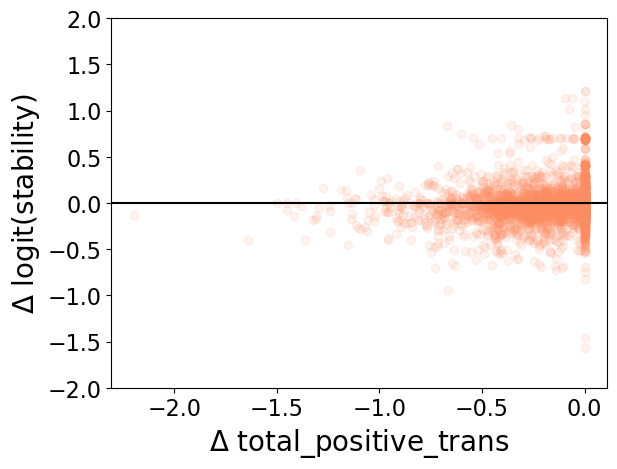

              W-val alternative         p-val       RBC  CLES
Wilcoxon  3199364.0        less  7.933905e-31 -0.209082   NaN


diff_LogOdds     0.044440
diff_positive   -0.162055
dtype: float64

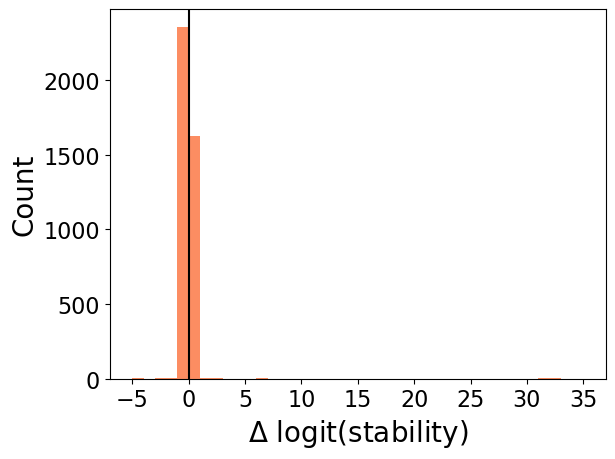

In [36]:

#Introducing species into te transient communities in the assembly
df2=pd.read_csv('Assembly_Manipulation_remove.csv').dropna()
print(df2.median())
plt.scatter(df2.iloc[:, 1], df2.iloc[:, 0],  
            color='#fc8d62',alpha=0.1)
plt.ylabel('$\Delta$ logit(stability)', fontsize=20)
plt.xlabel('$\Delta$ total_positive_trans', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-2,2)
print(sp.stats.spearmanr(df2.iloc[:, 0], df2.iloc[:, 1]))
plt.axhline(y=0, color='k')
#plt.savefig('Assemble_Manipulation_remove2.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

print(pingouin.wilcoxon(df2.iloc[:, 0], alternative='less'))
plt.hist(df2.dropna().iloc[:, 0], range=(-5, 35), bins=40,color='#fc8d62')
plt.axvline(0, color='k')
plt.xlabel('$\Delta$ logit(stability)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.yscale('log')
#plt.savefig('Assemble_Manipulation_remove_hist.pdf', pad_inches=0.1, bbox_inches='tight')
df2.dropna().mean()

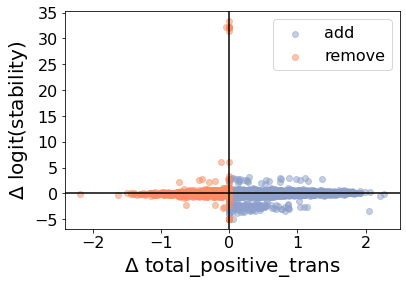

SpearmanrResult(correlation=0.15294060766638679, pvalue=3.0356847032560692e-127)


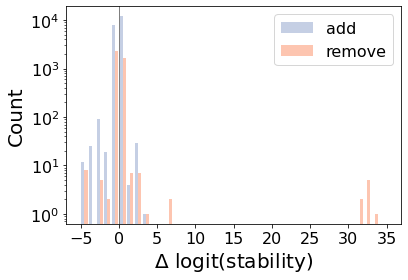

In [185]:
df=pd.concat([df1,df2]).dropna()
#df
plt.scatter(df1.iloc[:, 1], df1.iloc[:, 0],  
            color='#8da0cb',alpha=0.5, label='add')
plt.scatter(df2.iloc[:, 1], df2.iloc[:, 0],  
            color='#fc8d62',alpha=0.5, label='remove')
plt.ylabel('$\Delta$ logit(stability)', fontsize=20)
plt.xlabel('$\Delta$ total_positive_trans', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(0, color='k')
plt.axhline(y=0, color='k')
#plt.ylim(-5,7)
plt.legend(loc='best', fontsize=16)
plt.gca().set_rasterized(True)
plt.savefig('Assemble_Manipulation_AddRemove.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()
print(sp.stats.spearmanr(df.iloc[:, 0], df.iloc[:, 1]))

plt.hist([df1.dropna().iloc[:, 0], df2.dropna().iloc[:, 0]], range=(-5, 35), alpha=0.5,bins=40,
         color=['#8da0cb','#fc8d62'], label=['add', 'remove'])
#plt.hist(, range=(-5, 35), alpha=0.5,bins=40,color='#8da0cb', label='add')
plt.axvline(0, color='k', linewidth=0.5)
plt.xlabel('$\Delta$ logit(stability)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.legend(loc='best', fontsize=16)
plt.savefig('Assemble_Manipulation_AddRemove_hist.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

In [172]:
#df
print(len(df.query('diff_LogOdds>0 and diff_positive>=0'))/len(df))
print(len(df.query('diff_LogOdds<0 and diff_positive>=0'))/len(df))
print(len(df.query('diff_LogOdds>0 and diff_positive<0'))/len(df))
print(len(df.query('diff_LogOdds<0 and diff_positive<0'))/len(df))

0.5201594673461839
0.3850232214047922
0.03370186182236653
0.05153918868932637


In [2]:
#Manipulation
os.chdir('./Manipulation_positive')
count=0
for i in range(11):
    for j in range(11):
        if i !=j:
            df=pd.read_csv(str('stabilities_Up%d_Down%d.csv')%(i,j)).dropna()
            df['MetaCommunity']=np.ones([len(df)])*count
            if count==0:
                DF=df
                count+=1
            else:
                DF=pd.concat([DF, df], ignore_index=True)
                count+=1
DF

stability  positive_trans    mean  MetaCommunity
0        0.800        0.011408  0.0001            0.0
1        0.800        0.056666  0.0005            0.0
2        0.800        0.111718  0.0010            0.0
3        0.800        0.571048  0.0050            0.0
4        0.800        1.092465  0.0100            0.0
..         ...             ...     ...            ...
765      0.575        0.113018  0.0010          109.0
766      0.575        0.565942  0.0050          109.0
767      0.575        1.144526  0.0100          109.0
768      0.825        5.769890  0.0500          109.0
769      0.875       11.427716  0.1000          109.0

[770 rows x 4 columns]

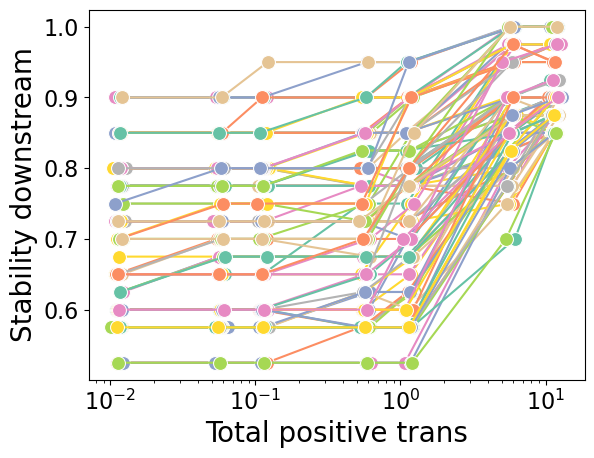

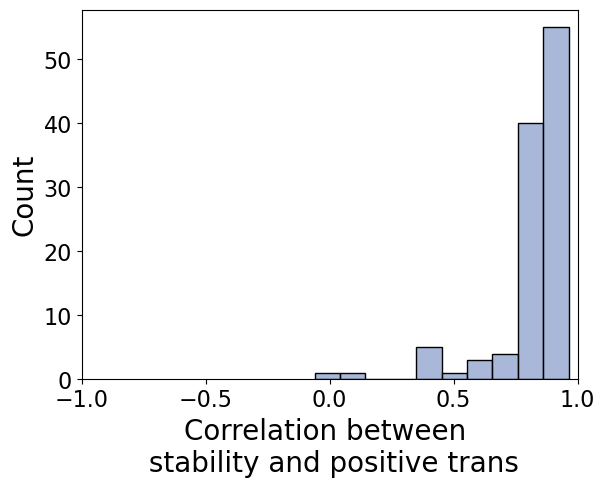

In [4]:
# compare each meta-community

sns.lineplot(data=DF, hue='MetaCommunity',palette='Set2',
                 x='positive_trans', y='stability', marker='o',
                markersize=10, legend=False)
plt.xscale('log')
plt.ylabel('Stability downstream', fontsize=20)
plt.xlabel('Total positive trans', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(0.5,1)
plt.savefig('Manipulation_Positive.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()
# corr
Corr=[]
for i in range(110):
    #print(DF.query(str('MetaCommunity==%d'%(i))).iloc[:, 0],)
    corr, p =sp.stats.spearmanr(DF.query(str('MetaCommunity==%d'%(i))).iloc[:, 0], 
                                DF.query(str('MetaCommunity==%d'%(i))).iloc[:, 1])
    if np.isnan(corr)==True:
        #no change
        corr=0
    Corr.append(corr)
sns.histplot(Corr,  color='#8da0cb', bins=10)
plt.xlabel('Correlation between \n stability and positive trans', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=16)
plt.xlim(-1, 1)
plt.xticks([-1, -0.5, 0.0, 0.5, 1.0])
plt.yticks(fontsize=16)
plt.savefig('Manipulation_Positive_hist.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

In [123]:
print(sp.stats.wilcoxon(Corr, alternative='less'))
print(sp.stats.wilcoxon(Corr, alternative='greater'))
print(sp.stats.wilcoxon(Corr))

WilcoxonResult(statistic=6104.0, pvalue=1.0)
WilcoxonResult(statistic=6104.0, pvalue=3.6368733892542794e-20)
WilcoxonResult(statistic=1.0, pvalue=7.273746778508559e-20)


In [188]:
np.sum(np.array(Corr)>0)

109

In [131]:
os.chdir('../')
os.getcwd()

'/Users/shota/Desktop/SpatialCommunityAssembly/CommunityAssambly_SpatialNetwork/RandomComm/StructuralStability/Conditional/data'

In [193]:
print(sp.stats.spearmanr(df.query('diff_LogOdds<30').iloc[:, 0], df.query('diff_LogOdds<30').iloc[:, 1]))

SpearmanrResult(correlation=0.153569138573484, pvalue=3.018306046804896e-128)


In [190]:
df

diff_LogOdds  diff_positive
0         0.000000       0.858372
1         0.000000       0.109159
2         0.000000       1.514371
3         0.190690       0.915721
4         0.190690       0.510807
...            ...            ...
4023     -0.050593       0.000000
4024     -0.050593       0.000000
4025     -0.050593       0.000000
4026     -0.050593       0.000000
4027     -0.050593       0.000000

[24331 rows x 2 columns]

In [28]:
"""
Additional analysis
In the above case, resistance to invasion would be very high 
due to the negative effects from down to up when up invades down
When we fix the interactions from down to up zeros, can we still see positive correlations?

"""
os.chdir('../Manipulation_positive2')
count=0
for i in range(11):
    for j in range(11):
        if i !=j:
            df=pd.read_csv(str('stabilities_Up%d_Down%d.csv')%(i,j)).dropna()
            df['MetaCommunity']=np.ones([len(df)])*count
            if count==0:
                DF=df
                count+=1
            else:
                DF=pd.concat([DF, df], ignore_index=True)
                count+=1
DF

stability  positive_trans    mean  MetaCommunity
0        0.800        0.010621  0.0001            0.0
1        0.800        0.060082  0.0005            0.0
2        0.800        0.113430  0.0010            0.0
3        0.800        0.582851  0.0050            0.0
4        0.800        1.157444  0.0100            0.0
..         ...             ...     ...            ...
764      0.575        0.118144  0.0010          109.0
765      0.575        0.595634  0.0050          109.0
766      0.575        1.176136  0.0100          109.0
767      0.575        5.734206  0.0500          109.0
768      0.575       11.826818  0.1000          109.0

[769 rows x 4 columns]

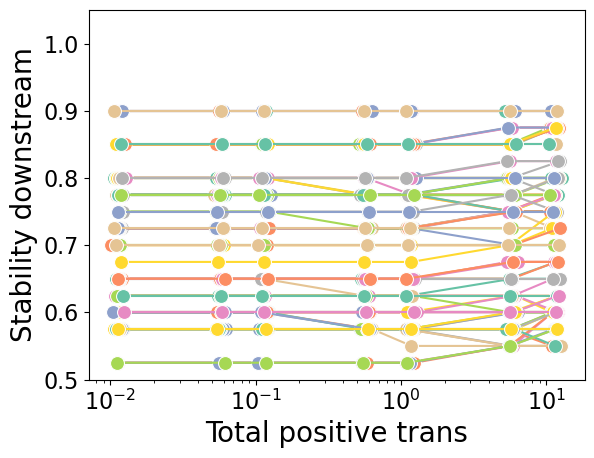

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


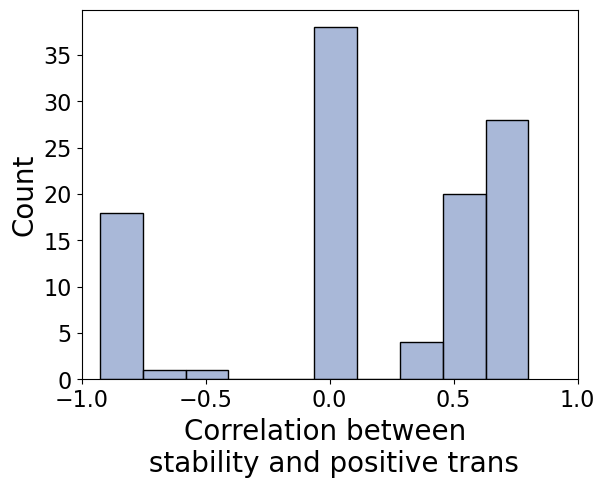

In [29]:
sns.lineplot(data=DF, hue='MetaCommunity',palette='Set2',
                 x='positive_trans', y='stability', marker='o',
                markersize=10, legend=False)
plt.xscale('log')
plt.ylabel('Stability downstream', fontsize=20)
plt.xlabel('Total positive trans', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0.5,1.05)
#plt.savefig('Manipulation_Positive2.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()
# corr

Corr=[]
for i in range(110):
    #print(DF.query(str('MetaCommunity==%d'%(i))).iloc[:, 0],)
    corr, p =sp.stats.spearmanr(DF.query(str('MetaCommunity==%d'%(i))).iloc[:, 0], 
                                DF.query(str('MetaCommunity==%d'%(i))).iloc[:, 1])
    if np.isnan(corr)==True:
        #no change
        corr=0
    Corr.append(corr)
sns.histplot(Corr,  color='#8da0cb', bins=10)
plt.xlabel('Correlation between \n stability and positive trans', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=16)
plt.xlim(-1, 1)
plt.xticks([-1, -0.5, 0.0, 0.5, 1.0])
plt.yticks(fontsize=16)

#plt.savefig('Manipulation_Positive_hist2.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

In [30]:
pingouin.wilcoxon(Corr, alternative='greater')

W-val alternative     p-val       RBC  CLES
Wilcoxon  1620.0     greater  0.041851  0.232877   NaN

In [30]:
count=0
for i in range(len(Corr)):
    if Corr[i]==0:
        count+=1
print(count)

38


# Effects of the spatial structures (Design)

As we have the target downstream communities as the ase w/o spatial structure, we can see how the spatial structure alone affect the stability.

In [1]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp #ode integration
import matplotlib.pyplot as plt
import itertools

os.chdir('./data')
os.getcwd()


'/Users/shota/Desktop/SpatialCommunityAssembly/CommunityAssambly_SpatialNetwork/RandomComm/StructuralStability/Conditional/data'

In [2]:
df_control=pd.read_csv('design_control.csv')
c_list=[1.00 , 0.5, 0.25]
count=1
diff=[]
index=[]
for i in range(len(c_list)):
    connectance=c_list[i]
    for j in range(20):
        os.chdir(str('./connectance%.2f/replicate%d/rho0.00_mu0.00/designing2' %(connectance, j)))
        stab=np.loadtxt('stability_new.csv', delimiter=',')
        D=stab[~np.isnan(stab)]-df_control['stability'][count-1]
        diff.extend(D.tolist())
        index.extend(np.size(D)*[count])
        count+=1
        os.chdir('../../../../')
df=pd.DataFrame({'difference':diff, 'index':index})        

0.3579977246871446
0.36


(array([  0.,  50., 100., 150., 200., 250.]),
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250')])

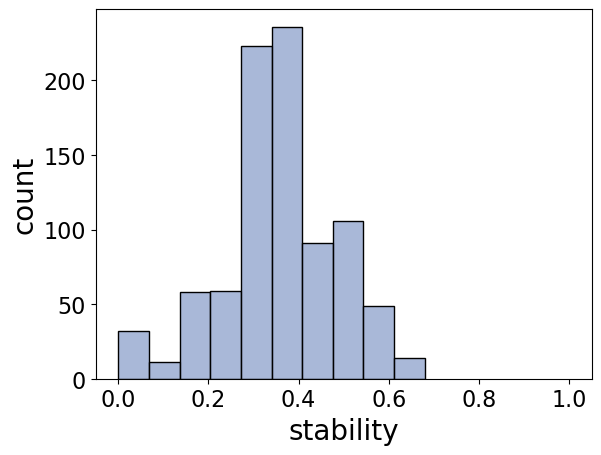

In [3]:
# distribution of stability when mu=0, rho=0
c_list=[1.00 , 0.5, 0.25]
count=1
S=[]

for i in range(len(c_list)):
    connectance=c_list[i]
    for j in range(20):
        os.chdir(str('./connectance%.2f/replicate%d/rho0.00_mu0.00/designing2' %(connectance, j)))
        stab=np.loadtxt('stability_new.csv', delimiter=',')
        s=stab[~np.isnan(stab)]
        S.extend(s.tolist())
        os.chdir('../../../../')
print(np.mean(S))
print(np.median(S))
sns.histplot(S,  color='#8da0cb', bins=10)
plt.xlim(-0.05, 1.05)
plt.xlabel('stability', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

0.22466666666666663
0.24


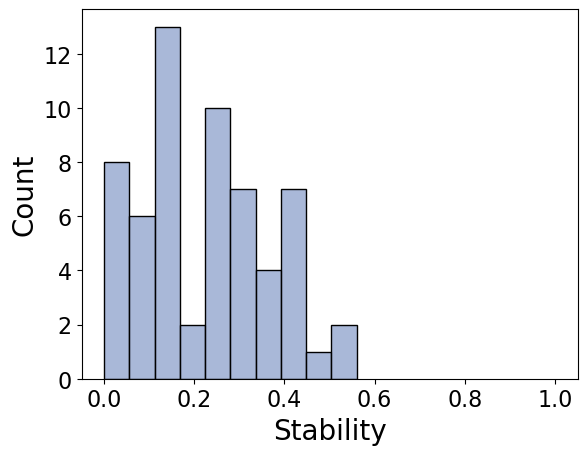

In [4]:
# plot distirbutions
# w/o spatial structure
df_control=pd.read_csv('design_control.csv')
print(np.mean(df_control['stability']))
print(np.median(df_control['stability']))
sns.histplot(df_control['stability'],  color='#8da0cb', bins=10)
plt.xlim(-0.05, 1.05)
plt.xlabel('Stability', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Control_design_stability.png',  pad_inches=0.1, bbox_inches='tight')

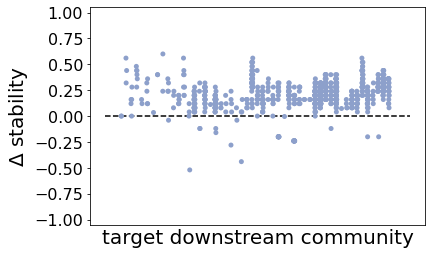

In [39]:
sns.stripplot(data=df, x='index', y='difference',  color='#8da0cb')
plt.ylim(-1.05, 1.05)
plt.xlabel('target downstream community', fontsize=20)
plt.ylabel('$\Delta$ stability', fontsize=20)
plt.xticks([], fontsize=16)
plt.yticks(fontsize=16)
plt.hlines(y=0, xmin=-3, xmax=55, color='k', linestyle='--')
plt.savefig('ControlVSRho000Mu000_design_stability.pdf',  pad_inches=0.1, bbox_inches='tight')

In [45]:
failure=[]
for i in range(len(c_list)):
    connectance=c_list[i]
    for j in range(20):
        os.chdir(str('./connectance%.2f/replicate%d/rho0.00_mu0.00/designing2' %(connectance, j)))
        stab=np.loadtxt('stability_new.csv', delimiter=',')
        failure.append(np.sum(np.isnan(stab)/np.size(stab)))
        os.chdir('../../../../')
failure

[0.9899999999999999,
 0.9849999999999999,
 0.9749999999999999,
 0.9699999999999999,
 0.9999999999999998,
 0.9899999999999998,
 0.9749999999999999,
 0.9949999999999999,
 0.9899999999999999,
 0.9999999999999998,
 0.9999999999999998,
 0.9999999999999998,
 0.9899999999999999,
 0.9749999999999999,
 0.9849999999999999,
 0.9699999999999999,
 0.9999999999999998,
 0.9599999999999999,
 0.9999999999999998,
 0.9799999999999999,
 0.8599999999999999,
 0.9799999999999999,
 0.8799999999999999,
 0.9949999999999999,
 0.78,
 0.9849999999999999,
 0.9849999999999999,
 0.9749999999999999,
 0.9999999999999998,
 0.9899999999999999,
 0.9799999999999999,
 0.9699999999999999,
 0.76,
 0.9499999999999998,
 0.8899999999999999,
 0.9699999999999999,
 0.9449999999999998,
 0.8949999999999999,
 0.9949999999999999,
 0.8949999999999999,
 0.8949999999999999,
 0.9599999999999999,
 0.9899999999999999,
 0.9899999999999999,
 0.74,
 0.5,
 0.755,
 0.9349999999999998,
 0.525,
 0.9949999999999999,
 0.9799999999999999,
 0.889999999

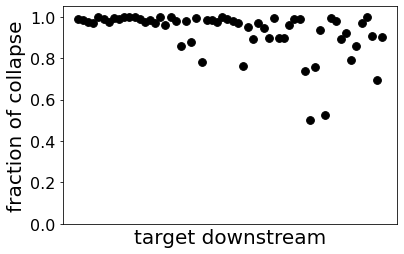

In [57]:
plt.scatter(np.arange(1, 61), failure, color='k', marker='o', s=60)
plt.xlabel('target downstream', fontsize=20)
plt.ylabel('fraction of collapse', fontsize=20)
plt.ylim(0, 1.05)
plt.xticks([])
plt.yticks(fontsize=16)
plt.savefig('failure_MetaComm_Rho000Mu000.pdf')

# Contorl scenario in assembly

In this case, we just need to analyze the cases of $\rho=0.0$ and $\mu=0.0$

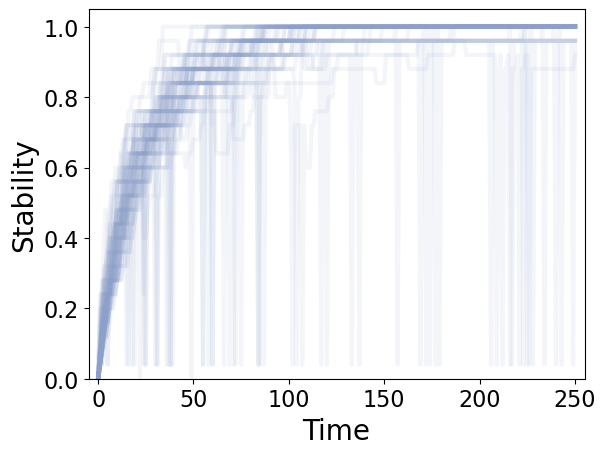

In [5]:
c_list=[1.00 , 0.5, 0.25]
#df_assembly=pd.DataFrame({'time':})
for i in range(len(c_list)):
    connectance=c_list[i]
    for j in range(20):
        os.chdir(str('./connectance%.2f/replicate%d/rho0.00_mu0.00/assembly' %(connectance, j)))
        stab=np.loadtxt('stability_new.csv', delimiter=',')
        plt.plot(np.arange(0, np.size(stab)), stab, color='#8da0cb', alpha=0.1, linewidth=3)
        os.chdir('../../../../')
plt.xlim(-5, 255)
plt.ylim(0.0, 1.05)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Stability', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.savefig('Control_assembly_stability.png',  pad_inches=0.1, bbox_inches='tight')
plt.show()

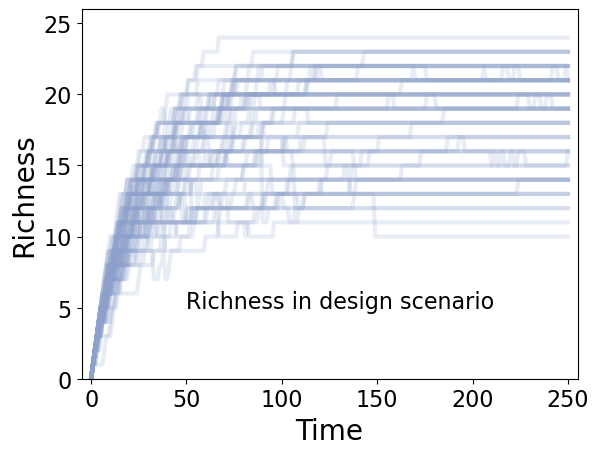

In [7]:
c_list=[1.00 , 0.5, 0.25]
#df_assembly=pd.DataFrame({'time':})
for i in range(len(c_list)):
    connectance=c_list[i]
    for j in range(20):
        os.chdir(str('./connectance%.2f/replicate%d/rho0.00_mu0.00/assembly' %(connectance, j)))
        richness=np.sum(np.loadtxt('abundance.csv', delimiter=',')>pow(10,-6), axis=1)
        plt.plot(np.arange(0, np.size(richness)), richness, color='#8da0cb', alpha=0.2, linewidth=3)
        os.chdir('../../../../')
plt.xlim(-5, 255)
plt.ylim(0.0, 26)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Richness', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.text(s='Richness in design scenario', x=50, y=5, size=16)
plt.savefig('Control_assembly_richness.png',  pad_inches=0.1, bbox_inches='tight')
plt.show()

In [7]:
df_assembly_control=df_assembly[(df_assembly["rho"] == 0.0) &  (df_assembly["mu"] == 0.0)]
df_assembly_control # stability of assem,bly w/o spatial structure

full_stability  invasion_stability  rho   mu  connectance
0                 0.00                0.00  0.0  0.0         1.00
1                 0.04                0.04  0.0  0.0         1.00
2                 0.04                0.04  0.0  0.0         1.00
3                 0.12                0.12  0.0  0.0         1.00
4                 0.16                0.16  0.0  0.0         1.00
...                ...                 ...  ...  ...          ...
206801            1.00                1.00  0.0  0.0         0.25
206802            1.00                1.00  0.0  0.0         0.25
206803            1.00                1.00  0.0  0.0         0.25
206804            1.00                1.00  0.0  0.0         0.25
206805            1.00                1.00  0.0  0.0         0.25

[6700 rows x 5 columns]

In [12]:
# histgram of stability in assembly
S=[]
c_list=[1.00 , 0.5, 0.25]
for i in range(len(c_list)):
    connectance=c_list[i]
    for j in range(20):
        os.chdir(str('./connectance%.2f/replicate%d/rho0.00_mu0.00/assembly' %(connectance, j)))
        abd=np.loadtxt('abundance.csv', delimiter=',')
        stab=np.loadtxt('stability_new.csv', delimiter=',')
        for t in range(len(stab)-1):
            if np.any(abd[t, :]!=abd[t+1, :]):
                S.append(stab[t])
        os.chdir('../../../../')

In [9]:
df_design_control=pd.read_csv('design_control.csv')

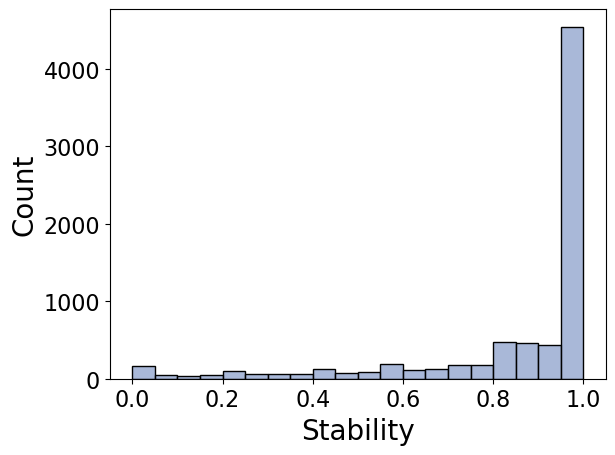

In [9]:
sns.histplot(S,  color='#8da0cb', bins=20)
plt.xlim(-0.05, 1.05)
plt.xlabel('Stability', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Control_assembly_stability_hist.png',  pad_inches=0.1, bbox_inches='tight')

In [13]:
print(np.median(S))
print(np.median(df_design_control['stability']))
print(sp.stats.ranksums(df_design_control['stability'], S, alternative='less'))
d, res = cliffs_delta(df_design_control['stability'], S) # effect size

print(d,res)

0.96
0.24
RanksumsResult(statistic=-12.098850601304989, pvalue=5.355010814962818e-34)
-0.9054447546868768 large


In [2]:
# If degree_trans can affect stability?
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
import statsmodels.formula.api as smf
data=pd.read_csv('design_data.csv')
#standarize
y=data.iloc[:, 0] # target
y2=data.iloc[:, 1:3]
X=data.iloc[:, 3:] # features but ignore index, resistance to invasion/environmental change
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =data.columns[3:])
df_design=pd.concat((y, y2, Xss), axis=1).fillna(0)
df_design# standaril data

stability  resistance_invasion  resistance_environment  \
0          0.560                0.560                   0.000   
1          0.560                0.560                   0.000   
2          0.560                0.560                   0.000   
3          0.680                0.680                   0.000   
4          0.440                0.440                   0.000   
...          ...                  ...                     ...   
18917      0.723                0.213                   0.510   
18918      0.756                0.222                   0.534   
18919      0.829                0.244                   0.585   
18920      0.800                0.267                   0.533   
18921      0.872                0.256                   0.616   

       total_positive_up  mean_positive_up  total_negative_up  \
0               1.849526          0.219242           0.347624   
1               0.919274          1.439328           0.890466   
2               2.255920          0.139275           1.794040   
3               0.169900         -0.302198           0.940464   
4               0.431989          1.782933          -0.142401   
...                  ...               ...                ...   
18917          -0.220683          0.070635          -0.573009   
18918          -0.896682         -0.469284          -0.924958   
18919          -0.736555          0.167407          -0.871427   
18920          -0.846670          0.558071          -0.683799   
18921          -0.749872          1.408380          -1.132454   

       mean_negative_up  degree_up  total_positive_down  mean_positive_down  \
0             -0.769937   2.220681            11.335954            0.995245   
1              0.075606   1.720004            11.335954            0.995245   
2              0.335235   2.721358            -0.492461           -0.700100   
3              0.030345   1.720004            -0.492461           -0.700100   
4             -1.114892   1.219327            -0.492461           -0.700100   
...                 ...        ...                  ...                 ...   
18917         -0.270532  -0.464767            -0.492461           -0.700100   
18918         -0.369377  -0.983650            -0.492461           -0.700100   
18919          0.727353  -0.783380            -0.492461           -0.700100   
18920          0.874022  -0.983650            -0.492461           -0.700100   
18921         -0.476534  -0.926430            -0.492461           -0.700100   

       ...  degree_down  total_positive_trans  mean_positive_trans  \
0      ...     7.690011              3.774293            -0.520468   
1      ...     7.690011              5.093681            -0.258572   
2      ...     0.307283              0.324859            -0.202927   
3      ...     0.307283              0.172412             0.285064   
4      ...     0.307283             -0.088799            -0.479013   
...    ...          ...                   ...                  ...   
18917  ...    -0.747393             -0.773351            -0.835186   
18918  ...    -0.747393             -0.983803            -0.969020   
18919  ...    -0.747393             -1.049105            -1.255599   
18920  ...    -0.747393             -0.713356             0.217836   
18921  ...    -0.747393             -0.989911            -0.366728   

       total_negative_trans  mean_negative_trans  degree_trans        mu  \
0                  6.162821             0.033989      2.071837 -1.073981   
1                  5.363451             0.369448      1.648605 -1.073981   
2                  1.422396             0.648003      2.495068 -1.073981   
3                  1.068889             0.496027      1.648605 -1.073981   
4                 -0.111969            -0.162865      1.225373 -1.073981   
...                     ...                  ...           ...       ...   
18917             -0.866229             0.063291      0.378909  1.722478   
18918             -1.040230            -1.97663

In [41]:
model=smf.logit('stability ~richness_up+richness_down+degree_trans+mu+rho', 
                 df_design).fit()
print(model.summary())

PatsyError: Error evaluating factor: NameError: name 'richness_down' is not defined
    stability ~richness_up+richness_down+degree_trans+mu+rho
                           ^^^^^^^^^^^^^

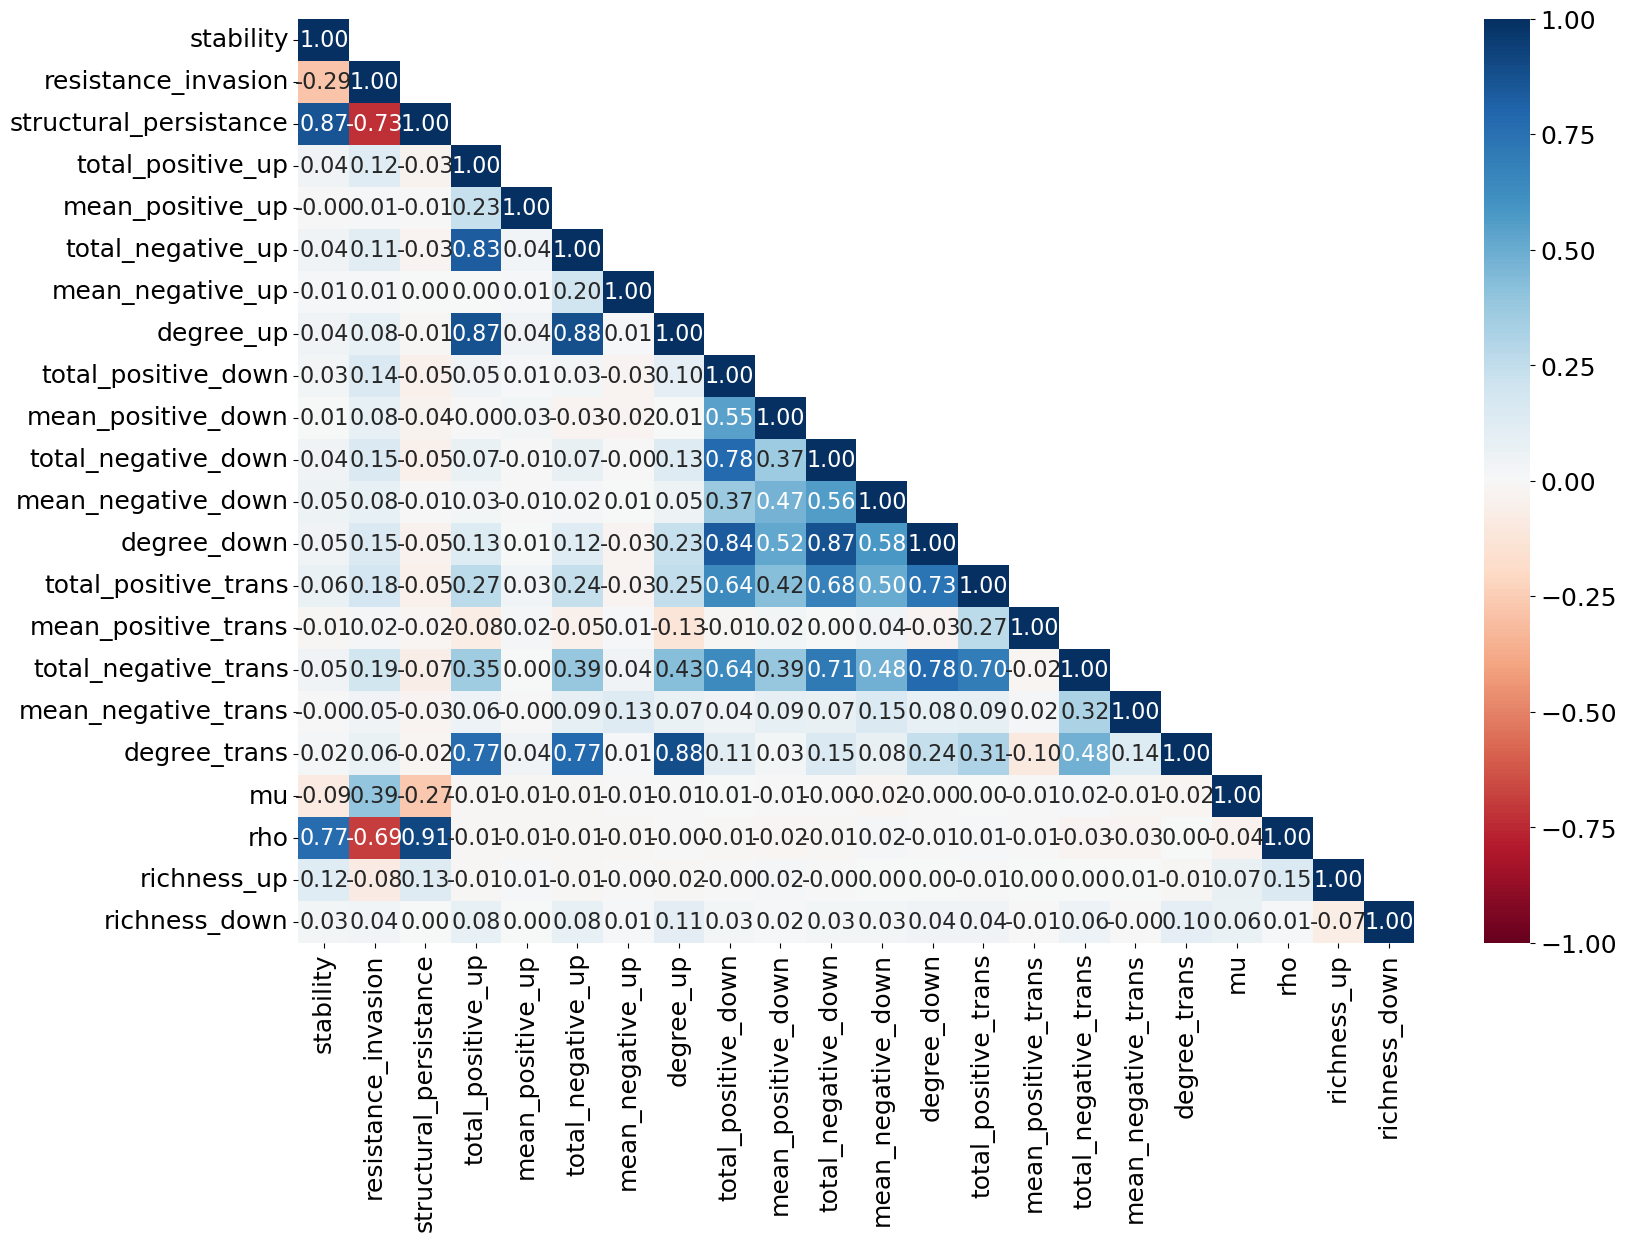

In [3]:
df_design1=df_design.rename(columns={'resistance_environment': 'structural_persistance'})
f, ax = plt.subplots(figsize=(18, 12))
corr=df_design1.corr() #pearson corr.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
mask=mask-np.eye(np.size(corr, axis=0))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax=sns.heatmap(corr, vmin=-1, vmax=1,annot=True,fmt='.2f',mask=mask, cmap="RdBu",annot_kws={"size": 16})
ax.tick_params(axis='both', which='major', rotation =90, labelsize=18)
plt.yticks(rotation=0)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=18)
plt.savefig('Feature_PearsonCorr_designl.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

In [15]:
# control vs design with rho=0
df_design=pd.read_csv('design_data.csv')
df_control=pd.read_csv('design_control.csv')
sp.stats.ranksums(df_design.query("rho==0")["stability"], df_control["stability"],alternative='greater')
d, res = cliffs_delta(df_design.query("rho==0")["stability"], df_control["stability"]) # effect size

print(d,res)

0.6074654137300965 large


In [2]:
df_design=pd.read_csv('design_data.csv')
df_control=pd.read_csv('design_control.csv')
sp.stats.ranksums(df_design.query("rho==1 and mu==0")["stability"], df_control["stability"],alternative='greater')

RanksumsResult(statistic=10.598785006062094, pvalue=1.5093825066459152e-26)

In [3]:
df_design.query("rho==1 and mu==0")["stability"].median()

0.96

In [6]:
df_design.query("rho==0")["stability"].median()

0.4

 ## connectance matters?
 In the structured case, species interaction has lower connectance than without spatial cases. Is this why we have higher stability?
 
 ### Procedure
 Start from community w/o strrucure. The, one species move upstream that has the strongest positive effect on the other soecies. We can also compare the case when we remove the focal species in unstucutred scenario.

In [193]:
def Comp(x):
    # comver abundance data into composition data
    # x should be 1dim array of species abundances
    return x>pow(10, -5)

def ODE_structured(t,x,  r_up, r_down, A):
    # note that -A represents intertaction matrix
    dx=np.zeros([np.size(x)])
    N_up=np.size(r_up)
    N_down=np.size(r_down)
    for i in range(N_up):
        # upstream community
        if x[i]>pow(10, -6):
            dx[i] = x[i]*(r_up[i] + np.dot(A[i, :], x[:N_up]))
    for i in range(N_down):
        if x[i+N_up]>pow(10, -6):
            dx[i+N_up]=x[i+N_up]*(r_down[i]+np.dot(A[i, :], x[:N_up]) +np.dot( A[i, :N_down], x[N_up:]))
    return dx
def RemovedSpecies(x, A):
    # convert abundance into presence/absence
    x=x>pow(10, -6)
    S=A>0 
    A_new=A*S  # we make negative element as zero so that we can choose the species
    
    if sum(x)<2:
        # we have only 1 species  unable ton remove
        return -1
    else:
        Pos=x*np.dot(A, x) # strength og positive interactions
        if np.max(Pos) ==0 :
            # there is no positive interactions
            return -1
        else:
            return np.argmax(Pos)
def MovingUp(remover, r_up, r_down, A, x) :
    if remover==-1:
        # no removing species
        return np.nan
    else:
        # move remover to upstream
        x_up=np.zeros([len(x)])
        x_up[remover]=x[remover]
        x_down=np.zeros([len(x)])
        for i in range(len(x)):
            if i==remover:
                x_down[i]=0
            else:
                x_down[i]=x[i]
        # make community
        sol=solve_ivp(ODE_structured, [0, 300], y0=np.concatenate([x_up, x_down]),  method='LSODA',
                             t_eval=np.linspace(0, 300, 30001), args=[r_up, r_down, A])# ODE integ
        x_f=sol.y[:,-1] # at equilibrium
        if np.all(Comp(x_f) == Comp(np.concatenate([x_up, x_down]))):
            # the new community is held
            #Start stability analysis
            stab, inv=Stability_design(x_f, r_up, r_down, A, 0, 0) # note we consider the invasion to the downstream
            return stab
        else:
            return np.nan
        
def Removing(remover, r_up, r_down, A, x) :
    if remover==-1:
        # no removing species
        return np.nan
    else:
        # remove focal species
        x_up=np.zeros([len(x)])
        x_down=x
        x_down=np.zeros([len(x)])
        for i in range(len(x)):
            if i==remover:
                x_down[i]=0
            else:
                x_down[i]=x[i]
        # make community
        sol=solve_ivp(ODE_structured, [0, 300], y0=np.concatenate([x_up, x_down]),  method='LSODA',
                             t_eval=np.linspace(0, 300, 30001), args=[r_up, r_down, A])# ODE integ
        x_f=sol.y[:,-1] # at equilibrium
        if np.all(Comp(x_f) == Comp(np.concatenate([x_up, x_down]))):
            stab, inv=Stability_design(x_f, r_up, r_down, A, 0, 0) # note we consider the invasion to the downstream
            return stab
        else:
            return np.nan

def Invasion(invader, N, x_full, r_up, r_down, A):

        inv=np.zeros([2*N])
        inv[invader]=inv[invader]+0.01
        sol=solve_ivp(ODE_structured, [0, 300], y0=x_full+inv,
                      method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                      args=[r_up, r_down, A])# ODE integ
        # check whetehr invasion does not affect the composition od downstream
        sol_down=sol.y[:,-1]
        for k in range(np.size(sol_down)):
            if sol_down[k]<pow(10, -6):
                sol_down[k]=0

        return np.all(Comp(sol_down[N:])==Comp(x_full[N:]))
    
def Stability_design(x_full, r_up, r_down, A, rho, mu):
    """
    Caltulkating structural stability of downstream

    Parameters
    ----------
    x : 1dim array of species abundances in up/downstream communities
    r_up : 1dim array of growth vector in upsteam 
    r_down : 1dim array of grwoth vector in downstream
    A : 2dim array for species interaction (minus A is interaction matrix)
    rho : parmater for migration from pool to upstream vs to downstream
    mu : parmater for migration from upstream to downstream

    Returns  exact structural stability
    -------
    """
    N=np.size(r_up)
    p=np.zeros([2*N])
    # probabilities to migration to upstream and dowstream community
    for i in range(np.size(p)):
        if i<N:
            # migration to upstream
            p[i]=rho
        else:
            #migration to downstream
            p[i] = 1-rho + mu* (Comp(x_full[i-N]))
    # normalize
    p=p/np.sum(p)
    stability=0.0
    inv_stability=0.0
    # invasion_upstream
    for i in range(N):
        # invasion to upstream
        stability+=p[i] * Invasion(i, N, x_full, r_up, r_down, A)
    for i in range(N, 2*N):
        # invasion to downstream
        add=p[i] * Invasion(i, N, x_full, r_up, r_down, A)
        stability+=add
        inv_stability+=add
    return [stability, inv_stability]        

def main(c_list=[1.0, 0.5, 0.25]):
    stab_moved=[]  # if we move one species to upstream
    stab_removed=[] # if we remove one species
    rho=0
    mu=0
    for i in range(len(c_list)):
        connect=c_list[i]
        print(str('connectanxce %.2f' %(connect)))
        os.chdir(str('./connectance%.2f' %(connect)))
        for j in range(20):
            os.chdir('./replicate%d' %(j))
            print(str('Replicate %d' %(j)))
            r_down=np.loadtxt('growthrate_down.csv', delimiter=',')
            r_up=np.loadtxt('growthrate_down.csv', delimiter=',')
            A=-np.loadtxt('interaction.csv', delimiter=',') # see the sign of intraspecific interaction
            os.chdir('./rho%.2f_mu%.2f/designing2' %(rho, mu))
            x=np.loadtxt('target_down.csv', delimiter=',') # get baseline downstream
            # choose removed species
            remover = RemovedSpecies(x, A)
            stab_moved.append(MovingUp(remover, r_up, r_down, A, x))
            stab_removed.append(Removing(remover, r_up, r_down, A, x))
                
            os.chdir('../../../')
        os.chdir('../')
        
    # conbine with dataframe
    df=pd.read_csv('design_control.csv')
    df['MoveUp']=stab_moved
    df['Removed']=stab_removed
        
    return df

In [196]:
df=main(c_list=[1.0, 0.5, 0.25])


connectanxce 1.00
Replicate 0
Replicate 1
Replicate 2
Replicate 3
Replicate 4
Replicate 5
Replicate 6
Replicate 7
Replicate 8
Replicate 9
Replicate 10
Replicate 11
Replicate 12
Replicate 13
Replicate 14
Replicate 15
Replicate 16
Replicate 17
Replicate 18
Replicate 19
connectanxce 0.50
Replicate 0
Replicate 1
Replicate 2
Replicate 3
Replicate 4
Replicate 5
Replicate 6
Replicate 7
Replicate 8
Replicate 9
Replicate 10
Replicate 11
Replicate 12
Replicate 13
Replicate 14
Replicate 15
Replicate 16
Replicate 17
Replicate 18
Replicate 19
connectanxce 0.25
Replicate 0
Replicate 1
Replicate 2
Replicate 3
Replicate 4
Replicate 5
Replicate 6
Replicate 7
Replicate 8
Replicate 9
Replicate 10
Replicate 11
Replicate 12
Replicate 13
Replicate 14
Replicate 15
Replicate 16
Replicate 17
Replicate 18
Replicate 19


In [197]:
df

stability  total_positive  total_negative  mean_positive  mean_negative  \
0        0.56        8.989858        6.613960       0.236575       0.194528   
1        0.12        0.472694        0.000000       0.236347       0.000000   
2        0.12        0.640973        0.220492       0.213658       0.073497   
3        0.12        0.000000        1.065341       0.000000       0.532671   
4        0.32        3.090687        3.570353       0.140486       0.178518   
5        0.24        1.990735        1.237858       0.142195       0.206310   
6        0.12        0.903596        0.715616       0.301199       0.238539   
7        0.36        3.170188        3.351005       0.137834       0.176369   
8        0.08        0.000000        0.000000       0.000000       0.000000   
9        0.32        3.196669        4.647753       0.199792       0.178760   
10       0.36        5.501314        6.682279       0.189700       0.247492   
11       0.24        1.276734        1.058844       0.182391       0.211769   
12       0.04        0.000000        0.000000       0.000000       0.000000   
13       0.08        0.000000        0.532479       0.000000       0.266240   
14       0.44        6.203122        5.730641       0.200101       0.229226   
15       0.48        7.176186        2.860142       0.205034       0.136197   
16       0.40        4.336854        6.652299       0.197130       0.195656   
17       0.04        0.000000        0.000000       0.000000       0.000000   
18       0.00        4.913418        6.604123       0.188978       0.220137   
19       0.56        5.337039        2.198738       0.205271       0.137421   
20       0.24        0.937368        0.101801       0.468684       0.101801   
21       0.16        0.000000        0.925768       0.000000       0.231442   
22       0.04        0.000000        0.000000       0.000000       0.000000   
23       0.44        4.666459        4.467789       0.160912       0.186158   
24       0.16        0.787800        0.000000       0.196950       0.000000   
25       0.24        0.924939        0.735800       0.308313       0.122633   
26       0.40        2.274820        3.899076       0.174986       0.243692   
27       0.32        1.825141        0.979967       0.260734       0.244992   
28       0.44        2.659894        2.257038       0.241809       0.205185   
29       0.24        0.072174        0.471027       0.036087       0.157009   
30       0.44        4.469795        2.524085       0.212847       0.210340   
31       0.28        1.376194        1.537239       0.229366       0.170804   
32       0.04        0.000000        0.000000       0.000000       0.000000   
33       0.24        0.000000        0.072267       0.000000       0.072267   
34       0.08        0.000000        0.000000       0.000000       0.000000   
35       0.20        0.193567        0.347140       0.193567       0.347140   
36       0.20        0.759407        0.786241       0.151881       0.196560   
37       0.24        0.360574        0.536445       0.072115       0.178815   
38       0.44        3.524949        2.860697       0.234997       0.158928   
39       0.32        0.466253        0.432073       0.116563       0.108018   
40       0.28        1.106956        0.181223       0.276739       0.181223   
41       0.08        0.383607        0.114165       0.383607       0.114165   
42       0.36        1.694706        1.314045       0.169471       0.219007   
43       0.36        0.765662        0.401049       0.127610       0.133683   
44       0.08        0.000000        0.000000       0.000000       0.000000   
45       0.12        0.000000        0.000000       0.000000       0.000000   
46       0.04        0.000000        0.000000       0.000000       0.000000   
47       0.16        0.419979        0.110331       0.419979       0.110331   
48       0.16        0.000000        0.000000       0.000000       0.000000   
49       0.12        0.415361        0.389966       0.

SO, moving one species upstream or removing one can change species compositions and we cannaot continue the analysis.

 ## Additional manipulation 3:
 If we assume randon interactions from downstream species to upstream ones?
 See Manipulaiton.py

In [24]:
os.getcwd()

'/Users/shibasakishota/Desktop/スイス留学/Data/Project4/data/Pseudo_Spatial'

In [25]:
os.chdir('../Manipulation_positive3')
count=0
for i in range(11):
    for j in range(11):
        if i !=j:
            df=pd.read_csv(str('stabilities_Up%d_Down%d.csv')%(i,j)).dropna()
            df['MetaCommunity']=np.ones([len(df)])*count
            if count==0:
                DF=df
                count+=1
            else:
                DF=pd.concat([DF, df], ignore_index=True)
                count+=1
                


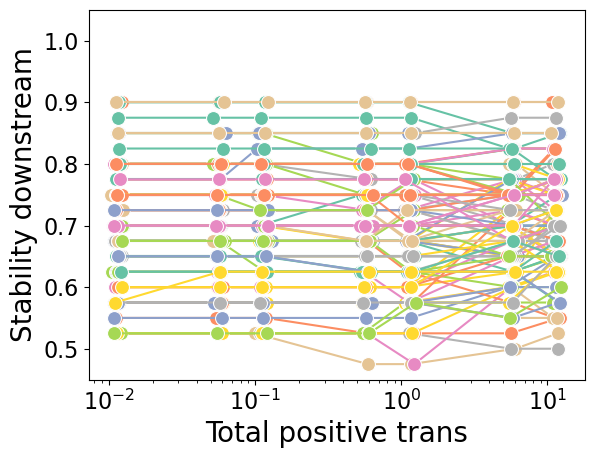

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


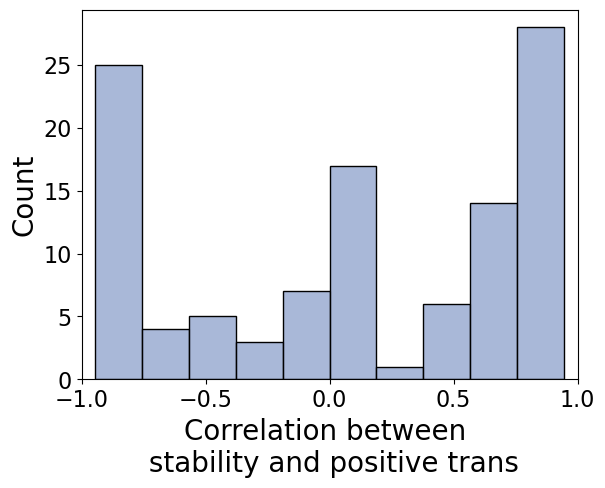

W-val alternative    p-val      RBC  CLES
Wilcoxon  2488.5     greater  0.16696  0.11467   NaN

In [26]:
sns.lineplot(data=DF, hue='MetaCommunity',palette='Set2',
                 x='positive_trans', y='stability', marker='o',
                markersize=10, legend=False)
plt.xscale('log')
plt.ylabel('Stability downstream', fontsize=20)
plt.xlabel('Total positive trans', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0.45,1.05)
plt.savefig('Manipulation_Positive3.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()
# corr
Corr=[]
for i in range(110):
    #print(DF.query(str('MetaCommunity==%d'%(i))).iloc[:, 0],)
    corr, p =sp.stats.spearmanr(DF.query(str('MetaCommunity==%d'%(i))).iloc[:, 0], 
                                DF.query(str('MetaCommunity==%d'%(i))).iloc[:, 1])
    if np.isnan(corr)==True:
        #no change
        corr=0
    Corr.append(corr)
sns.histplot(Corr,  color='#8da0cb', bins=10)
plt.xlabel('Correlation between \n stability and positive trans', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=16)
plt.xlim(-1, 1)
plt.xticks([-1, -0.5, 0.0, 0.5, 1.0])
plt.yticks(fontsize=16)

#plt.savefig('Manipulation_Positive_hist3.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()
pingouin.wilcoxon(Corr, alternative='greater')

In [214]:
np.sum(np.array(Corr)>0)

50

In [215]:
np.sum(np.array(Corr)<0)

44

In [19]:
# extract positive corr
Corr_pos=[i for i in Corr  if i > 0]
np.mean(Corr_pos)

0.6864585840049634

In [18]:
# extract negative one
Corr_neg=[i for i in Corr  if i < 0]
np.mean(Corr_neg)

-0.609456029688567

 # Generating psu-do spatial structure
 
The hierarchical spatial structure remove feedback from downstream to upstream. Then, if we have a species that is not affected by the rest species, can we generate patterns in w/o spatial strtucture similar  to w/ structures? 

In [2]:
# generating psu-do spatiak structuerd community
import random
def Parm_Sample(N, a):
    """
    Sampling parameter values of psudo-structured model
    N number of species 
    a; mean strength of species interactions from species 0 that is not affected by the other specues
    """
    r=np.random.uniform(low=0.1, high=2.0, size=(N)) # grwoth rate
    np.savetxt('growthrate.csv', r, delimiter=',', fmt='%.6f')
    A=np.eye(N) # assuming normal distribution centering 0.0 or off-diagnoal 
    # Note that MINUS A represents interactions
    for k in range(1, N):
        # note that if k==0, this species not interact with the other species
        for l in range(N):
            if k!=l:
                A[k,l] = np.random.normal(loc=0.0, scale=0.25)
   # np.savetxt('interaction.csv', A, delimiter=',', fmt='%.6f')
    return [r, -A] # note that we need negative sign for A

def ResidentGenerate(r, A, N, a):
    """
    r: gorwth vector
    A: species interaction: Note that 0th row has zero elements except for self-regulation
    N: number of species
    """
    count_max=N*(N-1)*(N-2)/6
    count=0
    l=list(range(1, N))
    while count<count_max:
        # generate target community
        L=random.sample(l, 3)
        L.append(0) # target species composition
        y0=np.zeros([N])
        for i in range(len(L)):
            y0[L[i]]=0.01
            if L[i] >0:
                #A[0,0]=-1
                A[ L[i], 0]  = np.sign(a)*sp.stats.beta.rvs(10*abs(a), 10*(1-abs(a))) # the mean strength of species interaction with resident species is fixecd
        # test whether it is feasible
        sol=solve_ivp(ODE_unstructured, [0, 300], y0=y0,
                      method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                      args=[r, A])# ODE integ
        y_last=sol.y[:,-1]
        if  np.all(Comp(y_last) == Comp(y0)):
            # we generated target community
            np.savetxt('interaction.csv', A, delimiter=',', fmt='%.6f')
            for i in range(len(y_last)):
                if y_last[i]<pow(10, -5):
                    y_last[i]=0

            return [y_last, A]
        else:
            count+=1
    # we cannot generate target comunity
    return [np.nan, A]
    
def Comp(x):
    # comver abundance data into composition data
    # x should be 1dim array of species abundances
    return x>pow(10, -5)        
    

def ODE_unstructured(t,x,  r, A):
    # note that -A represents intertaction matrix
    dx=np.zeros([np.size(x)])
    for i in range(len(dx)):
        # upstream community
        if x[i]>pow(10, -6):
            dx[i] = x[i]*(r[i] + np.dot(A[i, :], x))
    return dx

def Stability(resident, r, A):
    stability=0
    N=np.size(r)
    for n in range(N):
        inv=np.zeros([N])
        inv[n]=0.01
        sol=solve_ivp(ODE_unstructured, [0, 300], y0=resident+inv,
                      method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                      args=[r, A])# ODE integ
        # check whetehr invasion does not affect the composition od downstream
        y_last=sol.y[:,-1]
        if  np.all(Comp(y_last) == Comp(resident)):
            # species composition is maintained
            stability+=1
    return stability/N
def Interaction(a, resident):
    ans=0.0
    for i in range(1, len(resident)):
        # we ignore self-interaction term i=0
            if resident[i]>pow(10, -5):
                ans+=a[i]
    return ans
def main(N=25):
    stability=[]
    total_interaction=[]
    path='./Psudo_Spatial'
    if not os.path.exists(path):
        os.mkdir(path)
    os.chdir(path)
    replicate=30 # number of generate communities
    mean_strength=np.array([-0.9, -0.6, -0.3, -0.1, 0.1, 0.3, 0.6, 0.9])
    for i in range (len(mean_strength)) :
        a=mean_strength[i]
        path1=str('./Mean%.1f' %(a))
        os.mkdir(path1)
        os.chdir(path1)
        for j in range (replicate):
            path2=str('./Sample%d' %(j))
            os.mkdir(path2)
            os.chdir(path2)
            print(str("strength %.1f, replicate %d" %(a, j)))
            # generate species interaction matrix and growth rate
            r, A=Parm_Sample(N,a)
            # generate resident community
            resident, A = ResidentGenerate(r, A, N, a) # also update interaction matrix A
            # invasion and stability analsis
            #print(resident)
            if not np.any(np.isnan(resident)):
                np.savetxt('resident.csv', resident, delimiter=',', fmt='%.6f')
                s=Stability(resident, r, A)
                stability.append(s)
                total_interaction.append(Interaction(A[:, 0], resident))
            os.chdir('../')
        os.chdir('../')
    os.chdir('../')
    df=pd.DataFrame(data={"interaction":total_interaction, "stability":stability})
    return df

In [6]:
df=main()

strength -0.9, replicate 0
strength -0.9, replicate 1
strength -0.9, replicate 2
strength -0.9, replicate 3
strength -0.9, replicate 4
strength -0.9, replicate 5
strength -0.9, replicate 6
strength -0.9, replicate 7
strength -0.9, replicate 8
strength -0.9, replicate 9
strength -0.9, replicate 10
strength -0.9, replicate 11
strength -0.9, replicate 12
strength -0.9, replicate 13
strength -0.9, replicate 14
strength -0.9, replicate 15
strength -0.9, replicate 16
strength -0.9, replicate 17
strength -0.9, replicate 18
strength -0.9, replicate 19
strength -0.9, replicate 20
strength -0.9, replicate 21
strength -0.9, replicate 22
strength -0.9, replicate 23
strength -0.9, replicate 24
strength -0.9, replicate 25
strength -0.9, replicate 26
strength -0.9, replicate 27
strength -0.9, replicate 28
strength -0.9, replicate 29
strength -0.6, replicate 0
strength -0.6, replicate 1
strength -0.6, replicate 2
strength -0.6, replicate 3
strength -0.6, replicate 4
strength -0.6, replicate 5
strength

In [7]:
os.chdir('../')
os.getcwd()

'/Users/shibasakishota/Desktop/スイス留学/Data/Project4/data'

[0.40152602225989864, 5.487239707158215e-06]


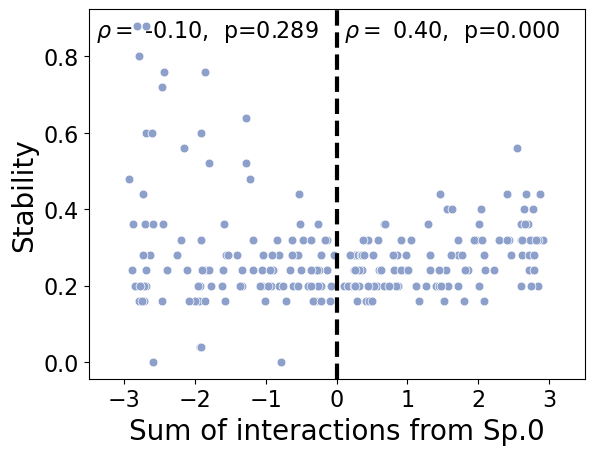

In [11]:
df.to_csv('Pseudo-Spatial.csv', index=False)
sns.scatterplot(data=df, x='interaction', y='stability', color='#8da0cb', s=40)
plt.axvline(0, color='k', linestyle='--', linewidth=3)
plt.xlabel('Sum of interactions from Sp.0', fontsize=20)
plt.ylabel('Stability', fontsize=20)
plt.xticks(fontsize=16)
plt.xlim(-3.5, 3.5)
plt.xticks([-3, -2, -1, 0, 1, 2, 3])
plt.yticks(fontsize=16)

# spearman corr
df_positive=df[df['interaction']>0]
corr_pos, p_pos=sp.stats.spearmanr(df_positive['interaction'], df_positive['stability'])
print([corr_pos, p_pos])
df_negative=df[df['interaction']<0]
corr_neg, p_neg=sp.stats.spearmanr(df_negative['interaction'], df_negative['stability'])

plt.text(x=0.1, y=0.85, s=str(r"$\rho = $ %.2f,  p=%.3f" %(corr_pos, p_pos)), fontsize=16)
plt.text(x=-3.4, y=0.85, s=str(r"$\rho = $ %.2f,  p=%.3f" %(corr_neg, p_neg)), fontsize=16)
plt.savefig('./Psudo_Spatial/Psuedo_interaction_stability.pdf',  pad_inches=0.1, bbox_inches='tight')

In [262]:
os.getcwd()

'/Users/shibasakishota/Desktop/スイス留学/Data/Project4/data'

In [17]:
os.chdir('../')
os.getcwd()

'/Users/shibasakishota/Desktop/スイス留学/Data/Project4/data'

 ## Do these stabilities was increased or decreased by species 0?
 Let's remove species 0 from the interaction matrices

In [18]:
def Diff_stab():
    
    stability=[]
    path='./Psudo_Spatial'
    os.chdir(path)
    df=pd.read_csv('Pseudo-Spatial.csv')
    replicate=30 # number of generate communities
    mean_strength=np.array([-0.9, -0.6, -0.3, -0.1, 0.1, 0.3, 0.6, 0.9])
    for i in range (len(mean_strength)) :
        a=mean_strength[i]
        path1=str('./Mean%.1f' %(a))
        os.chdir(path1)
        for j in range (replicate):
            path2=str('./Sample%d' %(j))
            os.chdir(path2)
            print(str("strength %.1f, replicate %d" %(a, j)))
            # read csv files
            r=np.loadtxt('growthrate.csv', delimiter=',')
            A=np.loadtxt('interaction.csv', delimiter=',')
            resident=np.loadtxt('resident.csv')
            # Remove species 0
            r=r[1:]
            A=A[1:, 1:]
            resident=resident[1:]
            # update resident species abundances
            sol=solve_ivp(ODE_unstructured, [0, 300], y0=resident,
                      method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                      args=[r, A])# ODE integ
            y_last=sol.y[:,-1]
            if np.all(Comp(y_last) == Comp(resident)):
                s=Stability(resident, r, A)
                stability.append(s*25/24) # consider the effect of removing species 0
            else:
                stability.append(np.nan)
            os.chdir('../')
        os.chdir('../')
    os.chdir('../')
    df['new_stability']=stability 
    return df
df_new=Diff_stab()

strength -0.9, replicate 0
strength -0.9, replicate 1
strength -0.9, replicate 2
strength -0.9, replicate 3
strength -0.9, replicate 4
strength -0.9, replicate 5
strength -0.9, replicate 6
strength -0.9, replicate 7
strength -0.9, replicate 8
strength -0.9, replicate 9
strength -0.9, replicate 10
strength -0.9, replicate 11
strength -0.9, replicate 12
strength -0.9, replicate 13
strength -0.9, replicate 14
strength -0.9, replicate 15
strength -0.9, replicate 16
strength -0.9, replicate 17
strength -0.9, replicate 18
strength -0.9, replicate 19
strength -0.9, replicate 20
strength -0.9, replicate 21
strength -0.9, replicate 22
strength -0.9, replicate 23
strength -0.9, replicate 24
strength -0.9, replicate 25
strength -0.9, replicate 26
strength -0.9, replicate 27
strength -0.9, replicate 28
strength -0.9, replicate 29
strength -0.6, replicate 0
strength -0.6, replicate 1
strength -0.6, replicate 2
strength -0.6, replicate 3
strength -0.6, replicate 4
strength -0.6, replicate 5
strength

In [19]:
df_new['Diff']=df_new['stability']-df_new['new_stability']

In [3]:
os.chdir('./Pseudo_Spatial')
df_new=pd.read_csv('PsudoSpatial_DiffStability.csv')

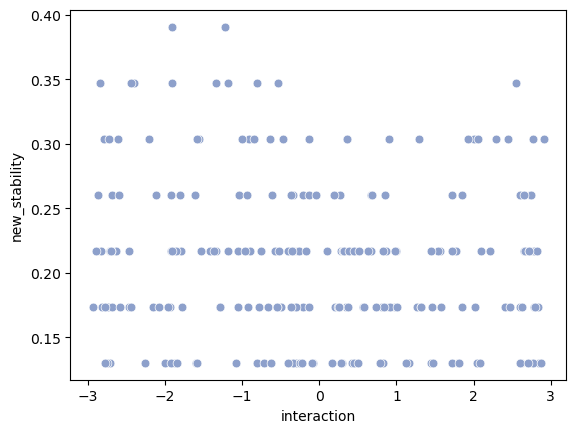

In [3]:
sns.scatterplot(data=df_new, x='interaction', y='new_stability', color='#8da0cb', s=40)
df_new.to_csv('PsudoSpatial_DiffStability.csv', index=False)

<AxesSubplot: xlabel='Diff', ylabel='Count'>

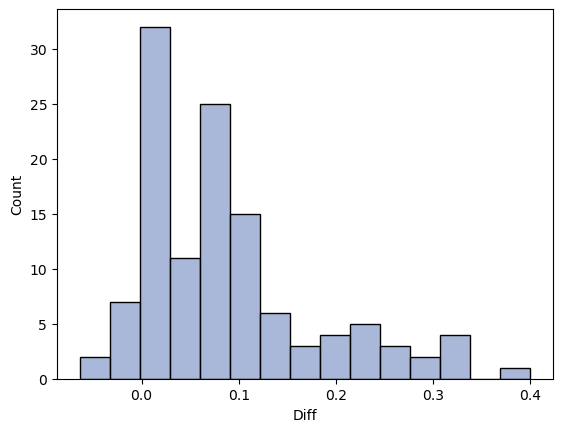

In [5]:
df_positive=df_new[df_new['interaction']>0]
sns.histplot(df_positive['Diff'], color='#8da0cb', bins=15)

<AxesSubplot: xlabel='Diff', ylabel='Count'>

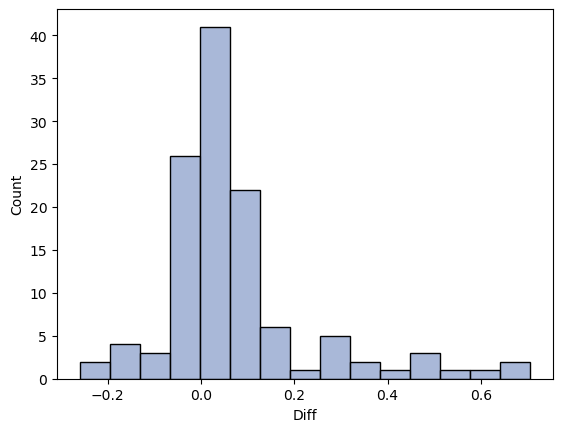

In [6]:
df_negative=df_new[df_new['interaction']<0]
sns.histplot(df_negative['Diff'], color='#8da0cb', bins=15)

<AxesSubplot:xlabel='Diff', ylabel='Count'>

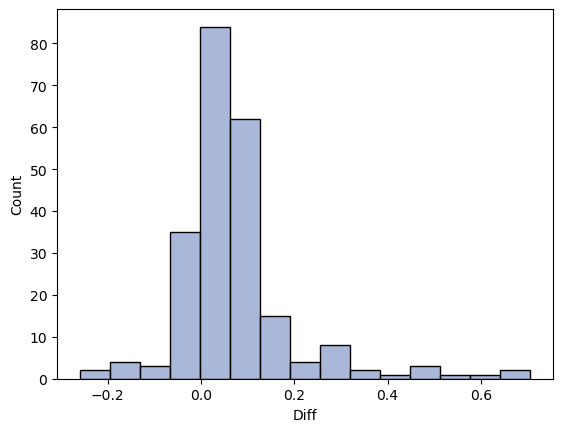

In [6]:
sns.histplot(df_new['Diff'], color='#8da0cb', bins=15)

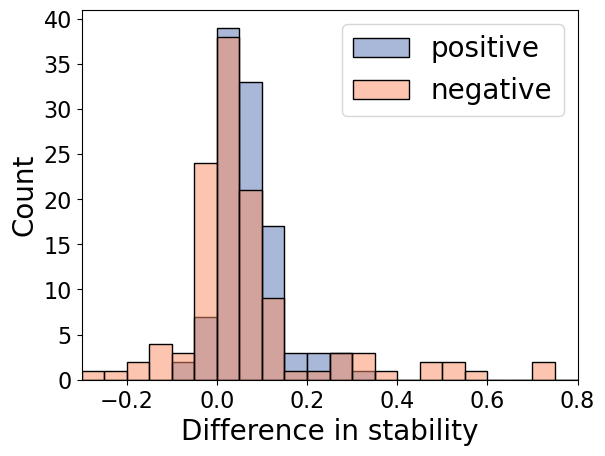

In [7]:
sns.histplot(df_positive['Diff'],  color='#8da0cb', binwidth=0.05, binrange=(-0.3, 0.8), label='positive')
sns.histplot(df_negative['Diff'],color='#fc8d62',  binwidth=0.05,binrange=(-0.3, 0.8), label='negative', alpha=0.5, )
plt.xlim(-0.3, 0.8)
plt.xlabel('Difference in stability', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Psuedo_Spatial_DiffStability.pdf',  pad_inches=0.1, bbox_inches='tight')

In [20]:
print(np.mean(df_positive['Diff']))
print(np.median(df_positive['Diff'].dropna()))
pingouin.wilcoxon(df_positive['Diff'],alternative='greater', method='approx')

0.0878784722222222
0.0663888888888889


W-val alternative         p-val       RBC  CLES
Wilcoxon  7061.0     greater  1.263765e-19  0.945179   NaN

In [19]:

print(np.mean(df_negative['Diff']))
print(np.median(df_negative['Diff'].dropna()))
print(pingouin.wilcoxon(df_negative['Diff'],alternative='greater'))

0.07054629629629629
0.0263888888888889
           W-val alternative         p-val      RBC  CLES
Wilcoxon  5766.0     greater  1.106342e-08  0.58843   NaN


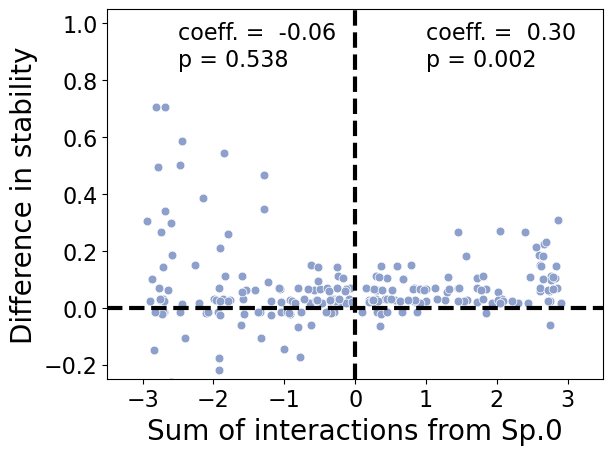

In [10]:
# correlation between stability and interaction
sns.scatterplot(data=df_new, x='interaction', y='Diff', color='#8da0cb', s=40)
plt.axvline(0, color='k', linestyle='--', linewidth=3)
plt.axhline(0, color='k', linestyle='--', linewidth=3)
plt.xlabel('Sum of interactions from Sp.0', fontsize=20)
plt.ylabel('Difference in stability', fontsize=20)
plt.xticks(fontsize=16)
plt.xlim(-3.5, 3.5)
plt.ylim(-0.25, 1.05)
plt.xticks([-3, -2, -1, 0, 1, 2, 3])
plt.yticks(fontsize=16)

dfp=df_positive.dropna()
dfn=df_negative.dropna()
corr_pos, p_pos=sp.stats.spearmanr(dfp['interaction'], dfp['Diff'])
corr_neg, p_neg=sp.stats.spearmanr(dfn['interaction'], dfn['Diff'])

plt.text(x= 1.0, y=0.85, s=str("coeff. =  %.2f \np = %.3f" %(corr_pos, p_pos)), fontsize=16)
plt.text(x=-2.5, y=0.85, s=str("coeff. =  %.2f \np = %.3f" %(corr_neg, p_neg)), fontsize=16)
plt.savefig('./Psudo_Spatial/Psuedo_interaction_DiffStability.pdf',  pad_inches=0.1, bbox_inches='tight')

In [6]:
print(len(dfp))
print(len(dfn))

108
119
